In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve


%matplotlib inline

In [2]:
%%time
train_df = pd.read_csv("../../01_input/train.csv")
test_df = pd.read_csv("../../01_input/test.csv")
pred_df = pd.read_csv('../../04_predict_test/oka_252-2_LightGBM_submission.csv')
keras_pred_df = pd.read_csv('../../04_predict_test/242_keras_submission.csv')
keras_pred_df['keras_target']=keras_pred_df['target']

CPU times: user 11.4 s, sys: 432 ms, total: 11.8 s
Wall time: 12 s


In [3]:
train_df['new'] = (train_df['var_68']*10000).astype(int)
from datetime import datetime
train_df['var_68_asdate'] = datetime(1900, 1, 1).toordinal() +  train_df['new'] - 7000
train_df['var_68_asdate'] = train_df['var_68_asdate'].astype(int).apply(datetime.fromordinal)
train_df['release_year'] = train_df['var_68_asdate'].dt.year
train_df['release_month'] = train_df['var_68_asdate'].dt.month
train_df['release_quarter'] = train_df['var_68_asdate'].dt.quarter
train_df['release_dow'] = train_df['var_68_asdate'].dt.dayofweek
train_df['release_day'] = train_df['var_68_asdate'].dt.day
train_df = train_df.drop(['new','var_68_asdate'],axis=1)

In [4]:
submit_flg=1 #全件処理かどうかをコントロール
grid_flg=1 #GridSearchをするかコントロール
SEED=12345
sample_num=10000
fold_num=5

#train関連
train_drop_col=['ID_code','target']
train_label='target'

#test関連
test_drop_col=['ID_code']

In [5]:
#x,y作成
x_train=train_df.drop(train_drop_col,axis=1)
y_train=train_df[train_label]
x_train_base=train_df.drop(train_drop_col,axis=1)
y_train_base=train_df[train_label]
x_test=test_df.drop(test_drop_col,axis=1)
x_train_col=x_train.columns

In [6]:
import glob
train_stack_df=pd.DataFrame(y_train)
test_stack_df=pd.DataFrame()
files = glob.glob('../../03_predict_train/*')
i=0
for file in files:
    if 'US4' in file:
        i+=1
        print(file)
        train_stack_df_tmp=pd.read_csv(file)
        train_stack_df['pred_'+str(i)]=train_stack_df_tmp

files = glob.glob('../../04_predict_test/*')
i=0
for file in files:
    if 'US4' in file:
        i+=1
        print(file)
        test_stack_df_tmp=pd.read_csv(file)
        
        if i == 1 :
            test_stack_df=test_stack_df_tmp
            test_stack_df.columns=['pred_1']
        else:
            test_stack_df['pred_'+str(i)]=test_stack_df_tmp


../../03_predict_train/US4_train_6.csv
../../03_predict_train/US4_train_0.csv
../../03_predict_train/US4_train_10.csv
../../03_predict_train/US4_train_2.csv
../../03_predict_train/US4_train_9.csv
../../03_predict_train/US4_train_12.csv
../../03_predict_train/US4_train_3.csv
../../03_predict_train/US4_train_13.csv
../../03_predict_train/US4_train_5.csv
../../03_predict_train/US4_train_14.csv
../../03_predict_train/US4_train_4.csv
../../03_predict_train/US4_train_11.csv
../../03_predict_train/US4_train_7.csv
../../03_predict_train/US4_train_8.csv
../../03_predict_train/US4_train_1.csv
../../04_predict_test/US4_test_2.csv
../../04_predict_test/US4_test_5.csv
../../04_predict_test/US4_test_7.csv
../../04_predict_test/US4_test_3.csv
../../04_predict_test/US4_test_12.csv
../../04_predict_test/US4_test_14.csv
../../04_predict_test/US4_test_1.csv
../../04_predict_test/US4_test_10.csv
../../04_predict_test/US4_test_11.csv
../../04_predict_test/US4_test_8.csv
../../04_predict_test/US4_test_4.csv

In [7]:
y_train_stack_df=train_stack_df['target']
x_train_stack_df=train_stack_df.drop('target',axis=1)
x_train_stack_df['mean']=x_train_stack_df.mean(axis=1)
x_train_stack_df['max']=x_train_stack_df.max(axis=1)
x_train_stack_df['min']=x_train_stack_df.min(axis=1)
x_train_stack_df['std']=x_train_stack_df.std(axis=1)


In [8]:
pred_df['label']=pred_df['target']

In [9]:
df_check=pd.concat([x_train_stack_df['mean'],keras_pred_df['keras_target']],axis=1)
df_check=pd.concat([df_check,pred_df['label']],axis=1)
df_check=pd.concat([df_check,y_train_stack_df],axis=1)
df_check=pd.concat([df_check,x_train],axis=1)

In [10]:
pd.set_option('display.max_rows', 1000)
df_check

mean  keras_target     label  target    var_0    var_1    var_2  \
0       0.036122      0.228561  0.125427       0   8.9255  -6.7863  11.9081   
1       0.696929      0.264062  0.183895       0  11.5006  -4.1473  13.8588   
2       0.023994      0.055033  0.184553       0   8.6093  -2.7457  12.0805   
3       0.491483      0.179801  0.164632       0  11.0604  -2.1518   8.9522   
4       0.258872      0.065044  0.057626       0   9.8369  -1.4834  12.8746   
5       0.081136      0.006530  0.035335       0  11.4763  -2.3182  12.6080   
6       0.293005      0.014584  0.036356       0  11.8091  -0.0832   9.3494   
7       0.199532      0.159538  0.171140       0  13.5580  -7.9881  13.8776   
8       0.245156      0.006730  0.036067       0  16.1071   2.4426  13.9307   
9       0.046868      0.011020  0.037183       0  12.5088   1.9743   8.8960   
10      0.034361      0.174223  0.213270       0   5.0702  -0.5447   9.5900   
11      0.160050      0.093907  0.049007       0  12.7188  -7.9750  10.3757   
12      0.057552      0.186552  0.064384       0   8.7671  -4.6154   9.7242   
13      0.702895      0.019452  0.048401       1  16.3699   1.5934  16.7395   
14      0.246991      0.009295  0.037040       0  13.8080   5.0514  17.2611   
15      0.430913      0.028814  0.056984       0   3.9416   2.6562  13.3633   
16      0.019796      0.189765  0.368366       0   5.0615   0.2689  15.1325   
17      0.046668      0.033463  0.051637       0   8.4199  -1.8128   8.1202   
18      0.208805      0.145870  0.198764       0   4.8750   1.2646  11.9190   
19      0.041823      0.024903  0.037341       0   4.4090  -0.7863  15.1828   
20      0.100759      0.243705  0.316667       0  12.6700  -2.0221   6.8930   
21      0.066291      0.046898  0.085965       0   8.3918   1.4806  12.9804   
22      0.170120      0.015591  0.037554       0  10.2031   0.1925  14.0238   
23      0.159772      0.073677  0.057533       0  15.0029  -9.3439  10.3790   
24      0.097771      0.108473  0.037766       0   5.9240  -3.7285  11.0995   
25      0.046409      0.052076  0.095576       0   8.2703  -5.6854  12.6862   
26      0.286883      0.043131  0.095050       0  15.6567  -4.4950  10.4867   
27      0.051473      0.009082  0.039745       0  10.7166  -9.9800  10.9569   
28      0.020025      0.163858  0.267665       0   7.8010   4.5262   8.9291   
29      0.402821      0.206760  0.093575       1   5.3301  -2.6064  13.1913   
30      0.151081      0.103602  0.063870       0  11.4118   2.6285   7.1289   
31      0.082884      0.037697  0.087724       0  11.8967   2.4613   9.6047   
32      0.143928      0.571857  0.403831       0  12.8419  -4.6105   7.9017   
33      0.592111      0.176669  0.252152       0  18.2931   0.6422  14.6849   
34      0.055963      0.009431  0.043412       0  10.0444   0.6652  12.8558   
35      0.087066      0.030830  0.050568       0  12.3225  -6.0942   6.6685   
36      0.121693      0.008188  0.041578       0   8.7925  -2.4150   7.6387   
37      0.297247      0.042324  0.039934       0   6.0211  -0.9335   9.3602   
38      0.087645      0.011091  0.036909       0  16.7131   2.1665  12.3893   
39      0.041391      0.011511  0.044998       0   9.7032  -4.0868   9.3670   
40      0.229881      0.020286  0.048548       0  11.4653   1.3359   9.6714   
41      0.163116      0.020889  0.035590       0   9.2474   2.4231   9.0991   
42      0.165242      0.033552  0.037628       0   9.0143  -6.9861  15.3908   
43      0.031488      0.009861  0.040244       0   7.6932  -2.2579   7.8384   
44      0.005726      0.034452  0.048804       0  11.9429  -7.3003  10.9356   
45      0.255668      0.068741  0.058080       0  10.5805  -4.7731   8.2096   
46      0.017764      0.040055  0.037103       0   6.0264   4.9384  13.2053   
47      0.106549      0.067624  0.056083       0  12.3814   6.8285  11.5368   
48      0.011990      0.014301  0.037089       0  11.3170   3.4296  10.3885   
49      0.084939      0.018896  0.052767       0  10.9876   1.

In [20]:
df_check['miss']=0
df_check['miss'][(df_check['mean'] > 0.5) & (df_check['target']==0)]=1
df_check

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


mean  keras_target     label  target    var_0    var_1    var_2  \
0       0.036122      0.228561  0.125427       0   8.9255  -6.7863  11.9081   
1       0.696929      0.264062  0.183895       0  11.5006  -4.1473  13.8588   
2       0.023994      0.055033  0.184553       0   8.6093  -2.7457  12.0805   
3       0.491483      0.179801  0.164632       0  11.0604  -2.1518   8.9522   
4       0.258872      0.065044  0.057626       0   9.8369  -1.4834  12.8746   
5       0.081136      0.006530  0.035335       0  11.4763  -2.3182  12.6080   
6       0.293005      0.014584  0.036356       0  11.8091  -0.0832   9.3494   
7       0.199532      0.159538  0.171140       0  13.5580  -7.9881  13.8776   
8       0.245156      0.006730  0.036067       0  16.1071   2.4426  13.9307   
9       0.046868      0.011020  0.037183       0  12.5088   1.9743   8.8960   
10      0.034361      0.174223  0.213270       0   5.0702  -0.5447   9.5900   
11      0.160050      0.093907  0.049007       0  12.7188  -7.9750  10.3757   
12      0.057552      0.186552  0.064384       0   8.7671  -4.6154   9.7242   
13      0.702895      0.019452  0.048401       1  16.3699   1.5934  16.7395   
14      0.246991      0.009295  0.037040       0  13.8080   5.0514  17.2611   
15      0.430913      0.028814  0.056984       0   3.9416   2.6562  13.3633   
16      0.019796      0.189765  0.368366       0   5.0615   0.2689  15.1325   
17      0.046668      0.033463  0.051637       0   8.4199  -1.8128   8.1202   
18      0.208805      0.145870  0.198764       0   4.8750   1.2646  11.9190   
19      0.041823      0.024903  0.037341       0   4.4090  -0.7863  15.1828   
20      0.100759      0.243705  0.316667       0  12.6700  -2.0221   6.8930   
21      0.066291      0.046898  0.085965       0   8.3918   1.4806  12.9804   
22      0.170120      0.015591  0.037554       0  10.2031   0.1925  14.0238   
23      0.159772      0.073677  0.057533       0  15.0029  -9.3439  10.3790   
24      0.097771      0.108473  0.037766       0   5.9240  -3.7285  11.0995   
25      0.046409      0.052076  0.095576       0   8.2703  -5.6854  12.6862   
26      0.286883      0.043131  0.095050       0  15.6567  -4.4950  10.4867   
27      0.051473      0.009082  0.039745       0  10.7166  -9.9800  10.9569   
28      0.020025      0.163858  0.267665       0   7.8010   4.5262   8.9291   
29      0.402821      0.206760  0.093575       1   5.3301  -2.6064  13.1913   
30      0.151081      0.103602  0.063870       0  11.4118   2.6285   7.1289   
31      0.082884      0.037697  0.087724       0  11.8967   2.4613   9.6047   
32      0.143928      0.571857  0.403831       0  12.8419  -4.6105   7.9017   
33      0.592111      0.176669  0.252152       0  18.2931   0.6422  14.6849   
34      0.055963      0.009431  0.043412       0  10.0444   0.6652  12.8558   
35      0.087066      0.030830  0.050568       0  12.3225  -6.0942   6.6685   
36      0.121693      0.008188  0.041578       0   8.7925  -2.4150   7.6387   
37      0.297247      0.042324  0.039934       0   6.0211  -0.9335   9.3602   
38      0.087645      0.011091  0.036909       0  16.7131   2.1665  12.3893   
39      0.041391      0.011511  0.044998       0   9.7032  -4.0868   9.3670   
40      0.229881      0.020286  0.048548       0  11.4653   1.3359   9.6714   
41      0.163116      0.020889  0.035590       0   9.2474   2.4231   9.0991   
42      0.165242      0.033552  0.037628       0   9.0143  -6.9861  15.3908   
43      0.031488      0.009861  0.040244       0   7.6932  -2.2579   7.8384   
44      0.005726      0.034452  0.048804       0  11.9429  -7.3003  10.9356   
45      0.255668      0.068741  0.058080       0  10.5805  -4.7731   8.2096   
46      0.017764      0.040055  0.037103       0   6.0264   4.9384  13.2053   
47      0.106549      0.067624  0.056083       0  12.3814   6.8285  11.5368   
48      0.011990      0.014301  0.037089       0  11.3170   3.4296  10.3885   
49      0.084939      0.018896  0.052767       0  10.9876   1.

In [21]:
df_check_miss=df_check[(df_check['mean']>0.5) & (df_check['target']==0)]

In [22]:
df_check_miss

mean  keras_target     label  target    var_0    var_1    var_2  \
1       0.696929      0.264062  0.183895       0  11.5006  -4.1473  13.8588   
33      0.592111      0.176669  0.252152       0  18.2931   0.6422  14.6849   
76      0.583857      0.014327  0.037531       0  11.6292   2.7266  15.3545   
90      0.752223      0.134097  0.099000       0  12.8017  -3.6662  13.0387   
105     0.520656      0.052160  0.175336       0  16.1333  -3.5974   7.2903   
110     0.611391      0.122809  0.274057       0  13.2018   0.2193  13.9407   
193     0.799276      0.044862  0.039823       0  15.9008  -5.3833  12.2930   
212     0.515410      0.048106  0.095629       0   9.8192   4.2980   9.8485   
215     0.602277      0.644453  0.456827       0  16.2942  -2.3415   6.3402   
230     0.578516      0.348962  0.045977       0   6.0749  -1.0864   5.2487   
263     0.789012      0.055411  0.038682       0   8.0040  -1.8511  11.7042   
296     0.596965      0.124678  0.062963       0  13.3937  -8.1923  12.0539   
310     0.781393      0.023282  0.068522       0  14.7966  -1.6315  13.4686   
323     0.694666      0.305201  0.364143       0  12.6075   2.4927   8.9884   
354     0.837304      0.016790  0.035621       0  10.9269  -8.1411  12.4530   
393     0.894861      0.026076  0.050215       0  11.5706   6.5439   8.3873   
409     0.549756      0.018293  0.067428       0  12.9824  -3.0515  12.8160   
417     0.896839      0.008525  0.034816       0   9.0647   8.0946   7.1414   
429     0.654143      0.007465  0.037991       0  13.5595  -3.9111  15.6162   
448     0.596540      0.024023  0.104792       0  12.2578  -5.0810  10.1576   
463     0.667567      0.137128  0.079558       0   8.7056   8.0733  12.3330   
484     0.757740      0.103149  0.066710       0   9.8163   2.9904   8.4530   
551     0.545780      0.052038  0.044219       0   7.9751   5.1699  10.1413   
561     0.658360      0.065014  0.233324       0  13.2976  -0.9711  14.0018   
587     0.578393      0.018257  0.052416       0  10.7207  -3.6192   5.1053   
596     0.724919      0.019264  0.037332       0  16.4590   1.3555  10.6305   
611     0.627535      0.423771  0.129204       0   9.1122  -3.1967   7.9000   
617     0.642731      0.181816  0.094594       0  13.0865  -0.6820  14.5655   
622     0.537890      0.023158  0.038308       0  12.2090  -0.1882  12.6586   
706     0.612880      0.013927  0.039491       0  15.8345   2.7429  10.1496   
708     0.598845      0.180708  0.120080       0   8.0432  -7.4644   8.3017   
722     0.813032      0.054971  0.047389       0  16.3769  -6.5280  13.0080   
747     0.508706      0.007826  0.036244       0  12.6392  -5.4805  14.6196   
756     0.753791      0.104730  0.069809       0   5.2166   7.0495  15.1260   
761     0.619450      0.008907  0.037539       0  11.5340   6.1182  12.8414   
772     0.588425      0.188508  0.128089       0  10.1338  -2.3729  14.0805   
798     0.501701      0.458391  0.366255       0  12.8253   5.0412   8.1676   
816     0.631033      0.062585  0.278209       0  10.8212  -2.8581  13.1819   
889     0.720338      0.090990  0.106560       0   9.4876  -0.5194  15.3454   
894     0.724340      0.015034  0.084619       0   8.2231  -4.7225  14.8006   
929     0.520312      0.390615  0.228939       0  15.9391  -1.9140   6.7064   
933     0.714334      0.026349  0.057634       0  17.3308   7.8597  13.4084   
974     0.874813      0.093238  0.138022       0  11.2529   7.6074   6.7189   
993     0.533814      0.014816  0.060341       0   9.4936  -3.1972   9.7888   
1007    0.625575      0.018573  0.210777       0   5.4274   6.7085   9.7421   
1008    0.581564      0.024230  0.049777       0  11.0784   0.1405  12.8151   
1064    0.653160      0.010517  0.037625       0   6.8507  -8.1635  14.0353   
1087    0.736435      0.109507  0.064567       0  16.4724   0.5858   9.9285   
1088    0.769787      0.029365  0.048248       0  12.6540   0.8264  12.0387   
1120    0.503629      0.060826  0.089136       0  11.4693  -6.

In [23]:
df_check_miss.describe()

mean  keras_target         label   target         var_0  \
count  11055.000000  11055.000000  11055.000000  11055.0  11055.000000   
mean       0.652798      0.097115      0.105220      0.0     11.186053   
std        0.115837      0.136908      0.128378      0.0      3.280594   
min        0.500019      0.001463      0.034326      0.0      1.294400   
25%        0.555450      0.018701      0.039525      0.0      8.721750   
50%        0.628081      0.044304      0.055092      0.0     10.995600   
75%        0.728073      0.109375      0.101892      0.0     13.410800   
max        0.993458      0.829579      0.824413      0.0     19.626500   

              var_1         var_2         var_3         var_4         var_5  \
count  11055.000000  11055.000000  11055.000000  11055.000000  11055.000000   
mean      -0.995121     11.215998      6.822886     11.125084     -4.362691   
std        4.207444      2.867819      2.065183      1.647015      8.113029   
min      -13.454300      3.055800      0.494100      5.920000    -25.332300   
25%       -4.122200      9.001450      5.288200      9.914250    -10.595150   
50%       -0.984300     11.104700      6.837400     11.162200     -4.085000   
75%        1.994750     13.160900      8.338300     12.316800      1.601100   
max       10.376800     19.353000     13.098300     16.044800     16.303700   

        ...          var_196       var_197       var_198       var_199  \
count   ...     11055.000000  11055.000000  11055.000000  11055.000000   
mean    ...         2.662746      8.803486     15.332309     -2.523180   
std     ...         5.596411      0.951674      3.250323     10.391843   
min     ...       -13.030700      6.231700      7.207200    -35.225100   
25%     ...        -1.698450      8.142300     13.152150    -10.349900   
50%     ...         2.842100      8.787400     15.394700     -1.833900   
75%     ...         7.020750      9.502250     17.737900      5.583500   
max     ...        16.381900     11.739500     24.829500     27.136200   

       release_year  release_month  release_quarter   release_dow  \
count  11055.000000   11055.000000     11055.000000  11055.000000   
mean    2017.879512       4.844052         1.957847      2.953957   
std        0.325547       2.996819         0.982217      2.007530   
min     2017.000000       1.000000         1.000000      0.000000   
25%     2018.000000       3.000000         1.000000      1.000000   
50%     2018.000000       4.000000         2.000000      3.000000   
75%     2018.000000       6.000000         2.000000      5.000000   
max     2018.000000      12.000000         4.000000      6.000000   

        release_day     miss  
count  11055.000000  11055.0  
mean      15.714790      1.0  
std        8.745956      0.0  
min        1.000000      1.0  
25%        8.000000      1.0  
50%       16.000000      1.0  
75%       23.000000      1.0  
max       31.000000      1.0  

[8 rows x 210 columns]

In [15]:
df_check[df_check['miss']==1].nunique()

mean               11055
keras_target       11032
label              11055
target                 1
var_0              10506
var_1              10645
var_2              10450
var_3              10281
var_4              10129
var_5              10839
var_6               9433
var_7              10566
var_8              10539
var_9               9809
var_10             10727
var_11             10769
var_12              5875
var_13             10702
var_14             10341
var_15              7947
var_16             10404
var_17             10788
var_18             10791
var_19             10857
var_20             10768
var_21             10838
var_22             10519
var_23              8495
var_24             10613
var_25              6927
var_26             10768
var_27             10061
var_28              9254
var_29             10401
var_30             10857
var_31             10272
var_32             10449
var_33             10663
var_34              8568
var_35             10740


In [16]:
train_df[train_df['target']==1].describe()

target         var_0         var_1         var_2         var_3  \
count  20098.0  20098.000000  20098.000000  20098.000000  20098.000000   
mean       1.0     11.156418     -1.017613     11.156633      6.864113   
std        0.0      3.270293      4.220638      2.841075      2.070898   
min        1.0      0.452800    -14.037000      2.946200      0.374000   
25%        1.0      8.695875     -4.203475      8.961125      5.314300   
50%        1.0     11.001350     -0.992650     11.096700      6.900200   
75%        1.0     13.343700      2.001375     13.047025      8.384725   
max        1.0     19.458300      9.029800     18.294100     12.706900   

              var_4         var_5         var_6         var_7         var_8  \
count  20098.000000  20098.000000  20098.000000  20098.000000  20098.000000   
mean      11.131337     -4.336522      5.581966     16.514917      0.479432   
std        1.649266      8.140281      0.922442      3.421365      3.340028   
min        5.876200    -28.246100      2.496000      7.302400     -9.839100   
25%        9.911250    -10.615800      4.882250     13.880125     -2.107425   
50%       11.156300     -4.101950      5.601800     16.412700      0.579600   
75%       12.328450      1.619950      6.218550     19.044250      3.127825   
max       15.692500     16.423600      8.285200     27.039800      9.033000   

           ...            var_195       var_196       var_197       var_198  \
count      ...       20098.000000  20098.000000  20098.000000  20098.000000   
mean       ...          -0.021130      2.688583      8.810815     15.393283   
std        ...           1.485975      5.556892      0.952554      3.248123   
min        ...          -5.018500    -14.020400      6.119000      6.558700   
25%        ...          -1.103950     -1.572225      8.155250     13.232500   
50%        ...          -0.057350      2.831050      8.795400     15.427950   
75%        ...           0.986450      6.956250      9.517000     17.776425   
max        ...           4.088100     17.161400     11.706900     25.857100   

            var_199  release_year  release_month  release_quarter  \
count  20098.000000  20098.000000   20098.000000     20098.000000   
mean      -2.532243   2017.879092       4.862673         1.965519   
std       10.435910      0.326028       2.993890         0.979846   
min      -38.852800   2017.000000       1.000000         1.000000   
25%      -10.285050   2018.000000       3.000000         1.000000   
50%       -1.971850   2018.000000       4.000000         2.000000   
75%        5.701475   2018.000000       6.000000         2.000000   
max       24.564600   2018.000000      12.000000         4.000000   

        release_dow   release_day  
count  20098.000000  20098.000000  
mean       2.943278     15.826998  
std        2.001409      8.757210  
min        0.000000      1.000000  
25%        1.000000      8.000000  
50%        3.000000     16.000000  
75%        5.000000     23.000000  
max        6.000000     31.000000  

[8 rows x 206 columns]

In [17]:
train=df_check

/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


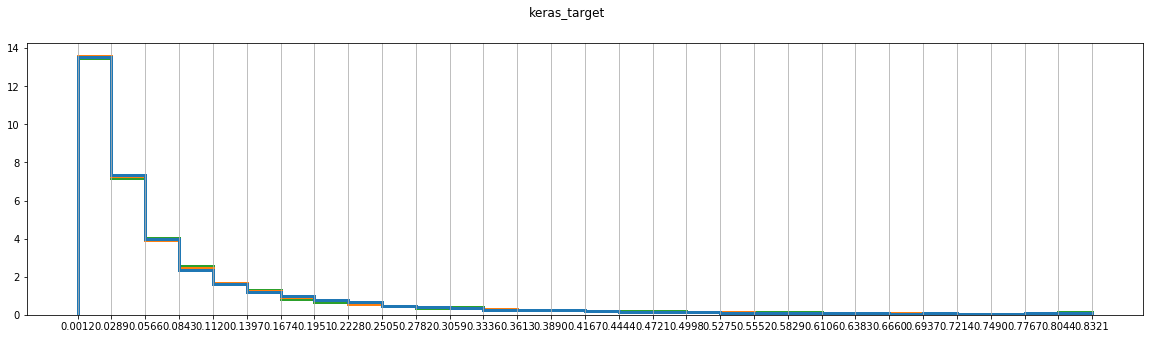

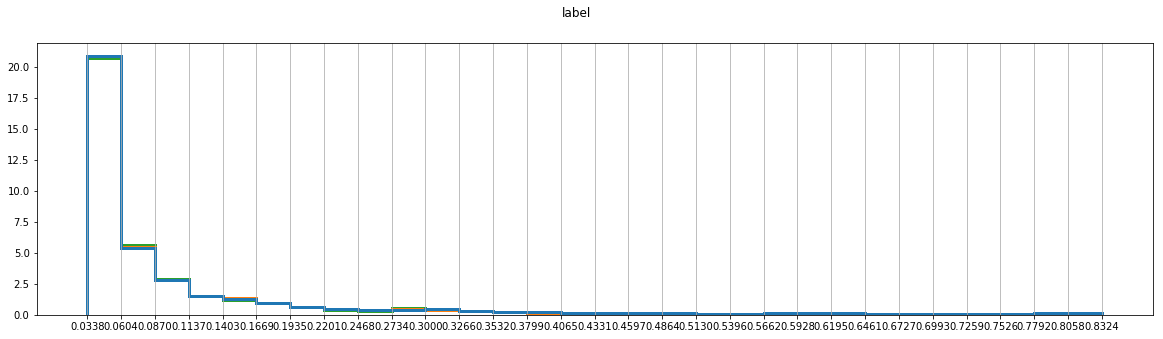

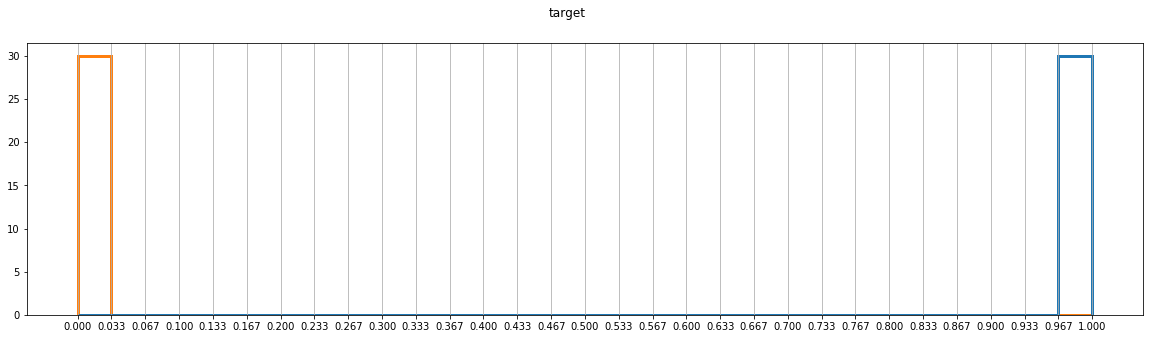

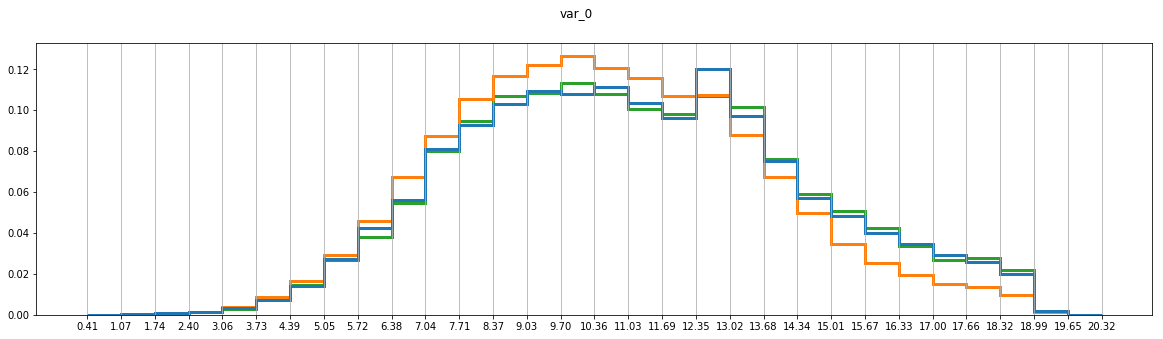

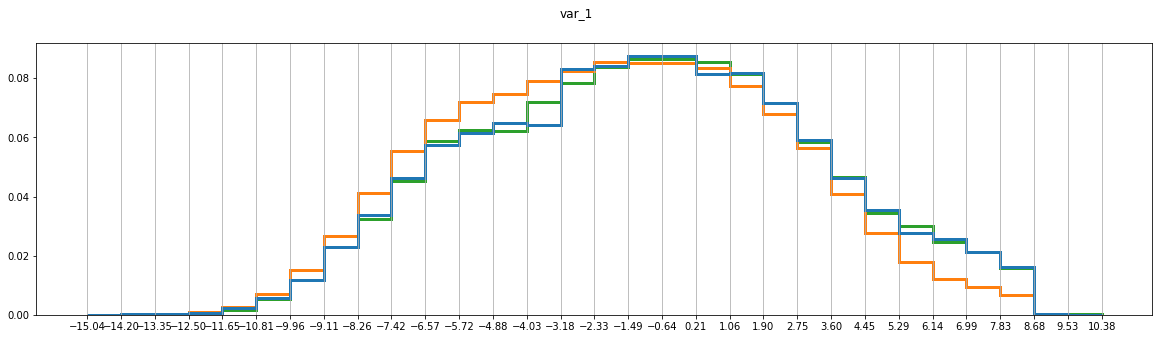

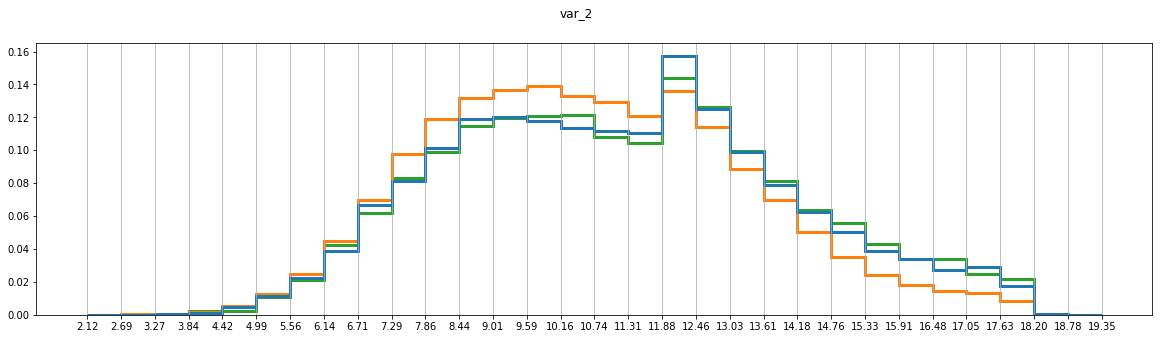

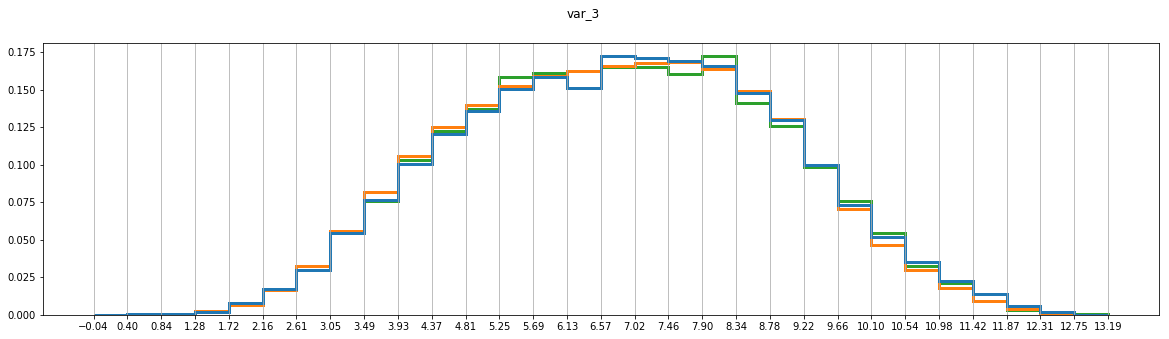

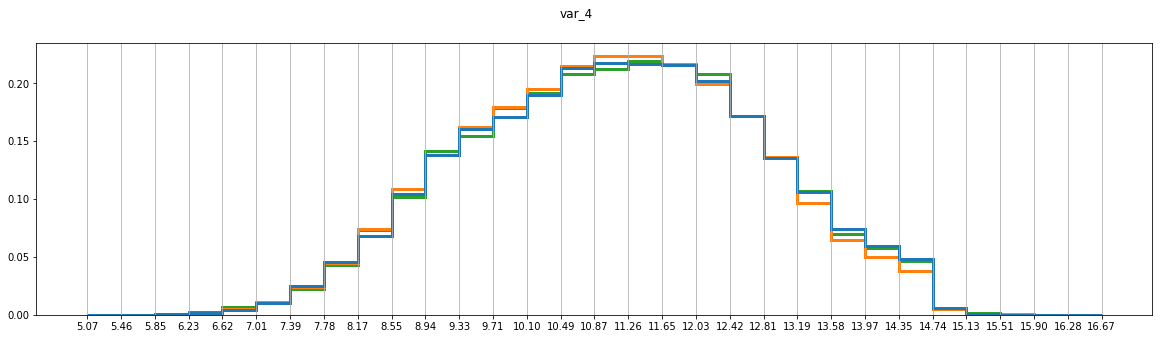

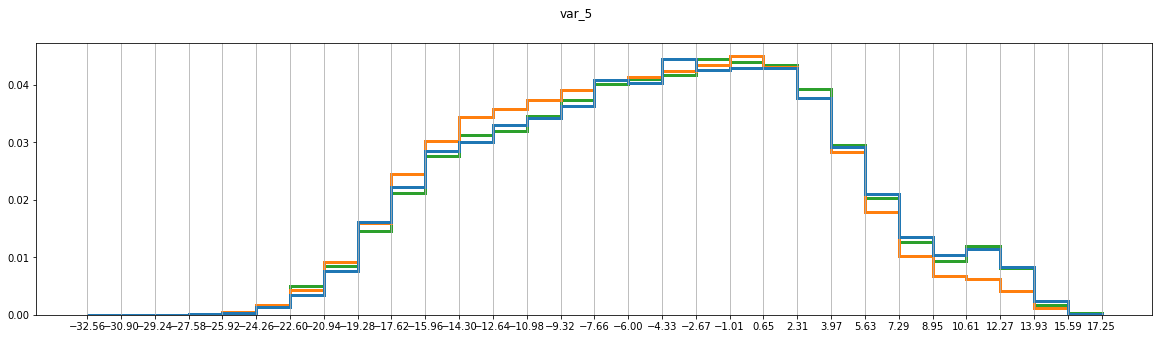

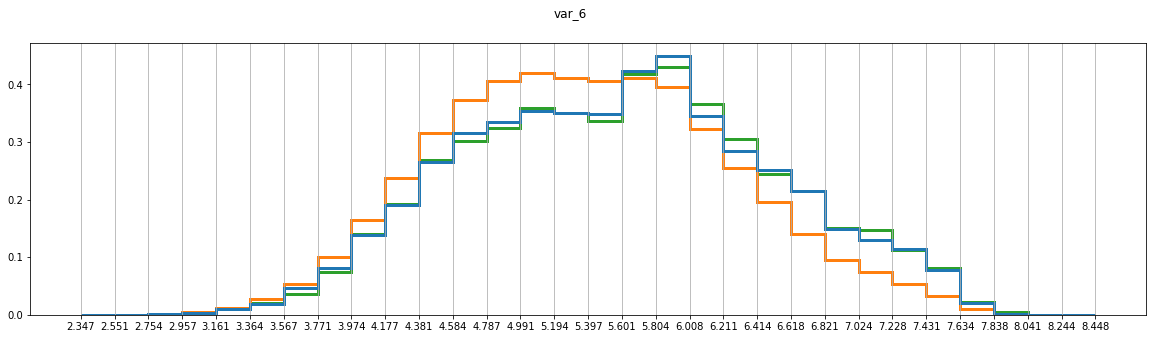

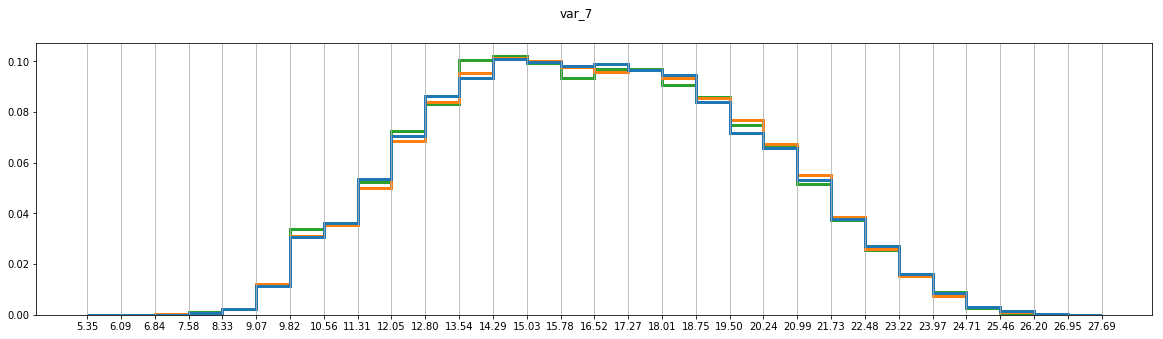

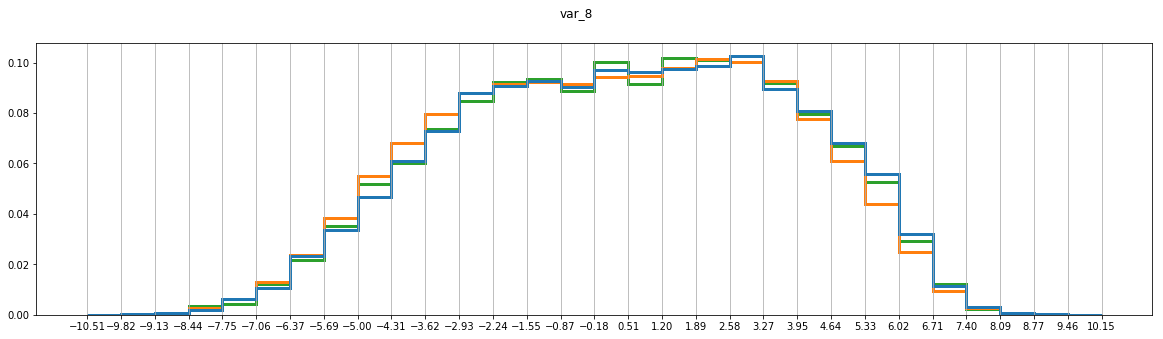

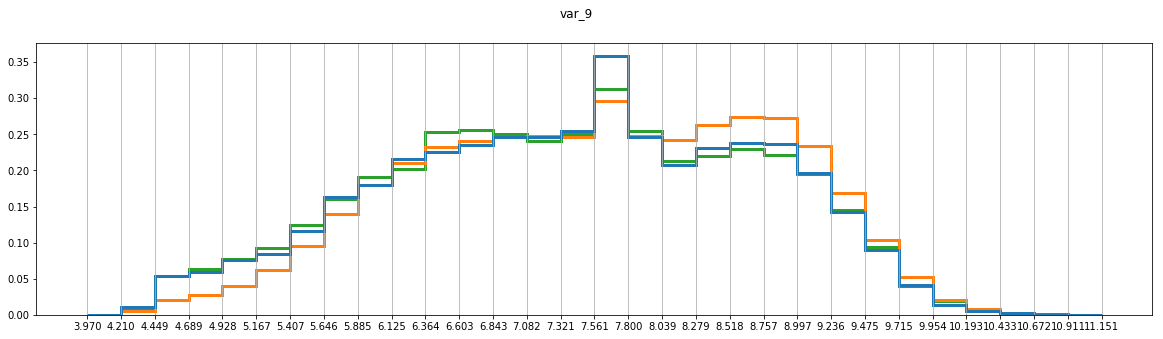

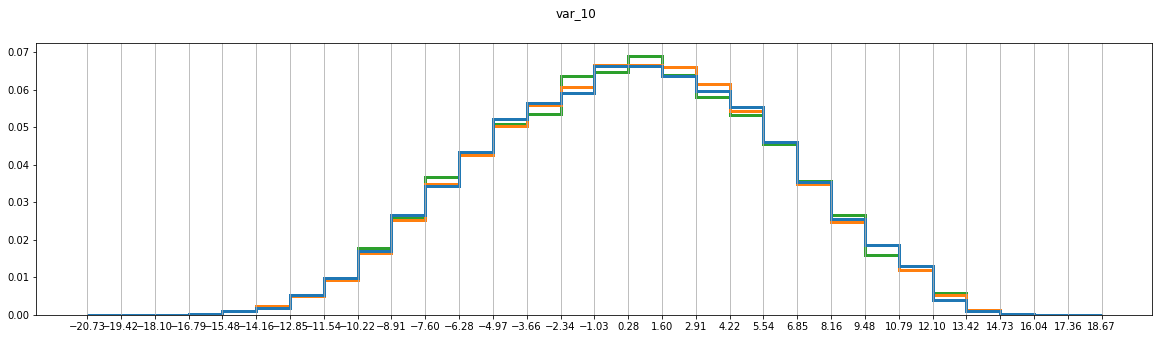

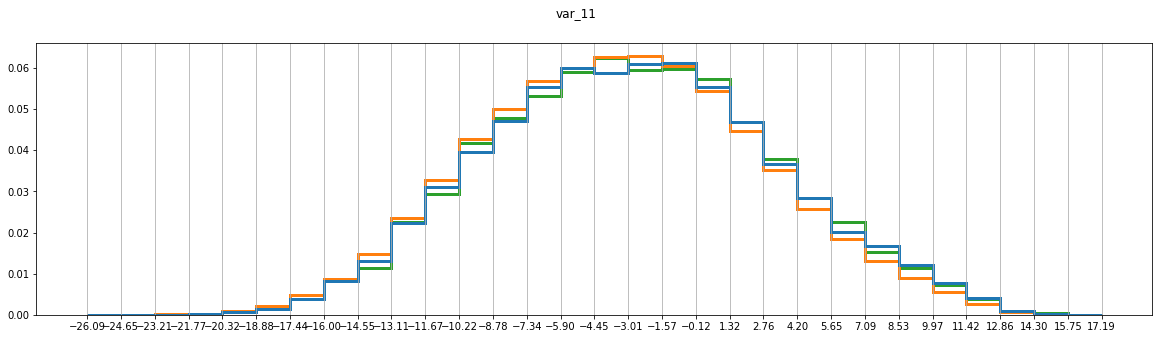

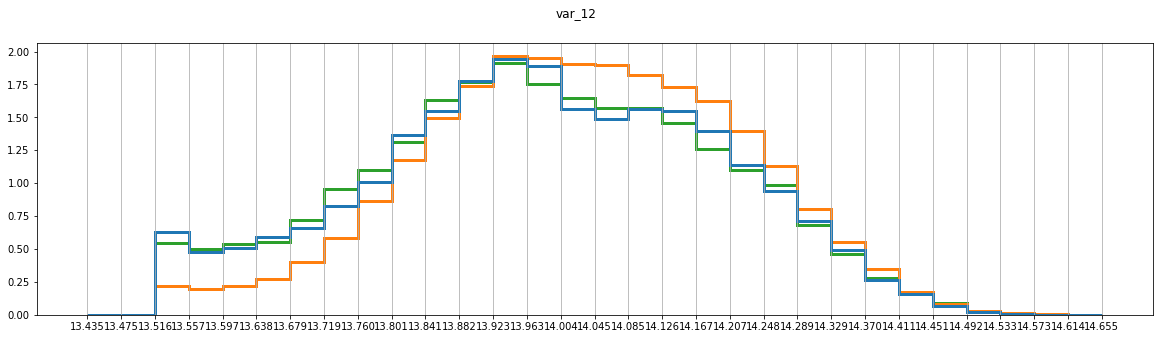

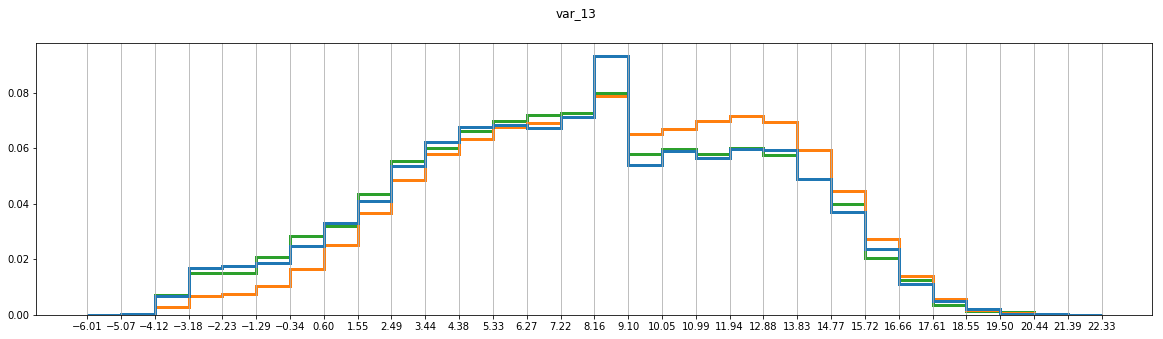

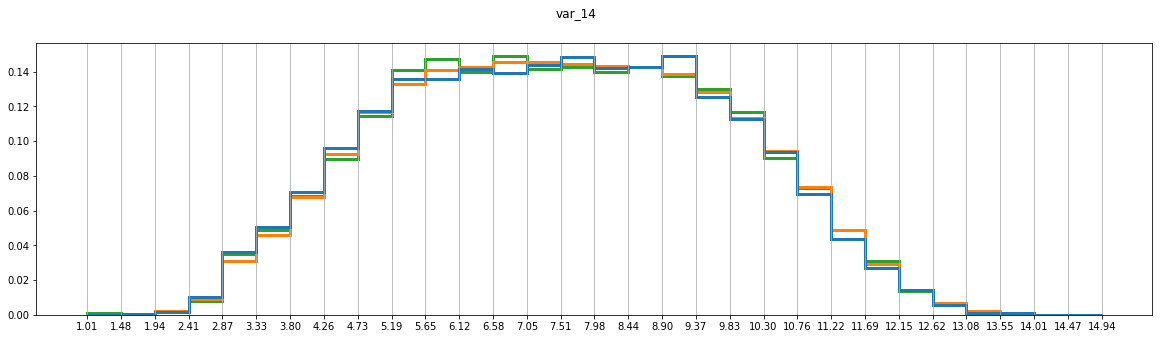

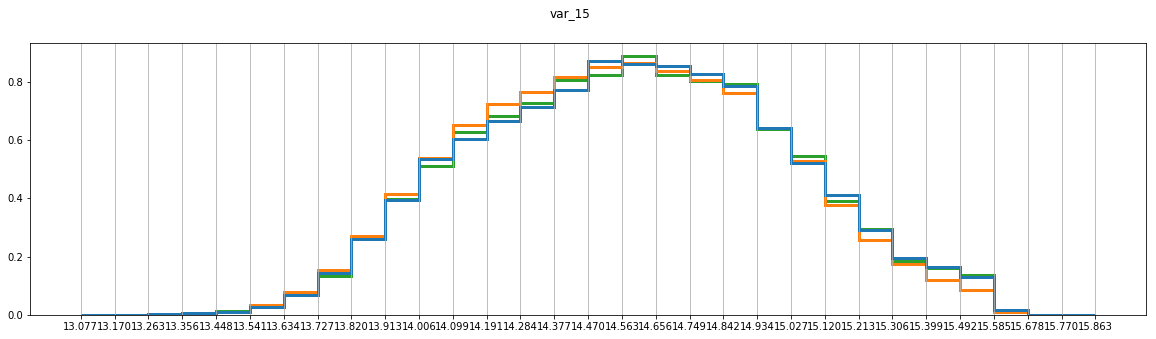

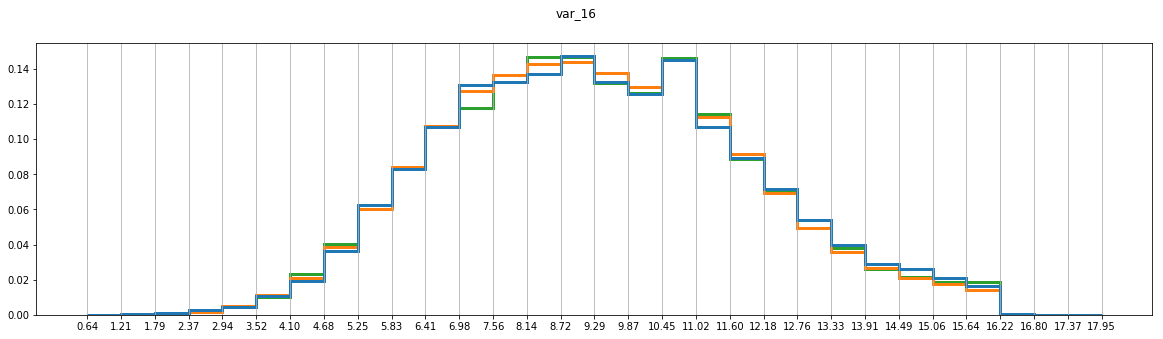

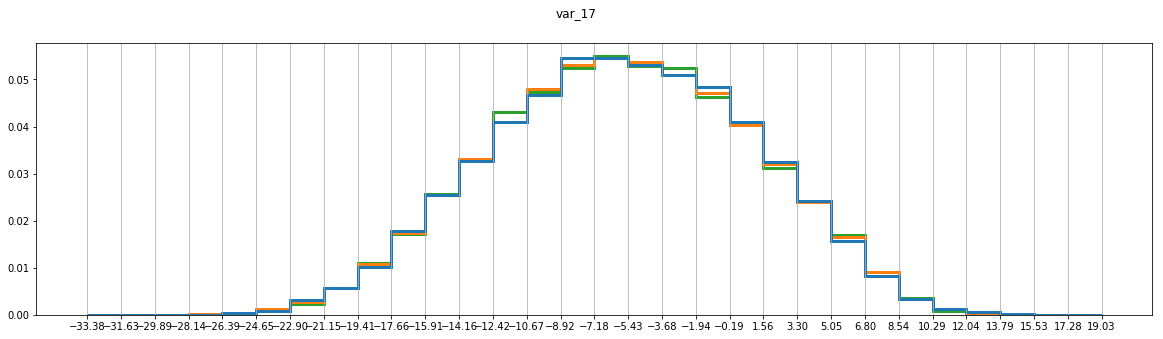

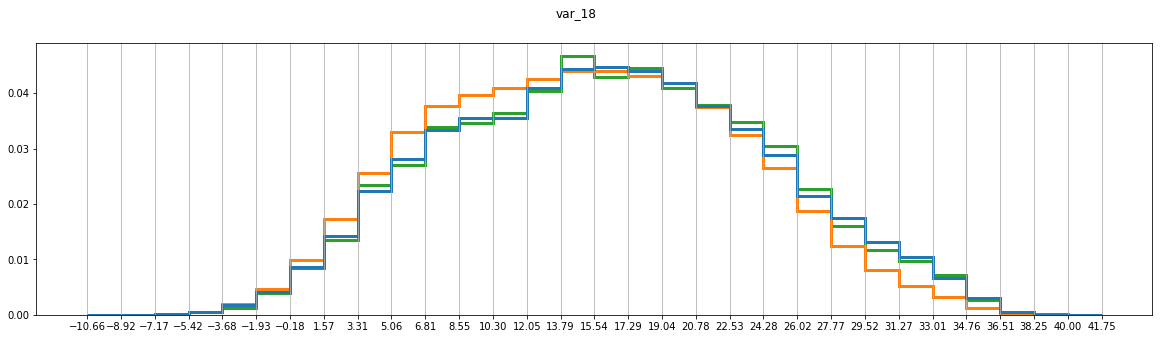

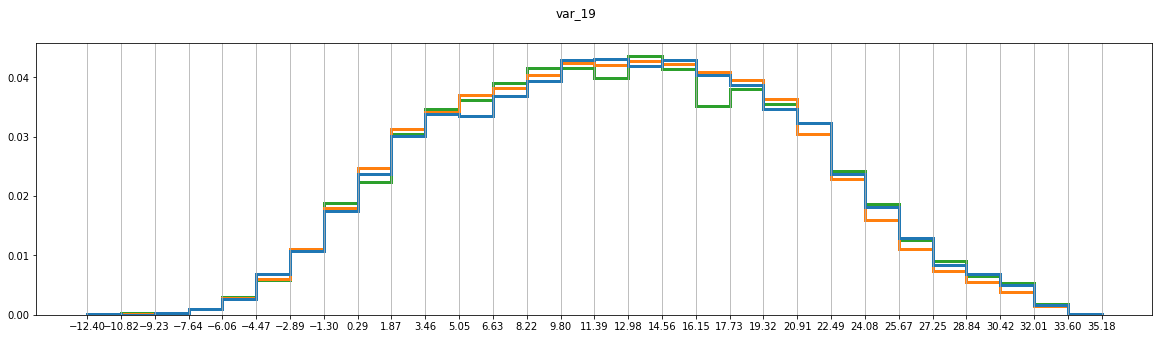

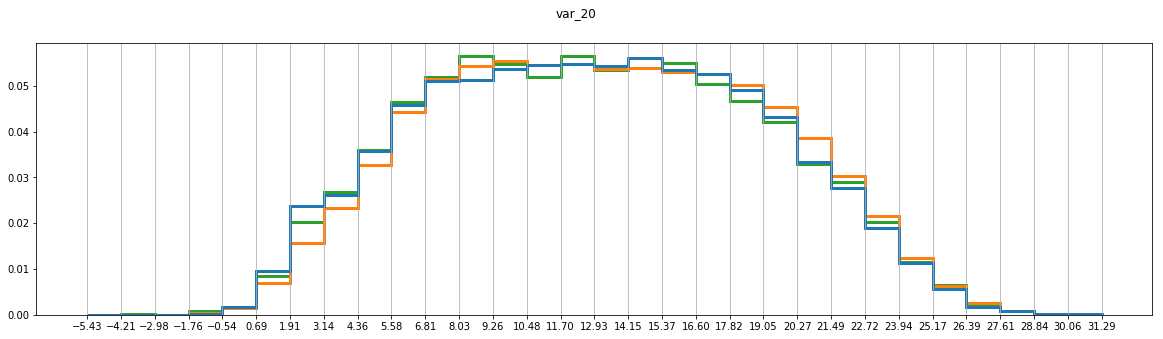

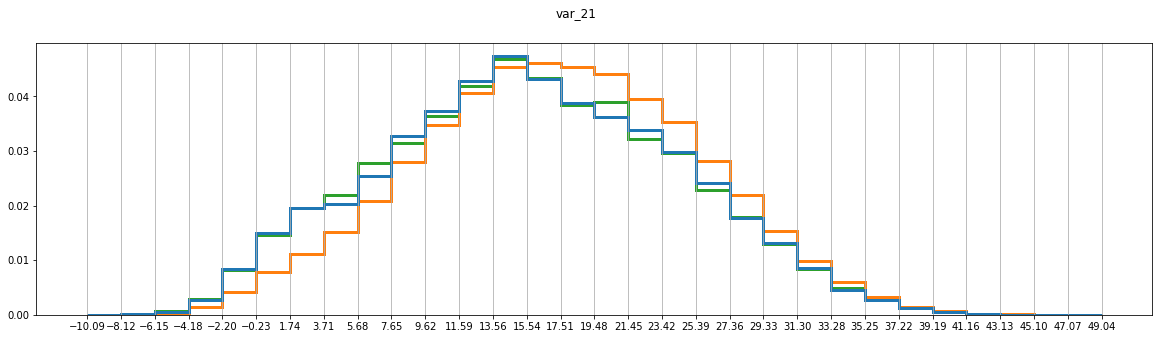

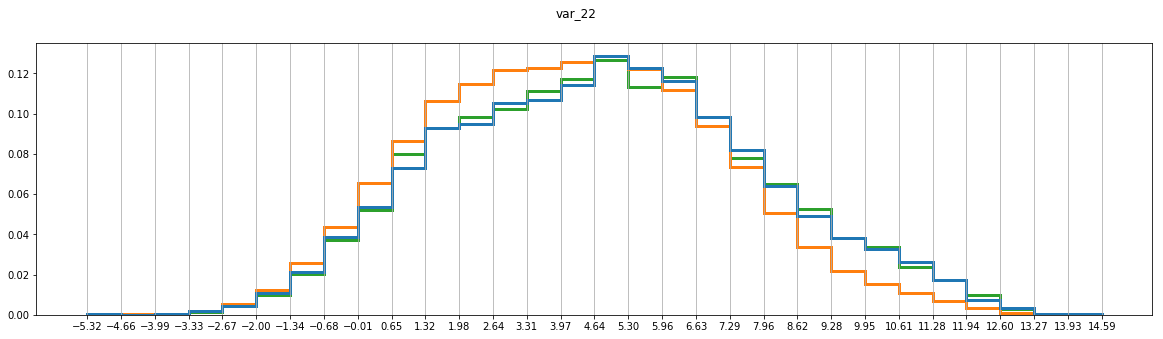

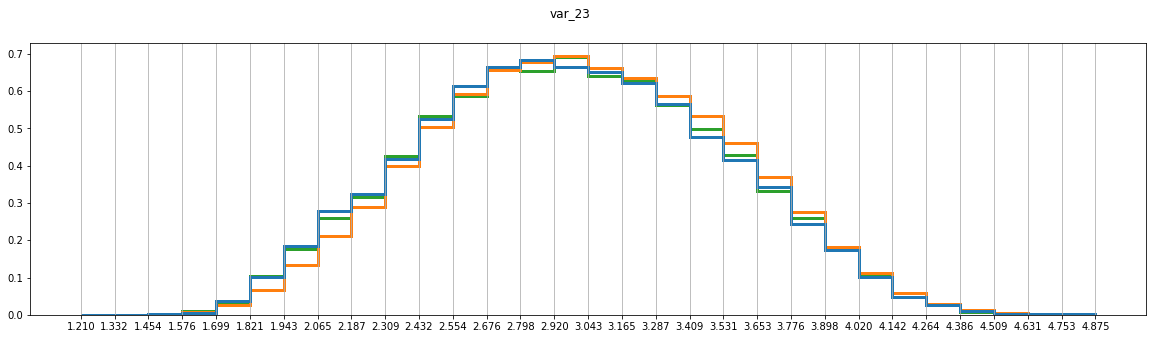

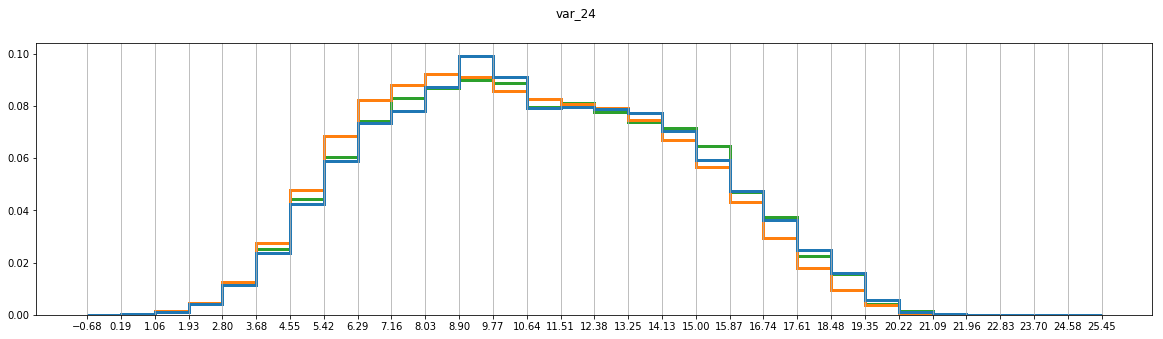

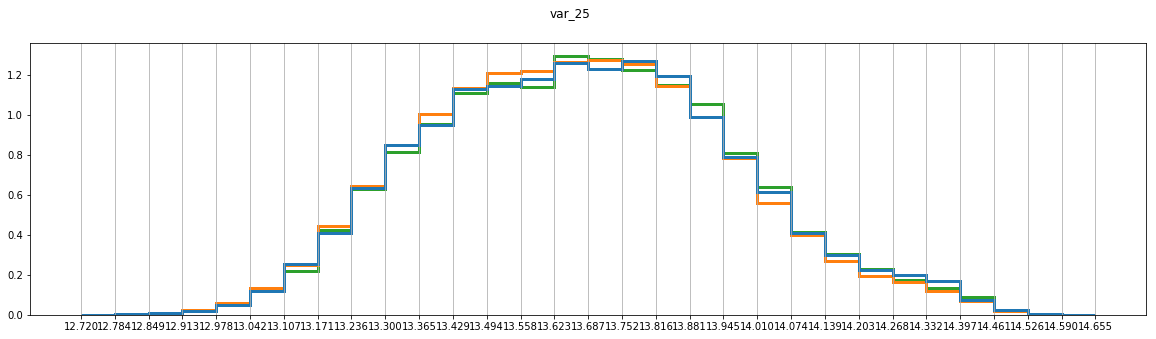

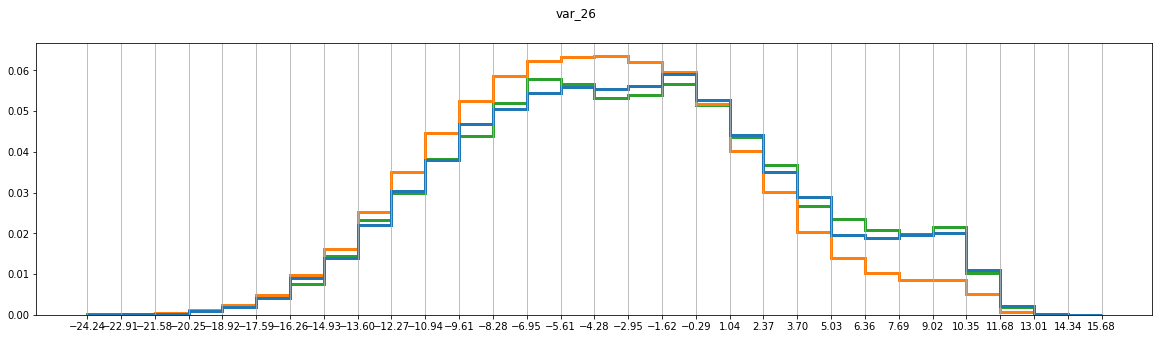

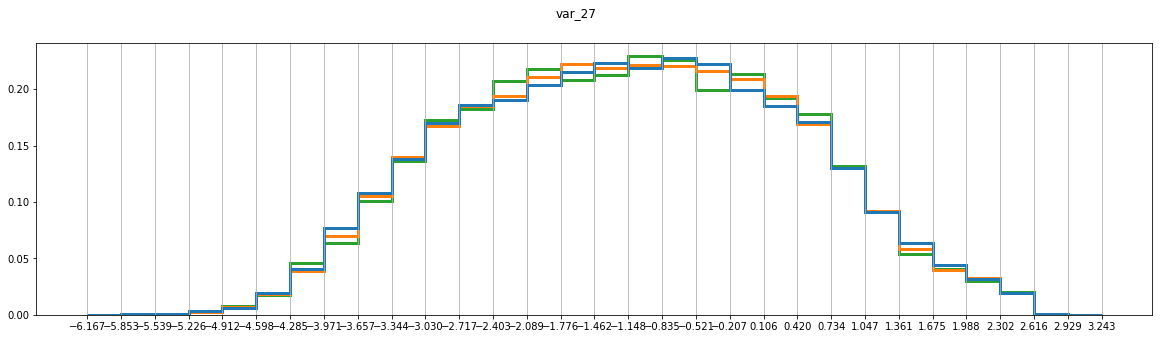

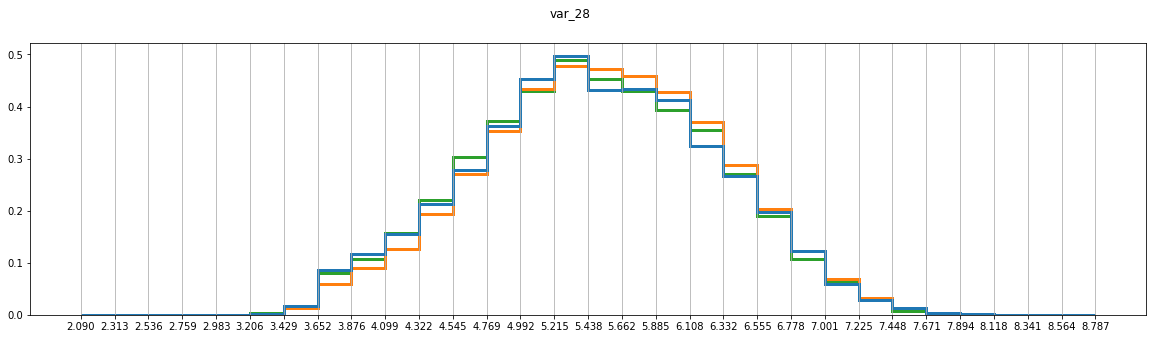

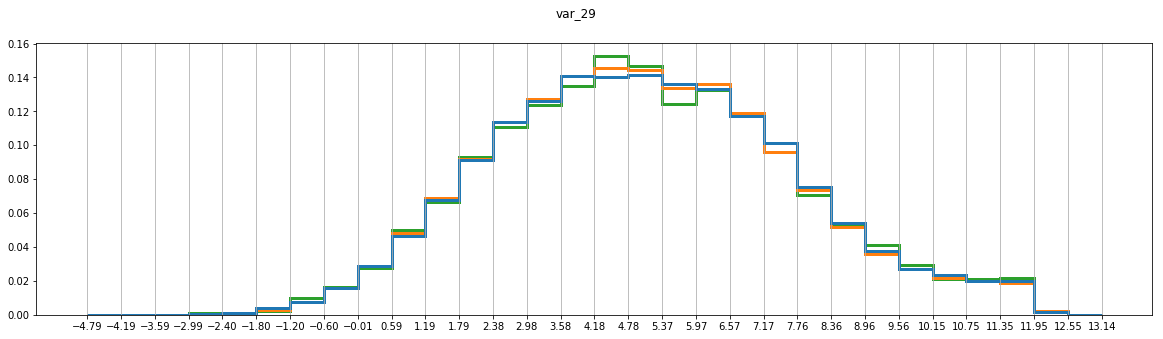

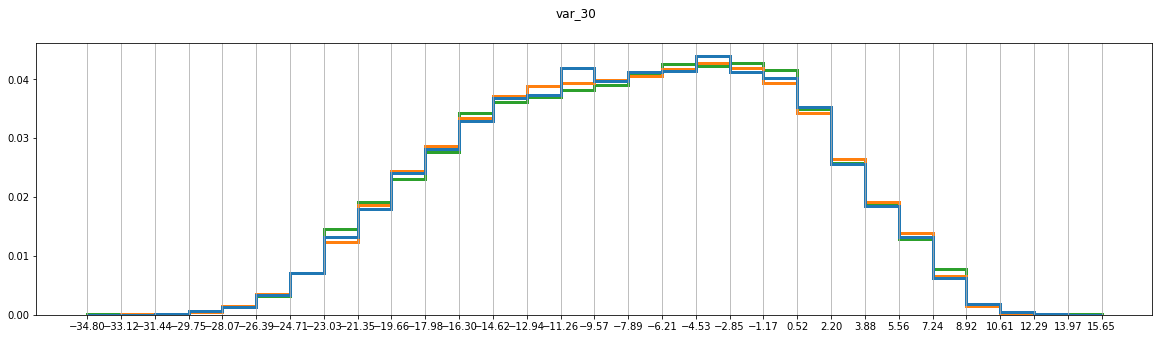

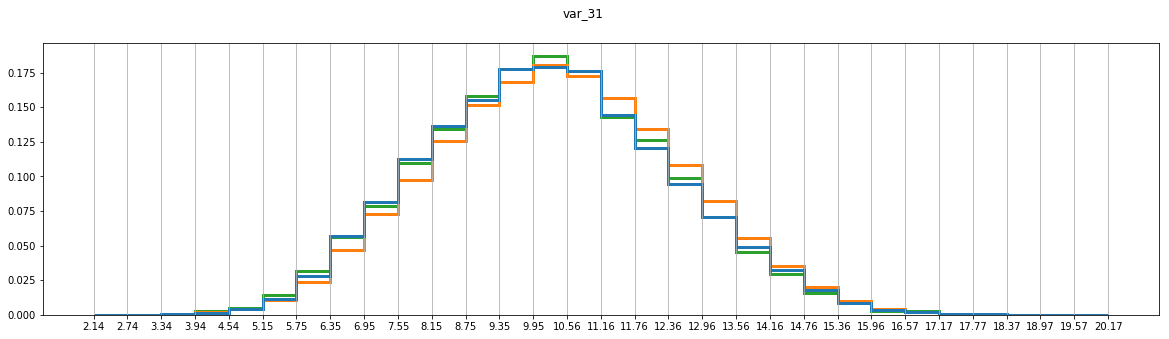

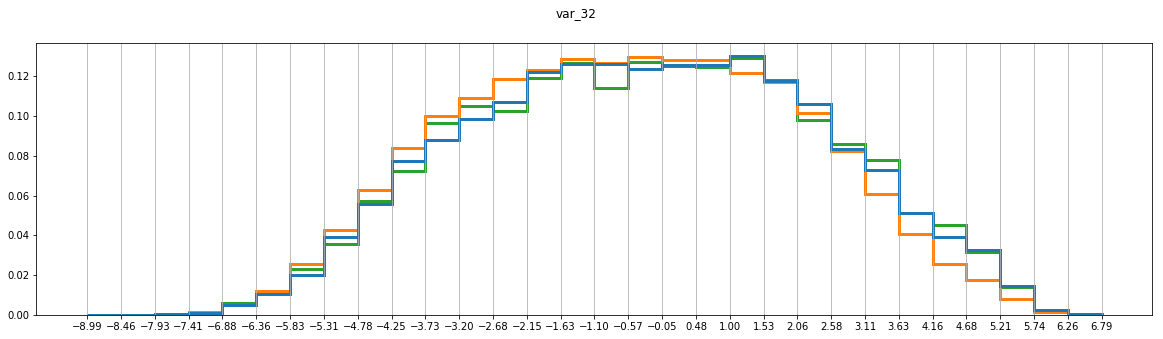

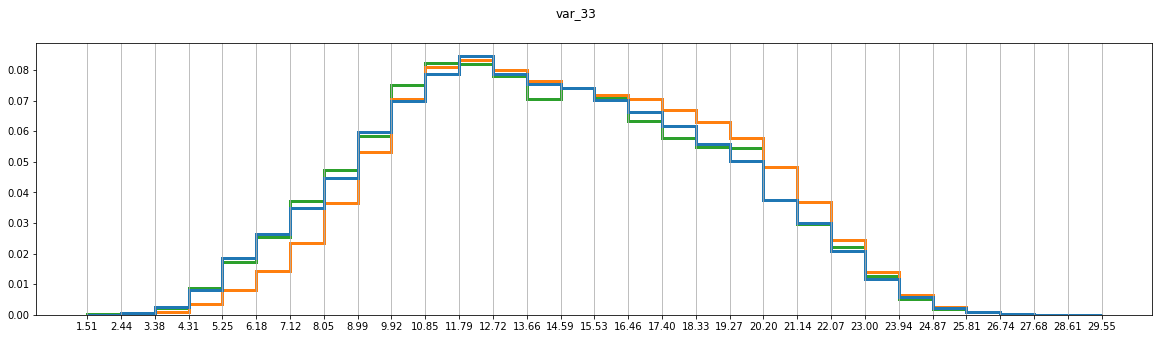

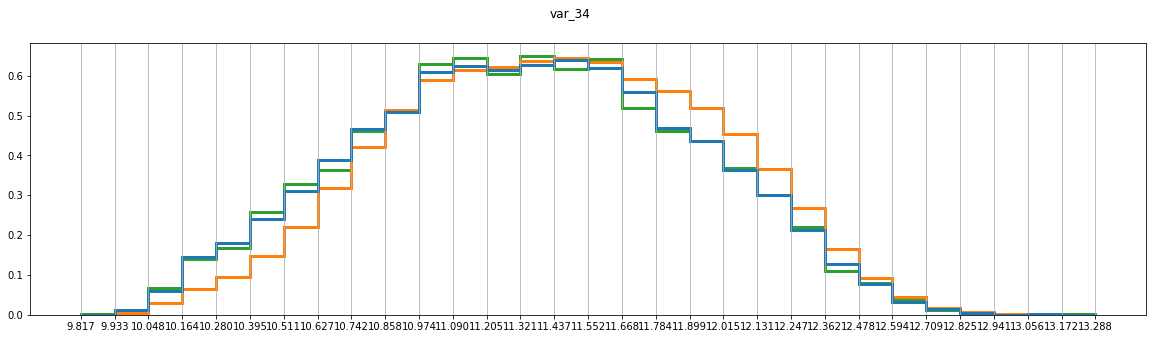

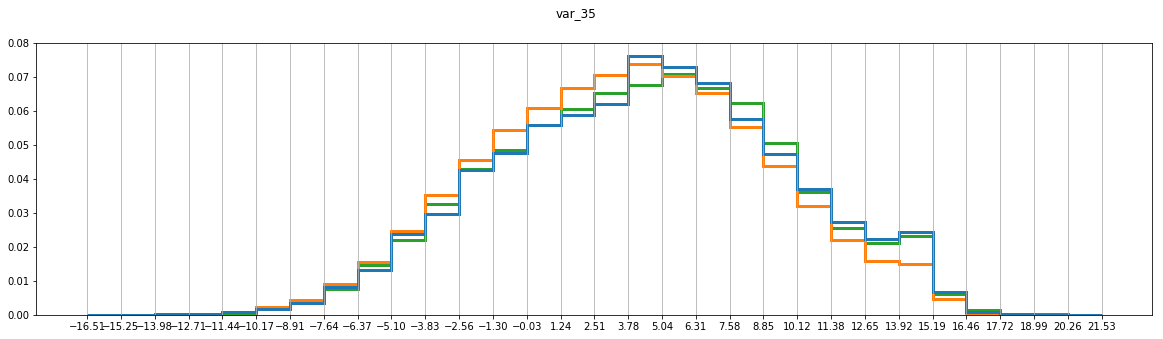

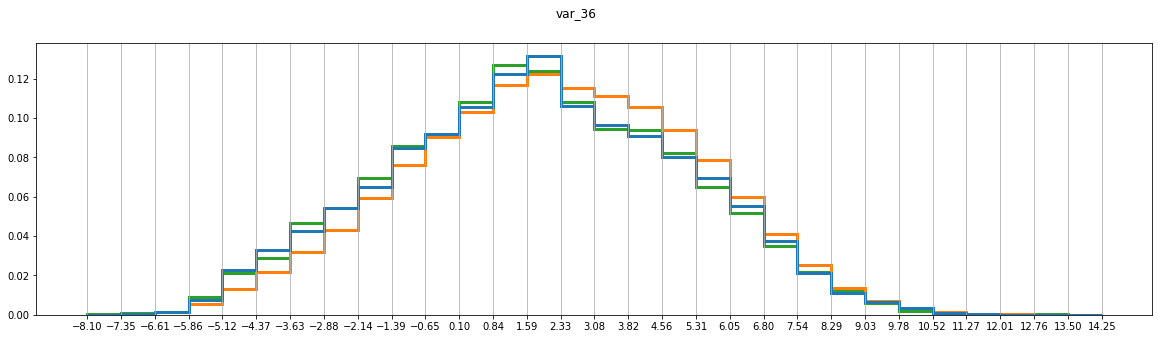

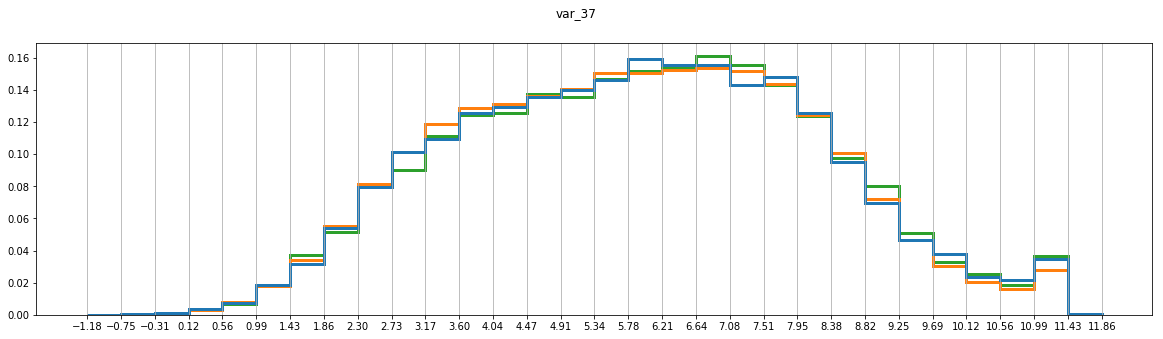

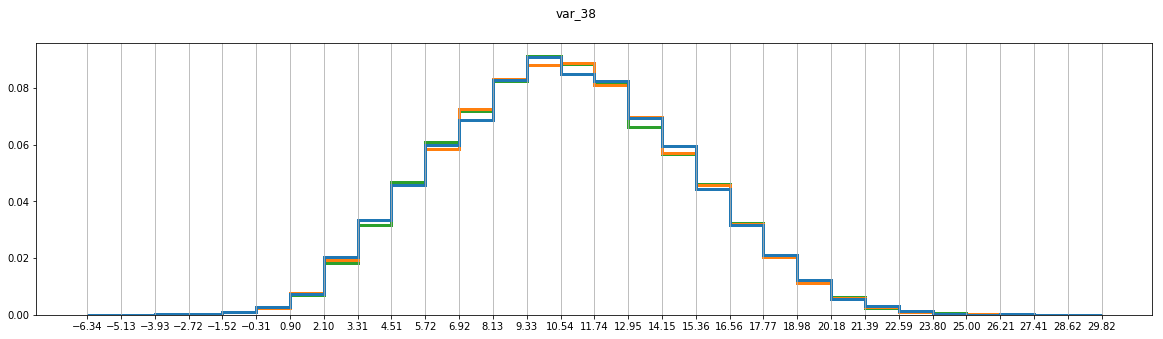

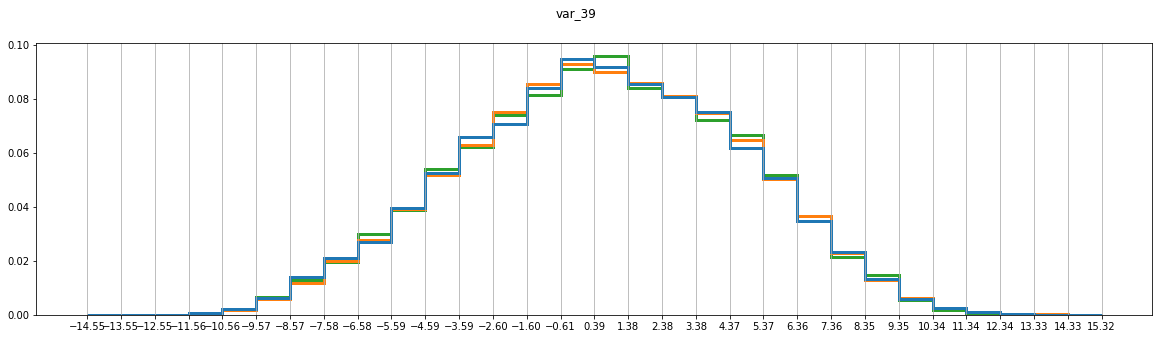

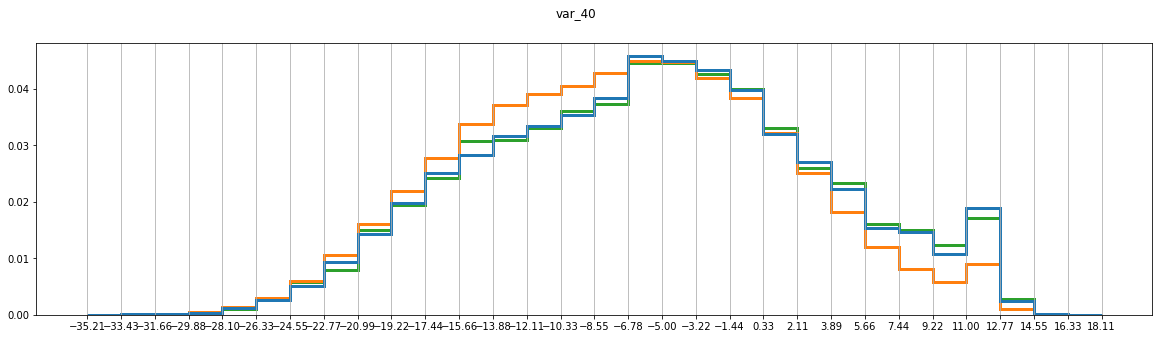

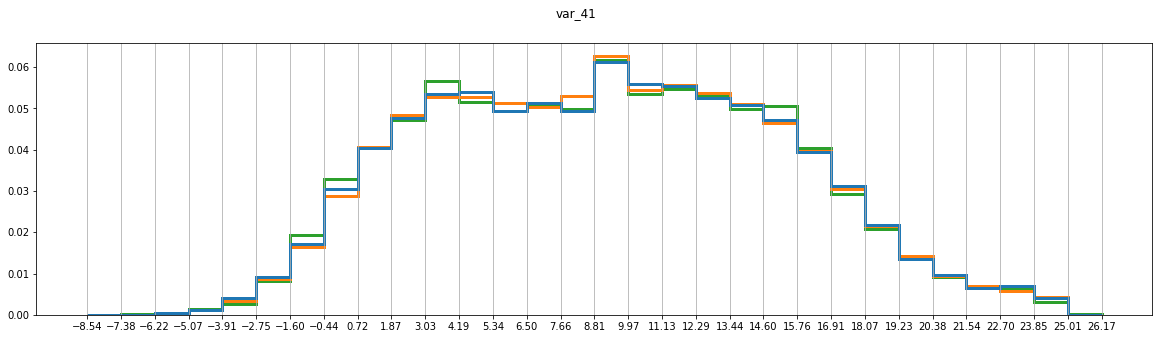

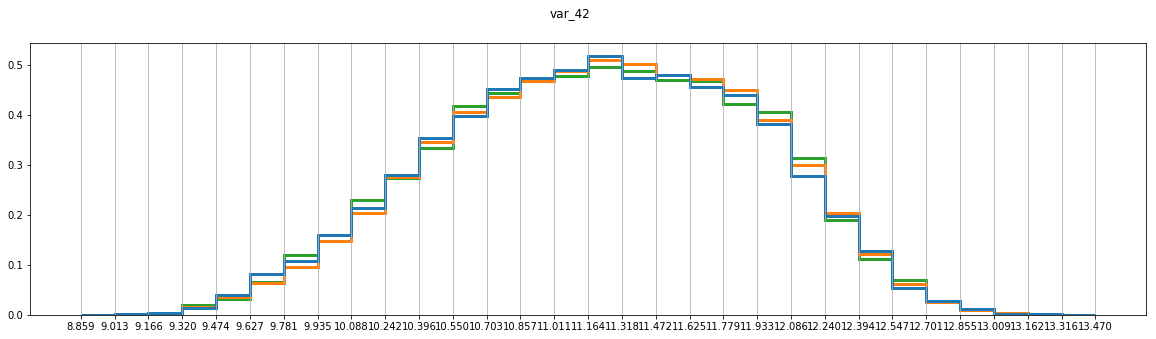

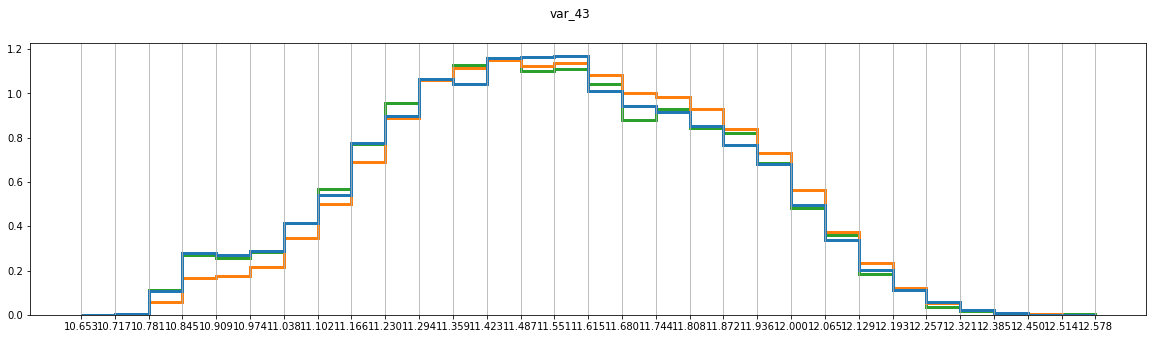

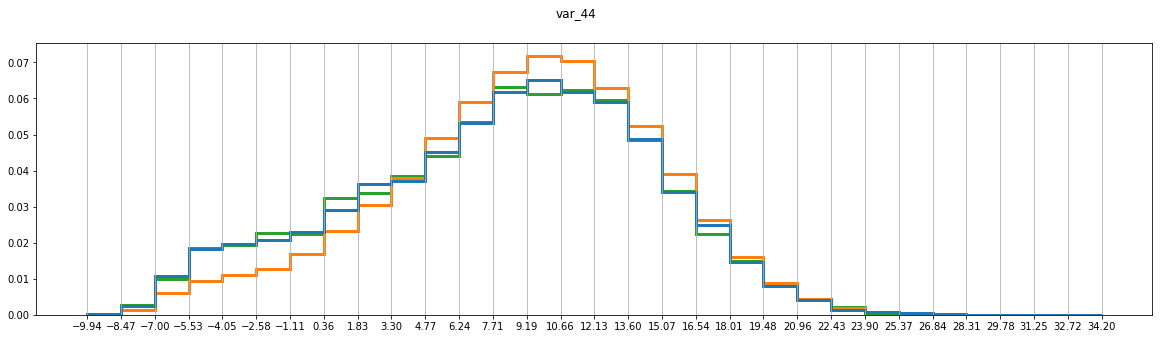

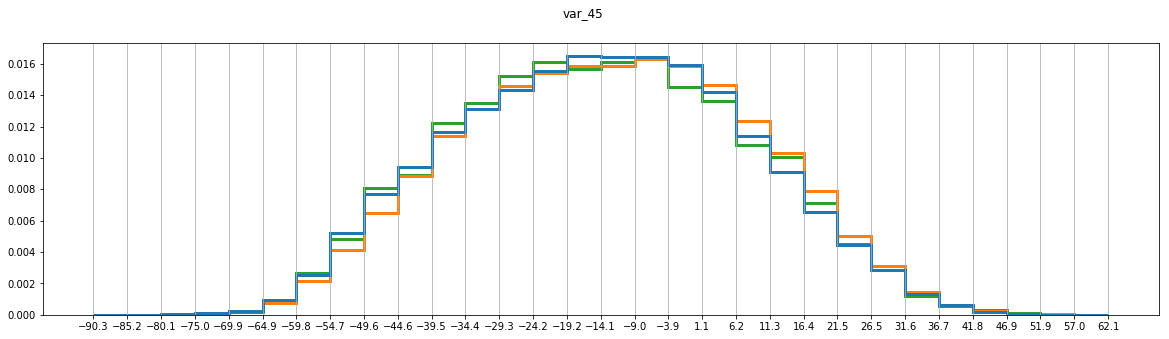

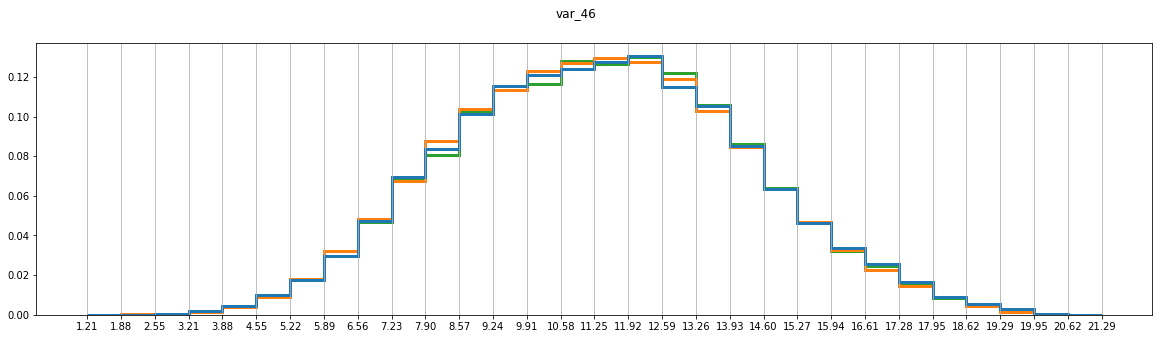

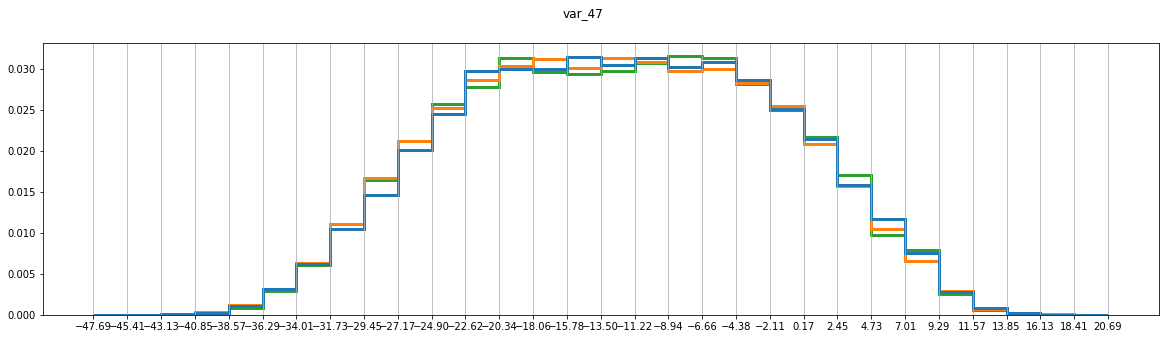

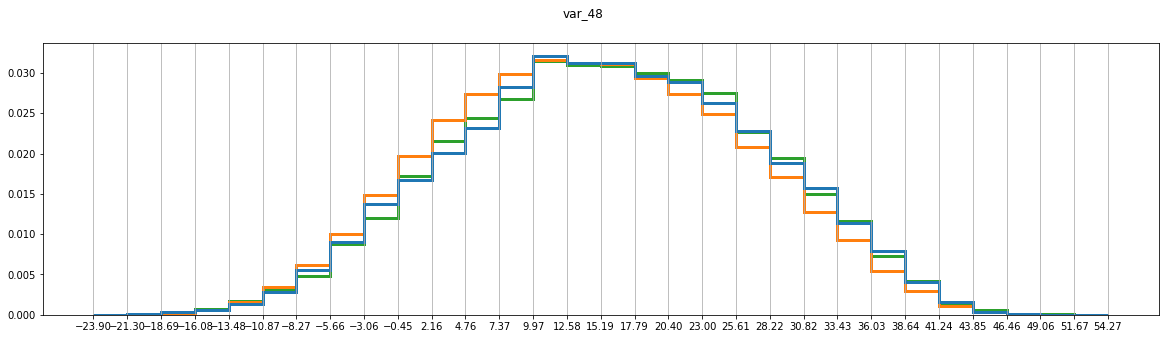

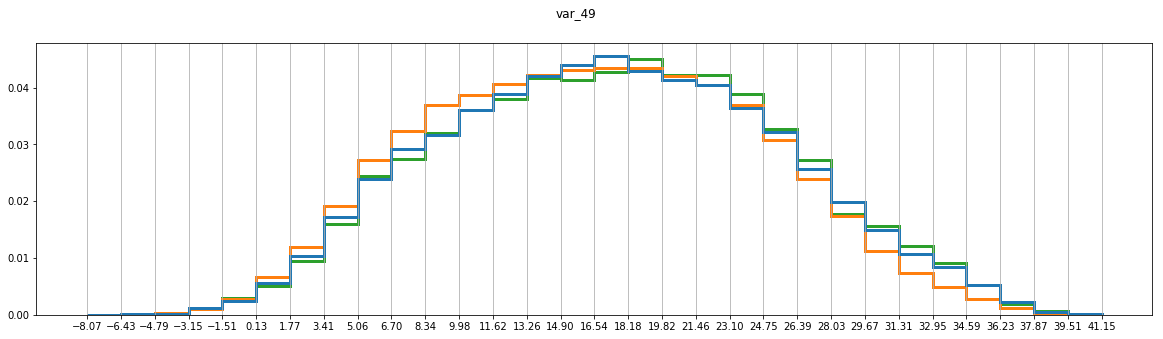

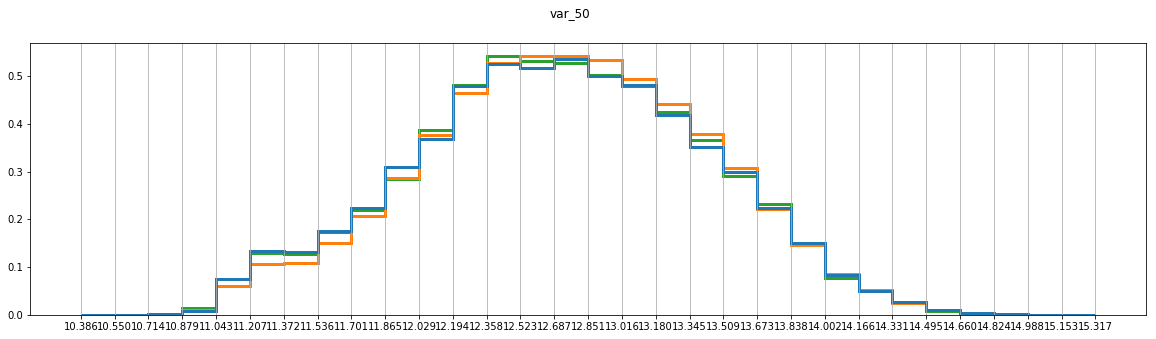

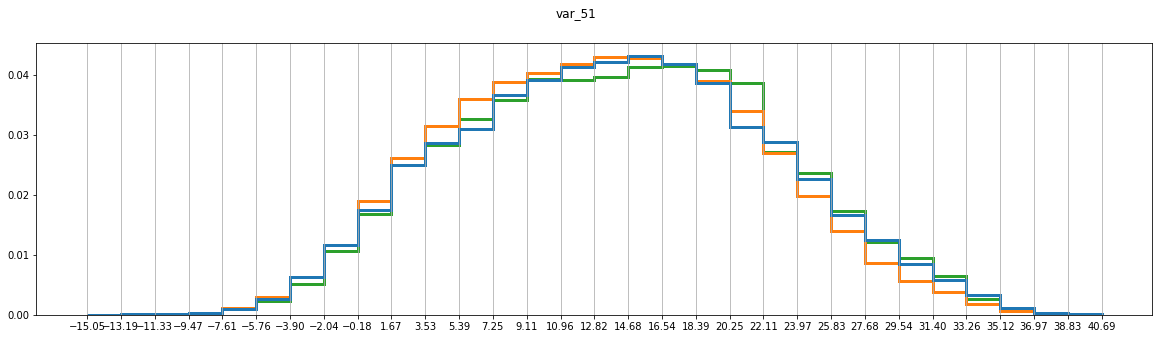

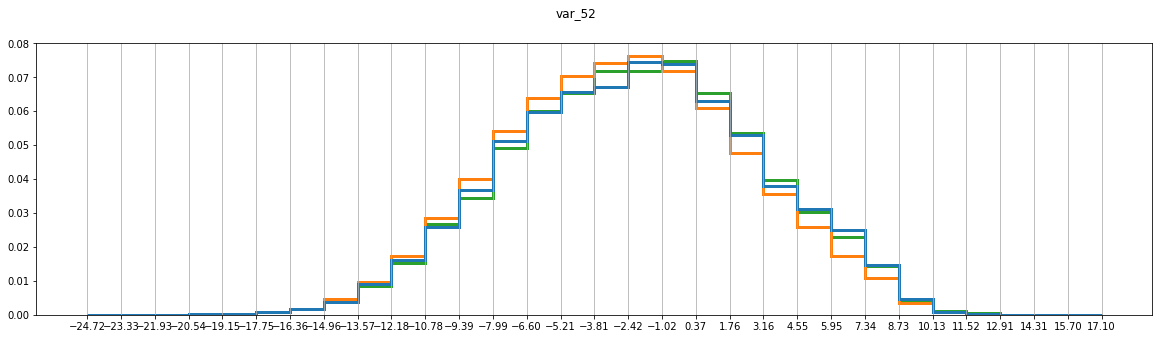

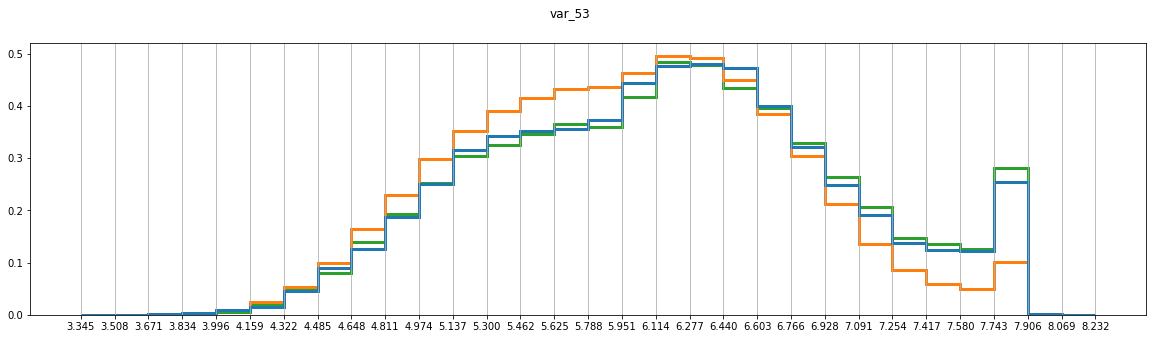

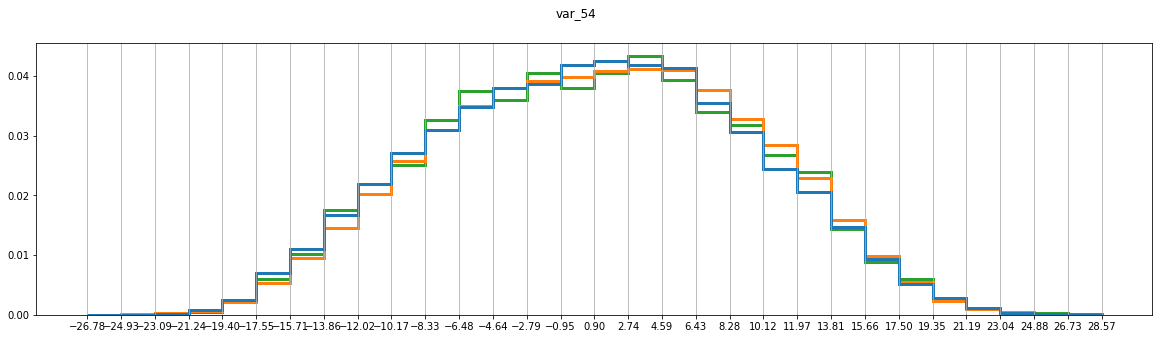

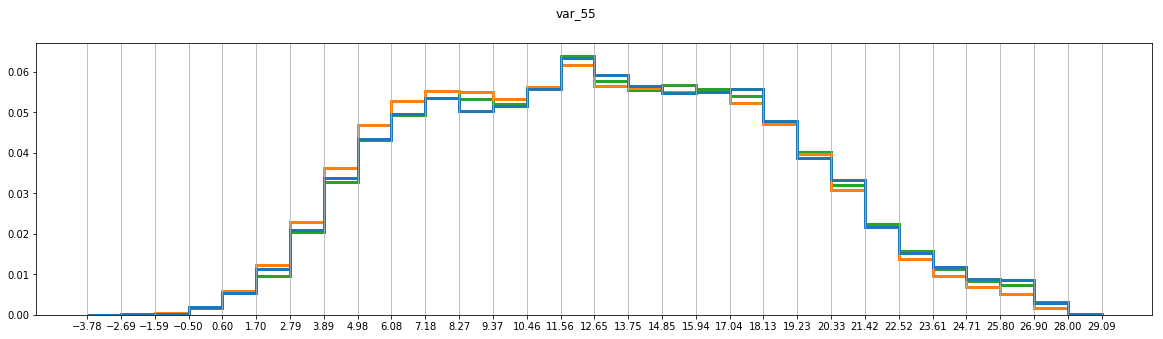

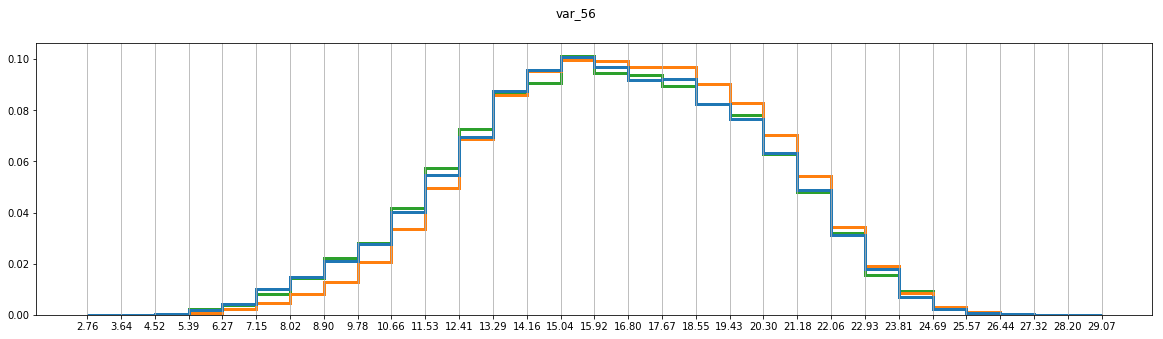

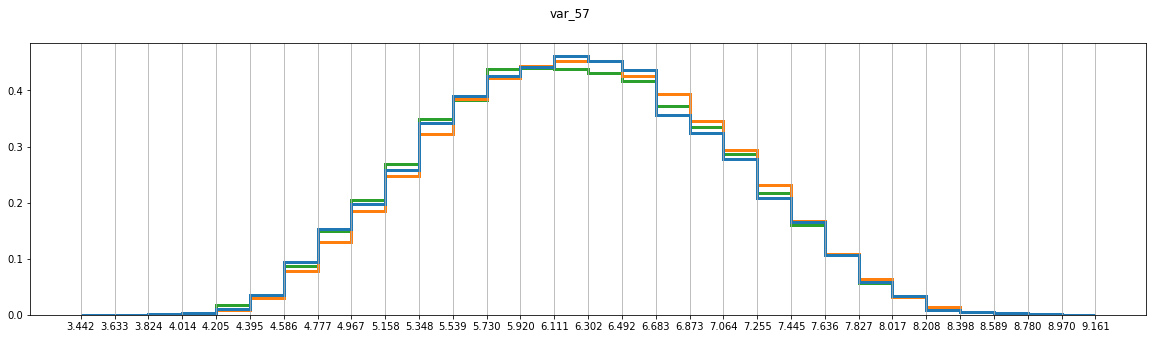

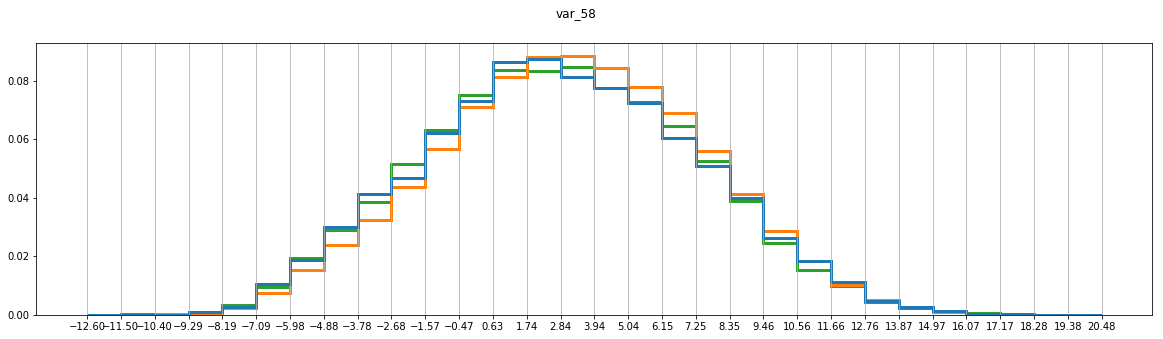

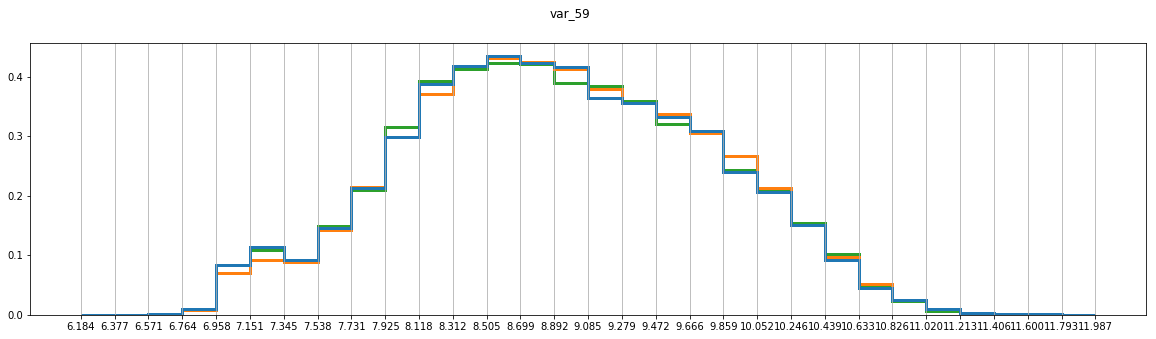

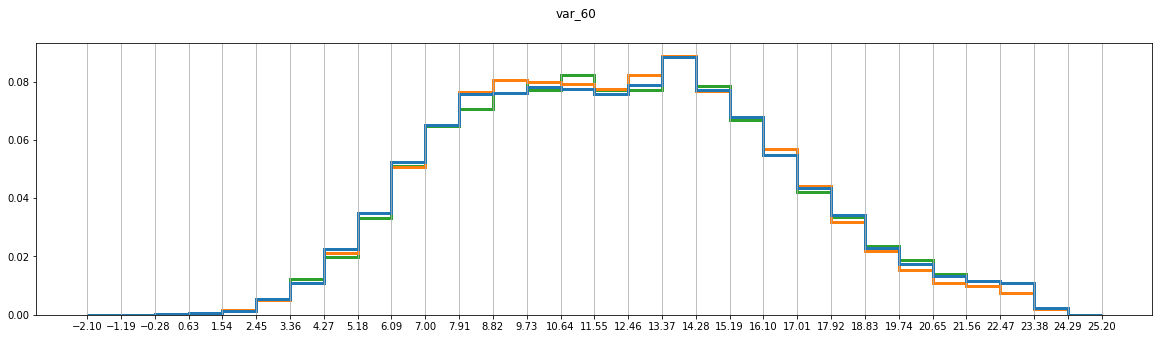

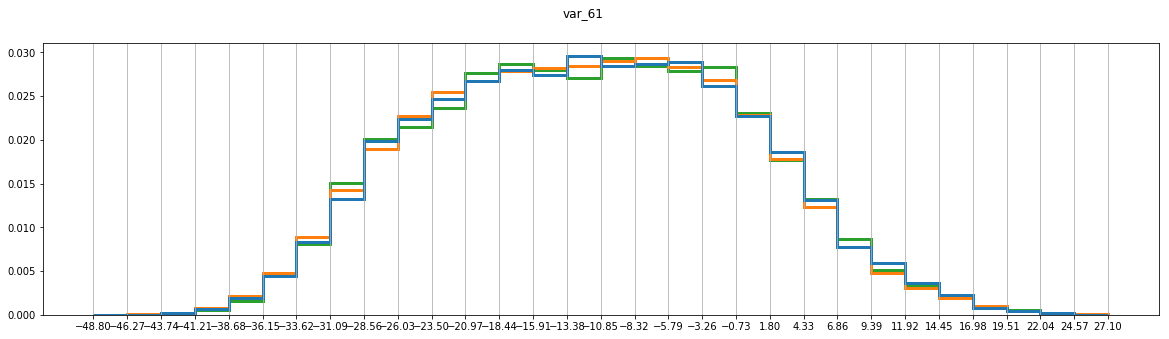

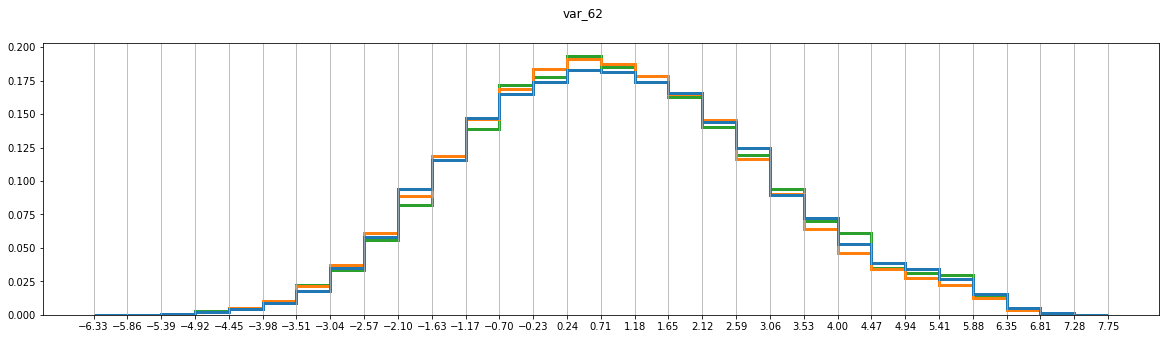

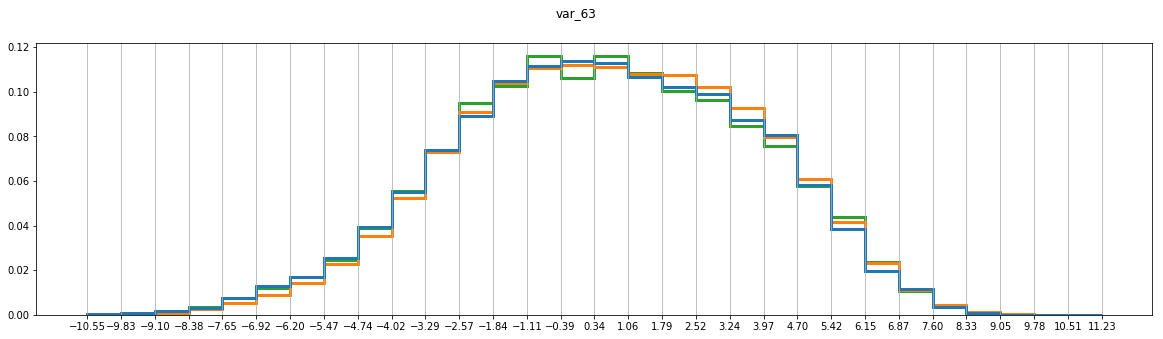

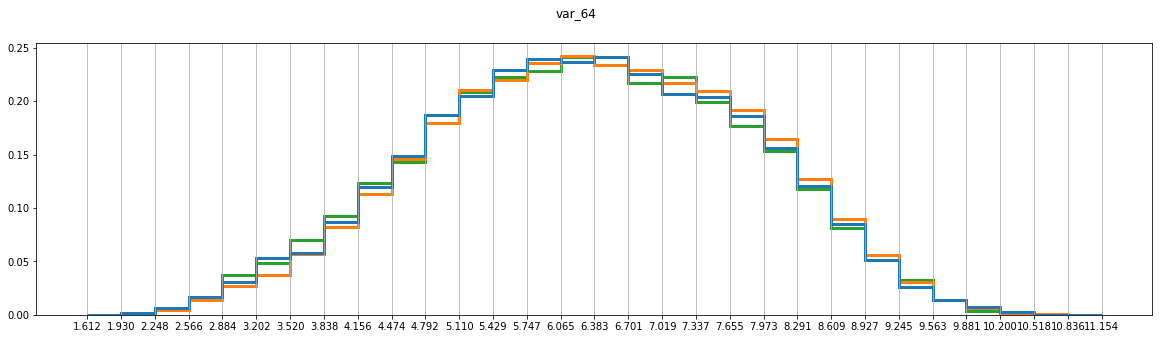

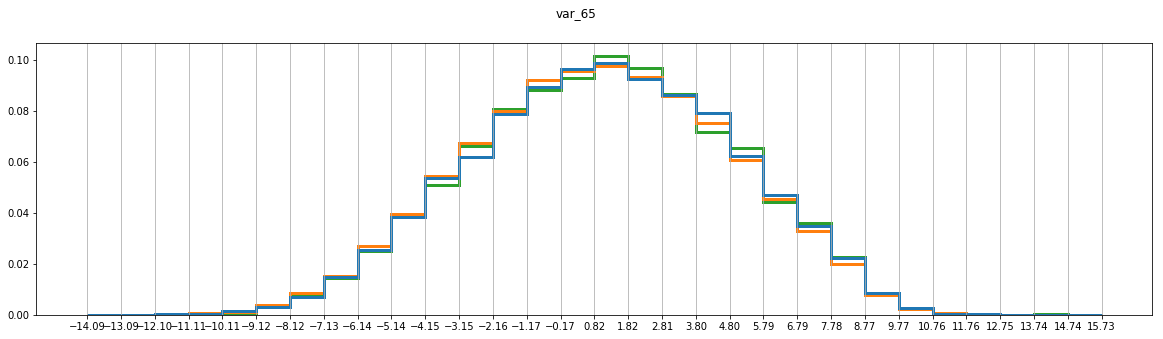

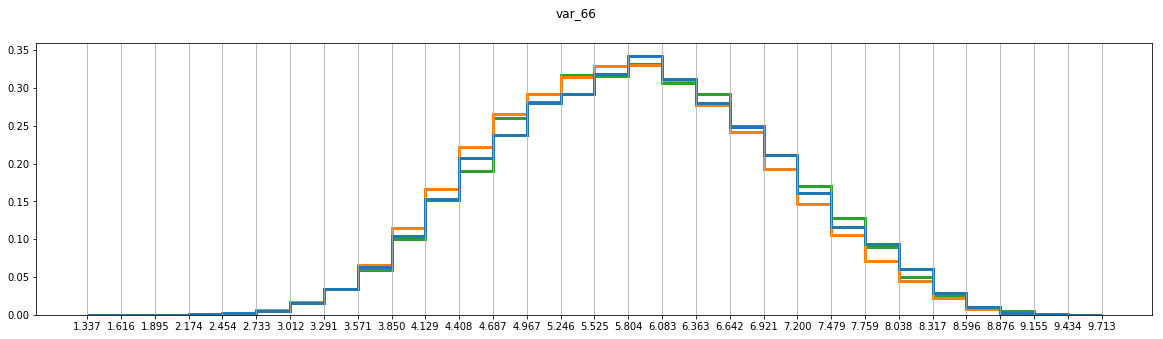

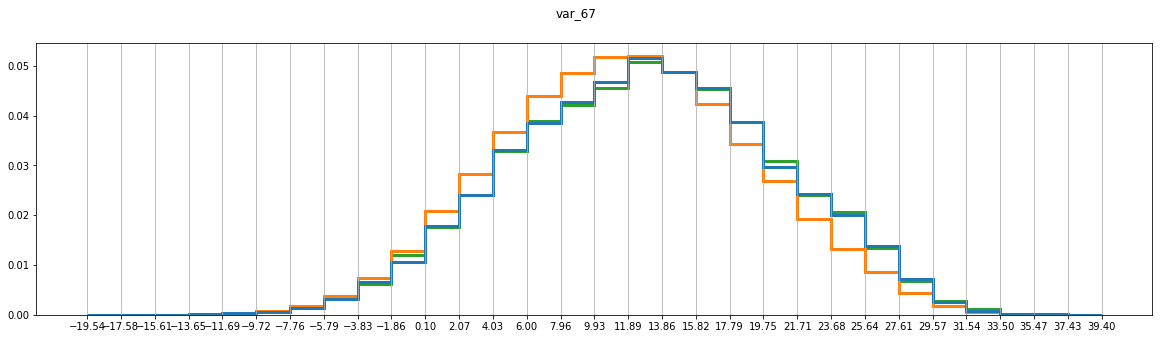

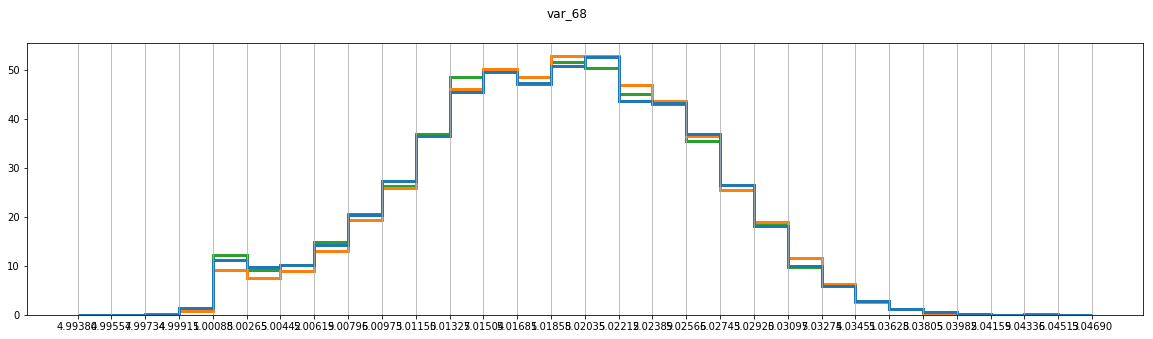

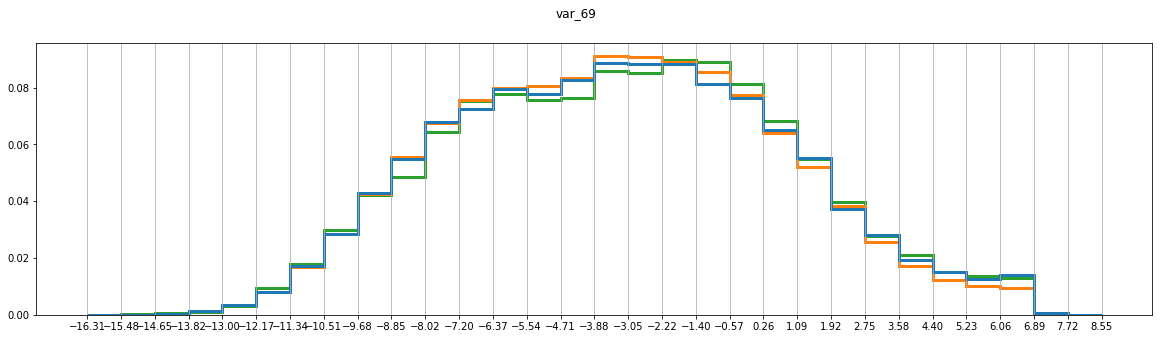

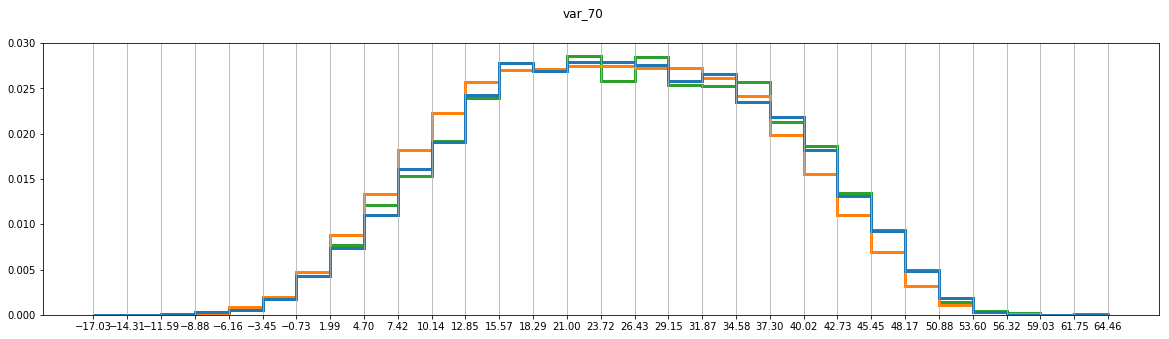

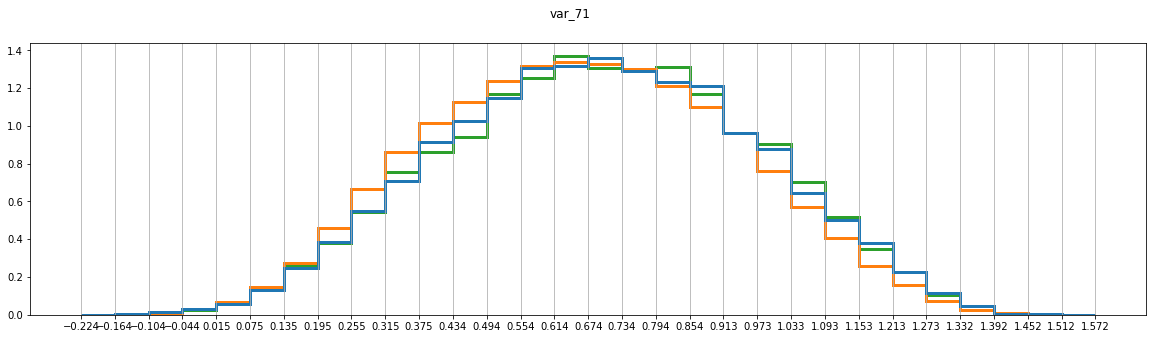

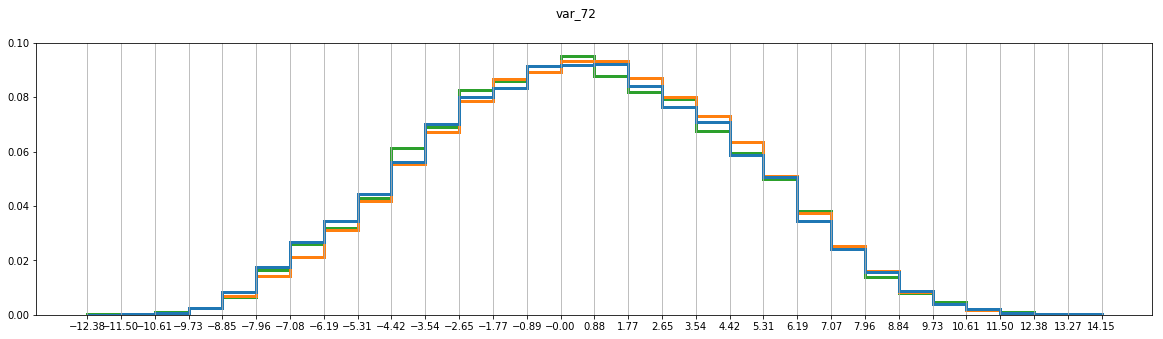

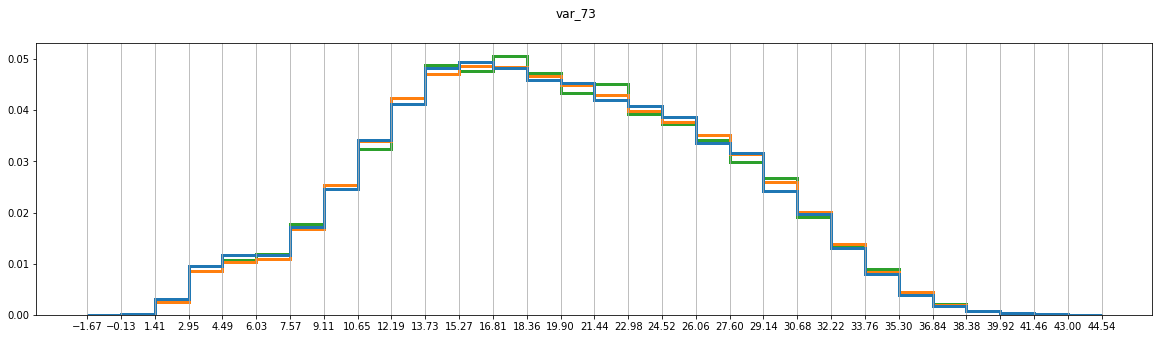

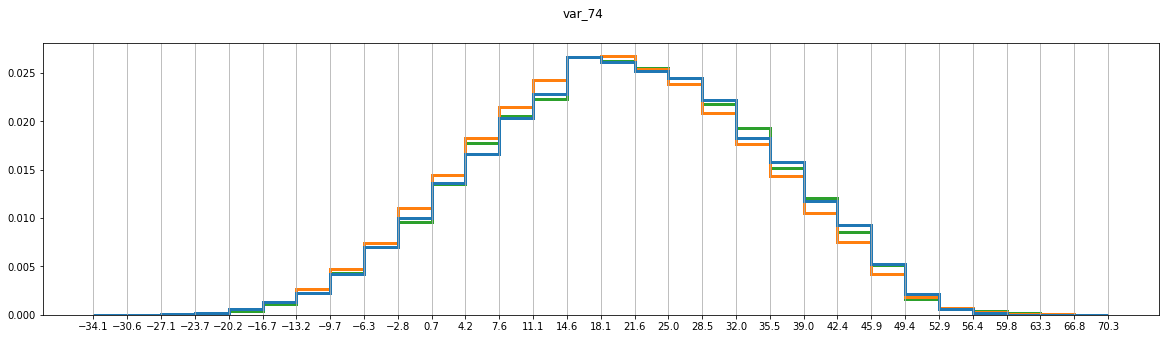

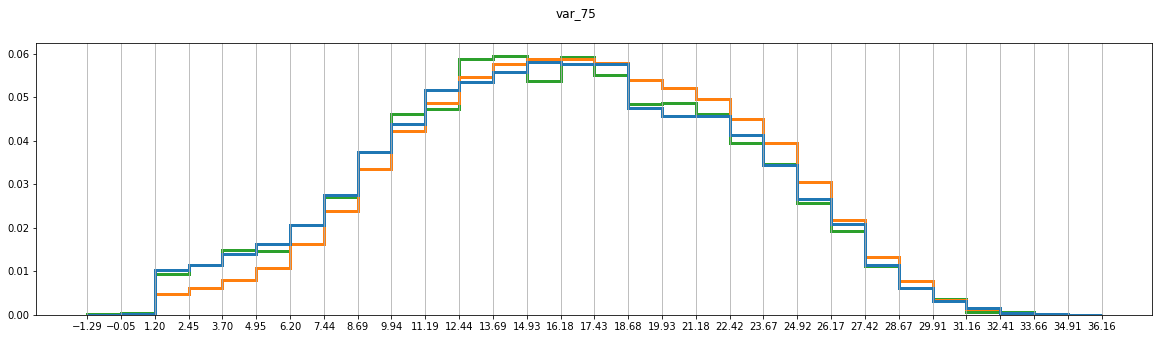

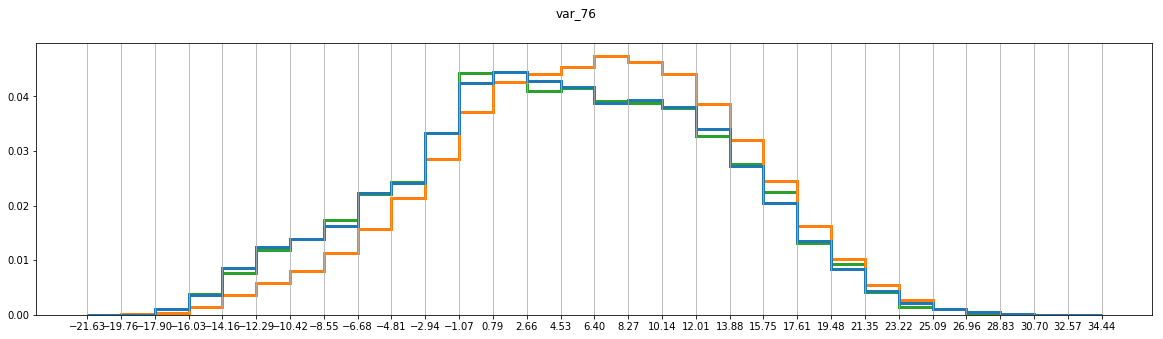

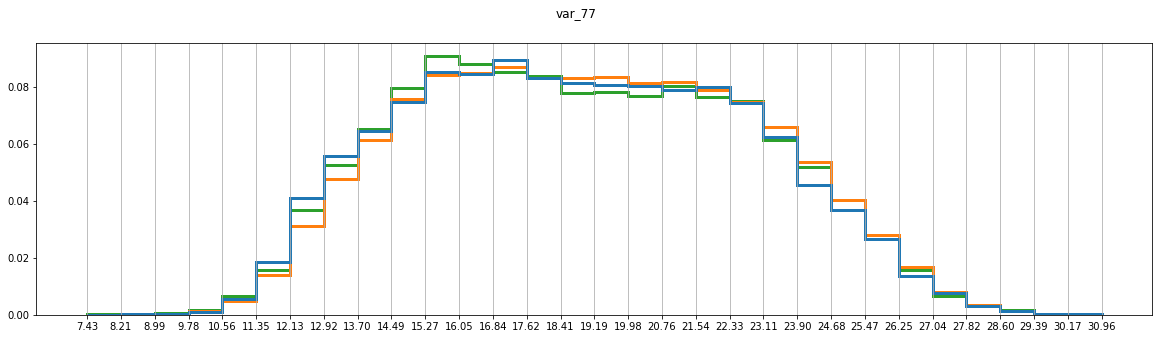

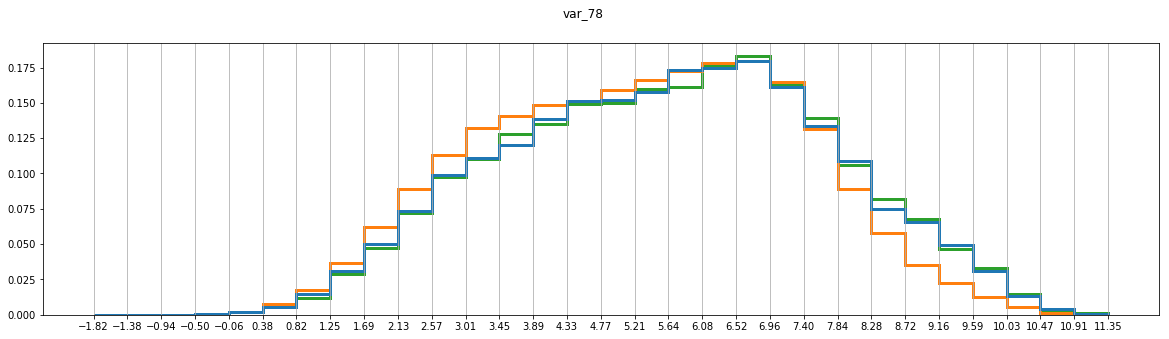

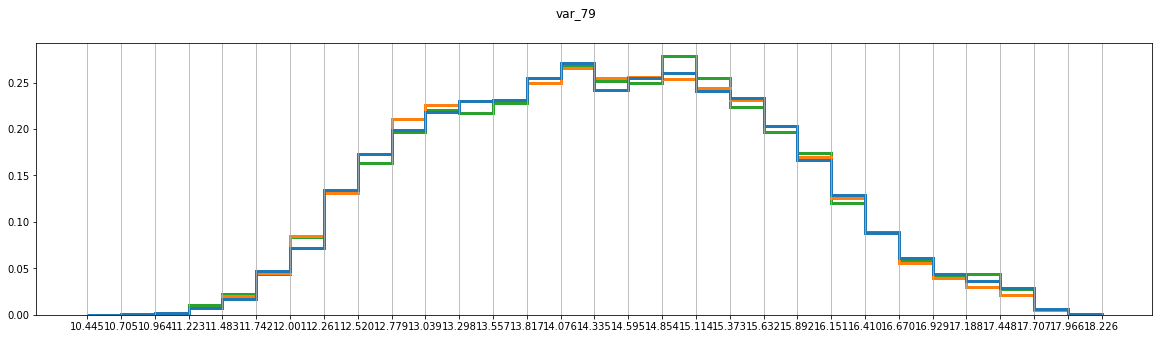

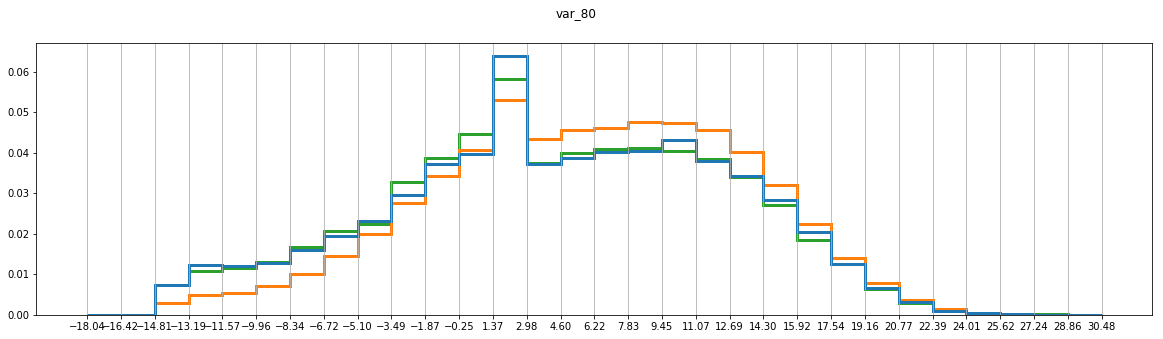

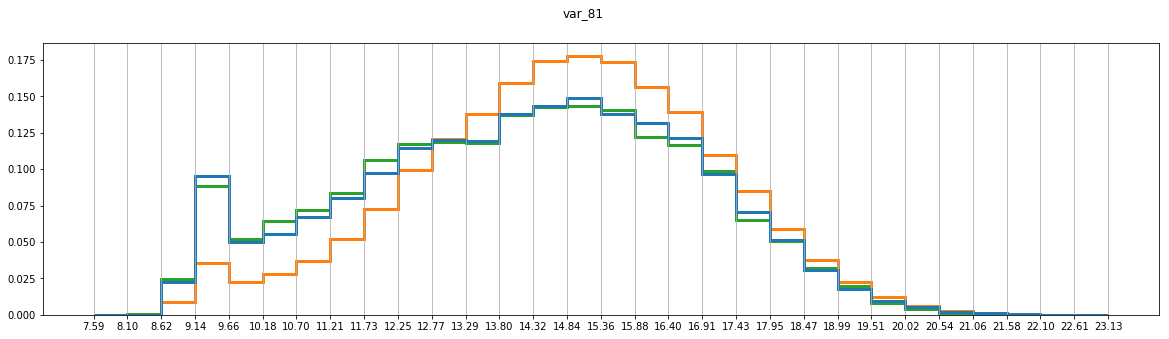

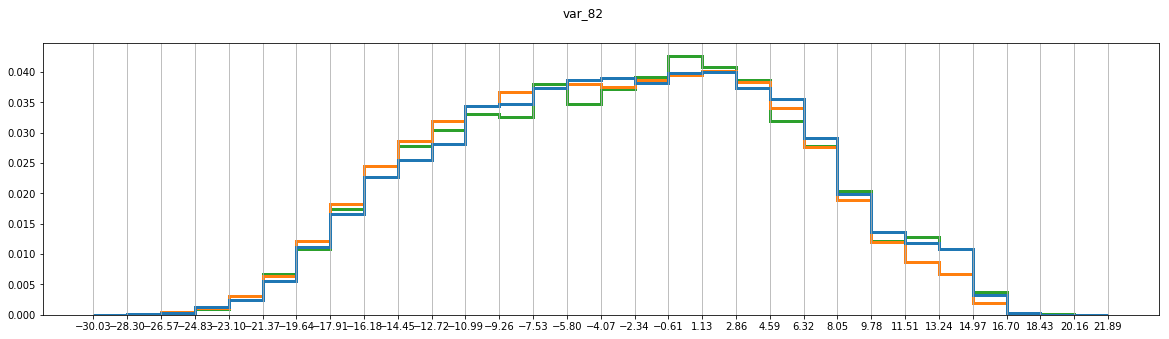

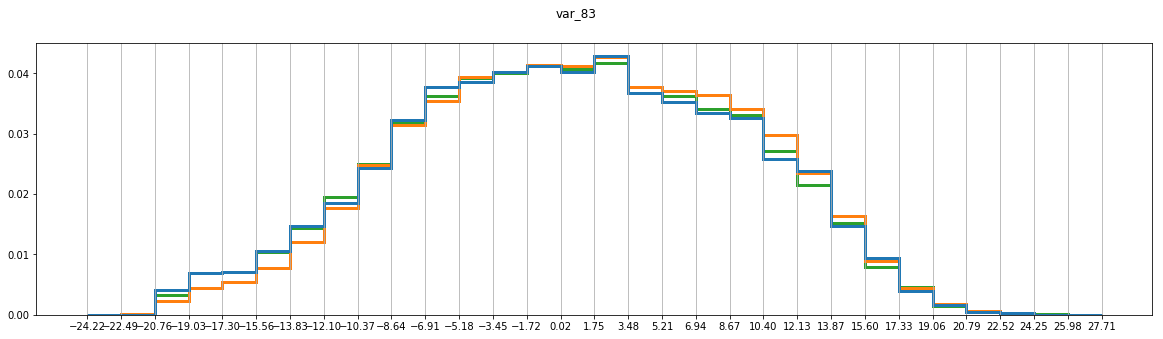

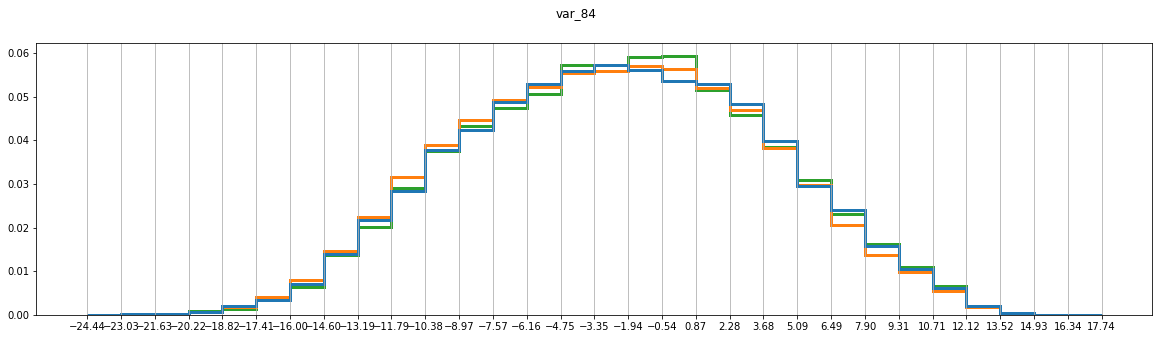

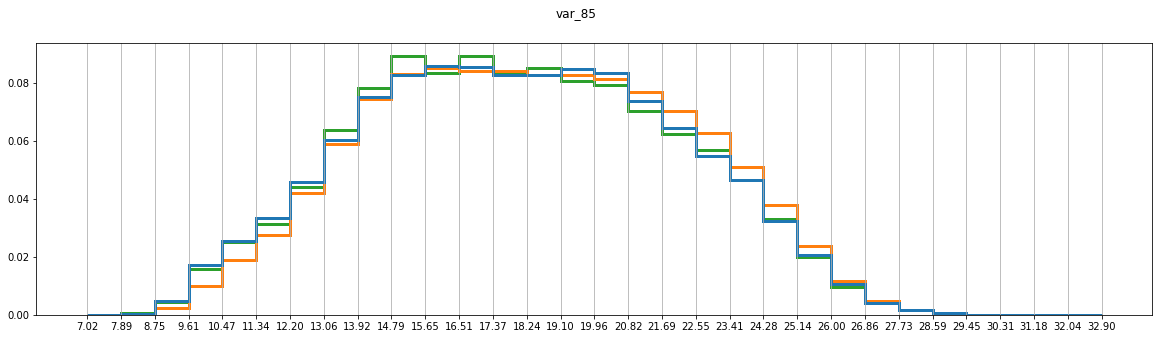

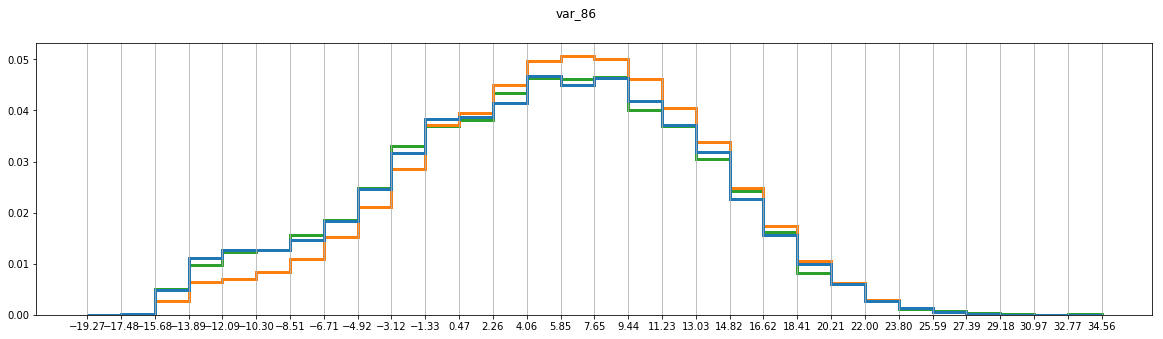

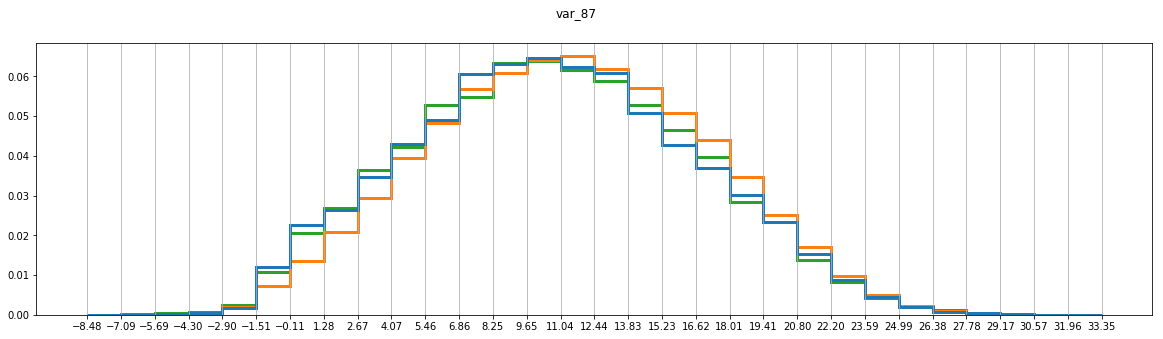

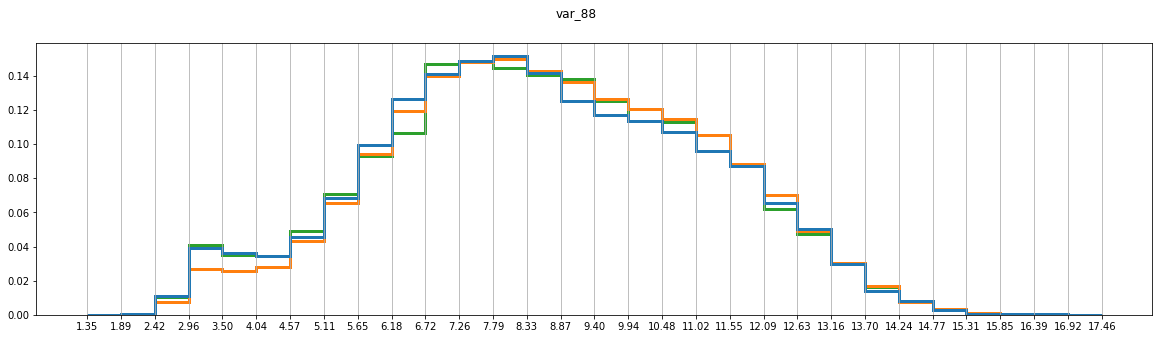

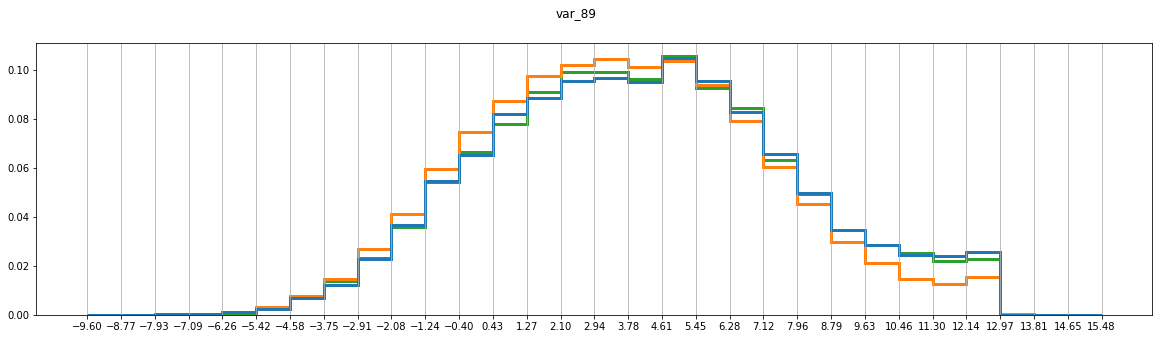

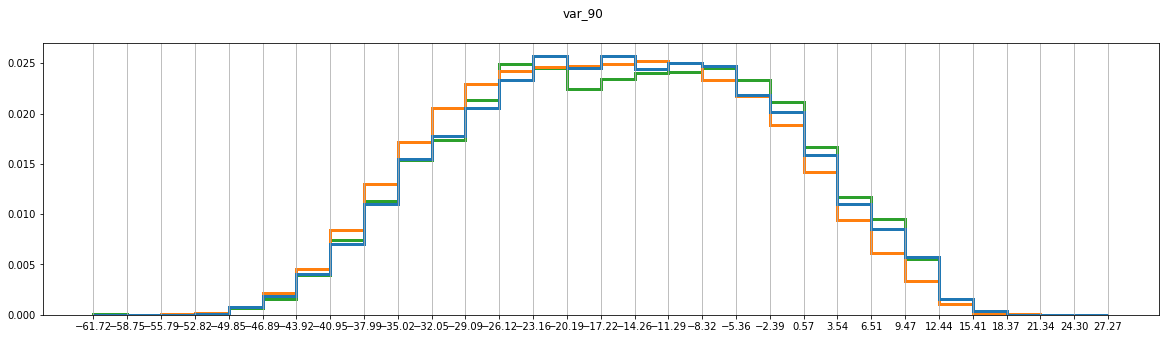

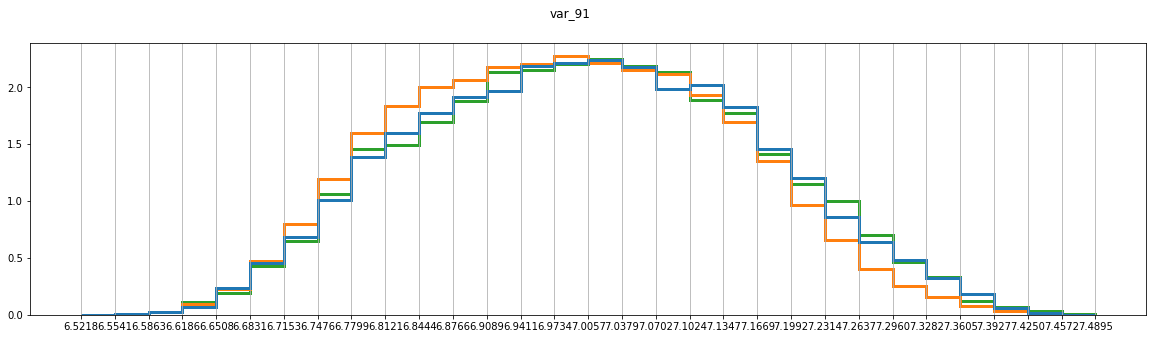

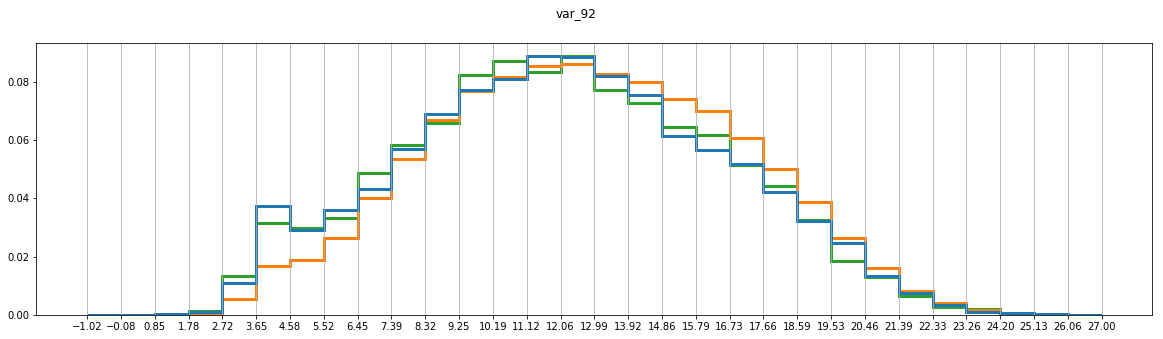

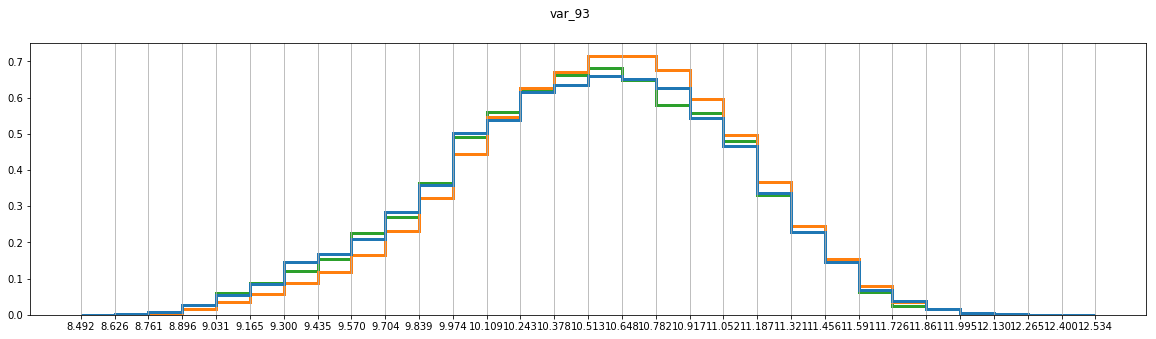

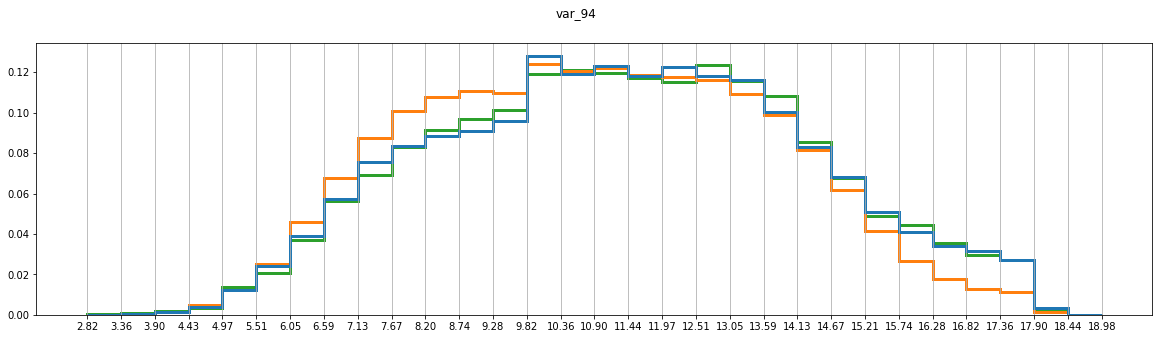

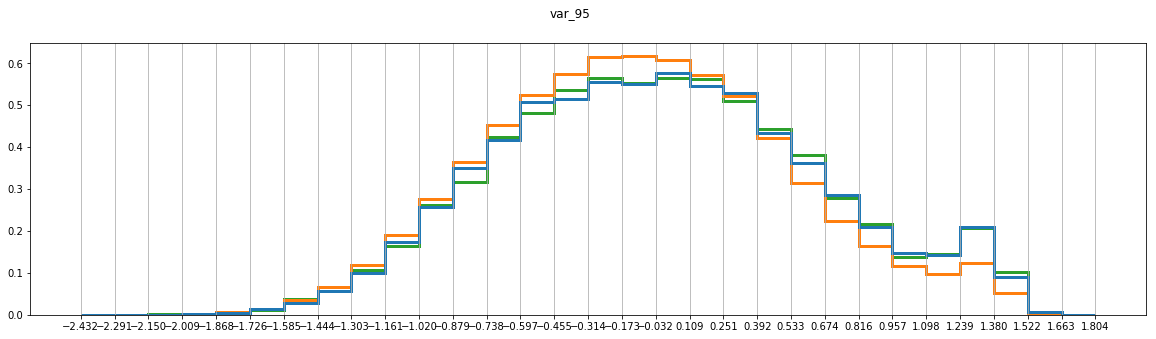

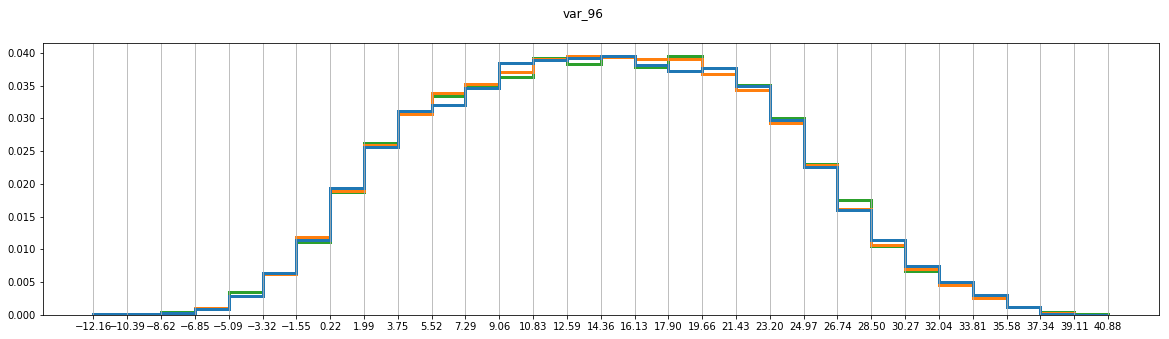

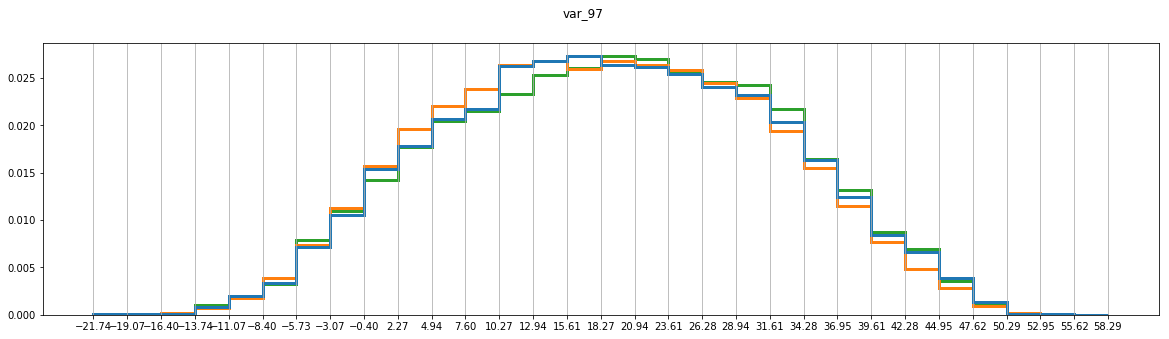

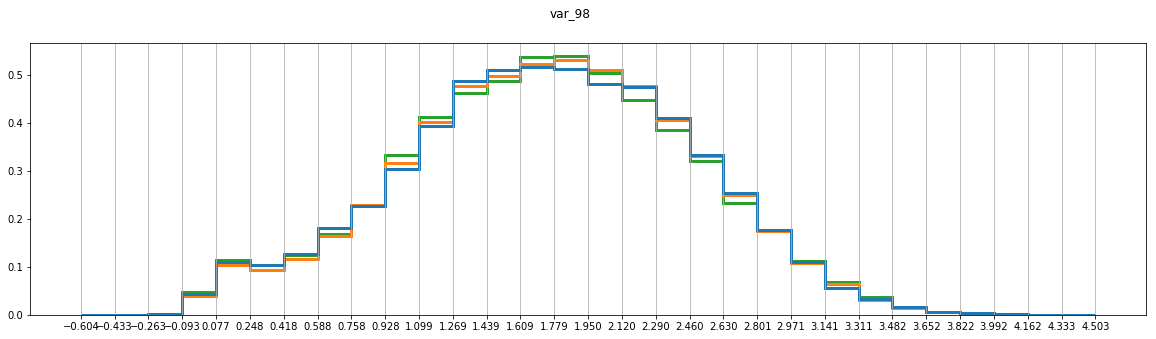

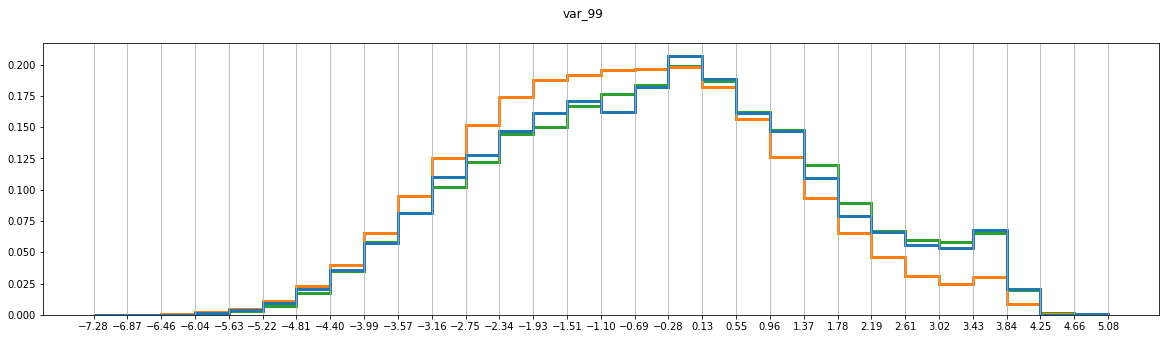

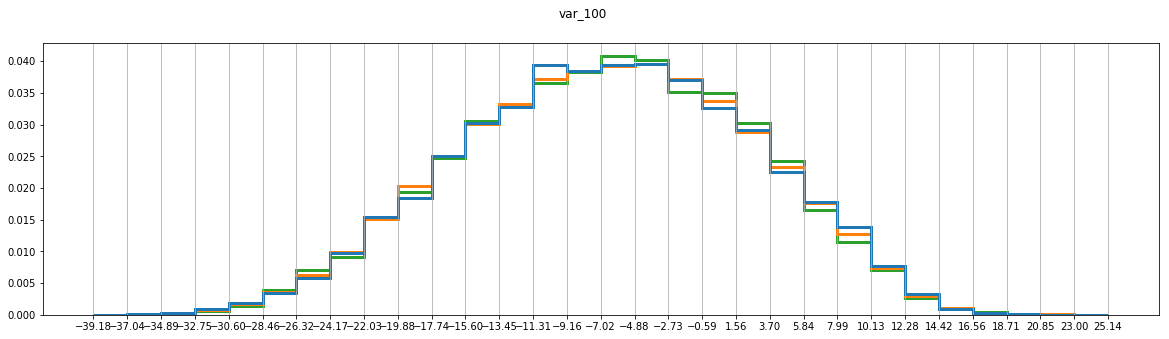

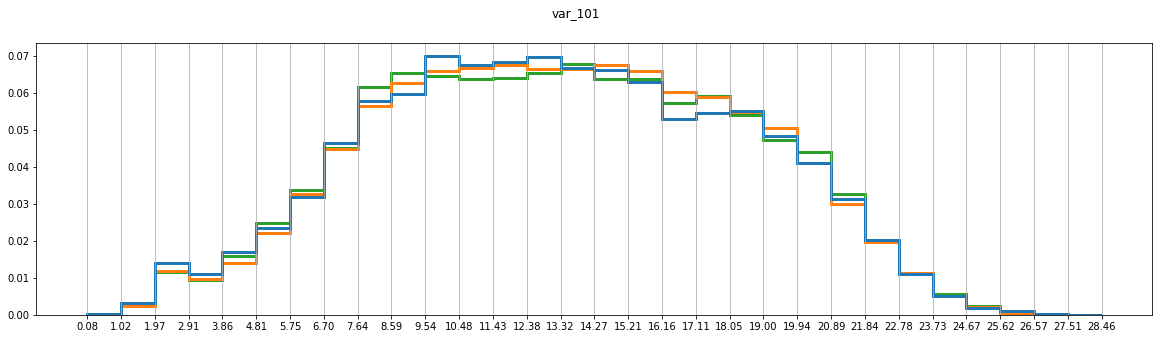

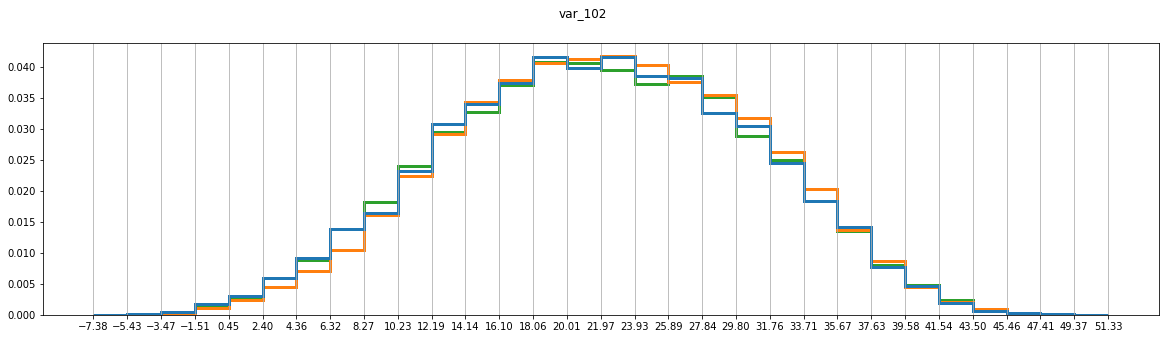

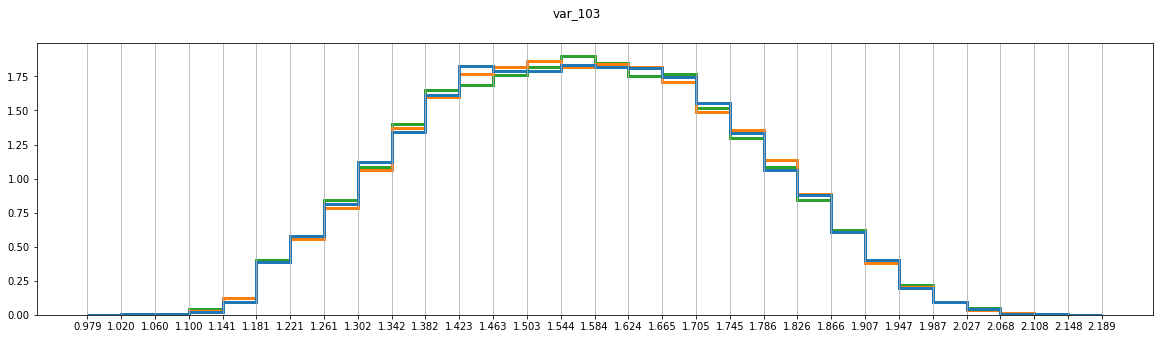

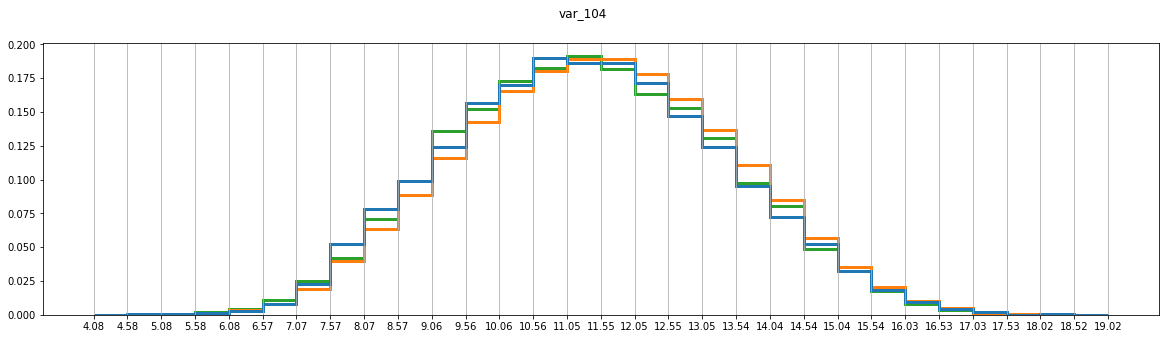

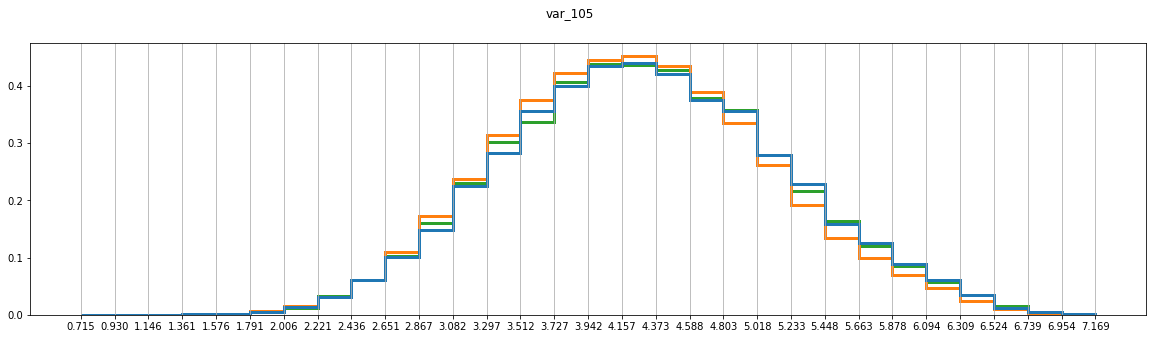

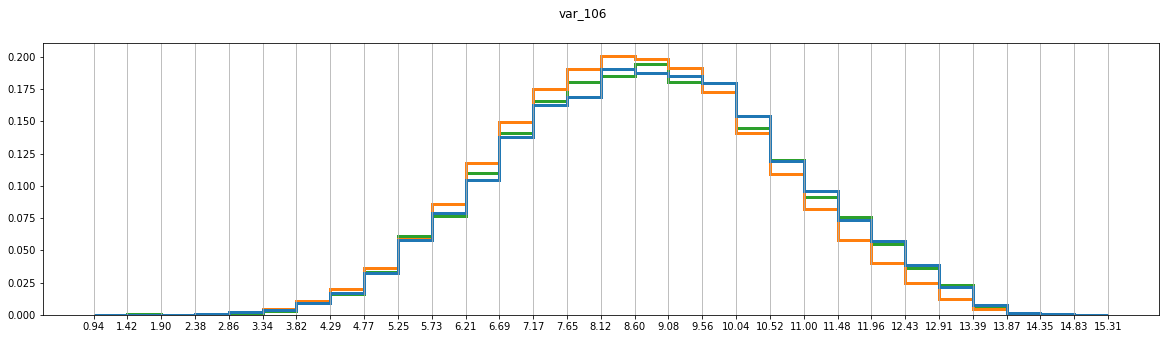

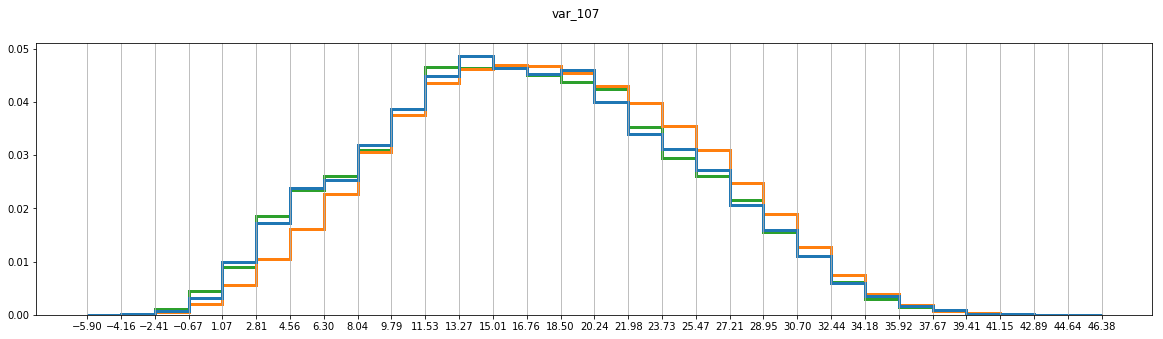

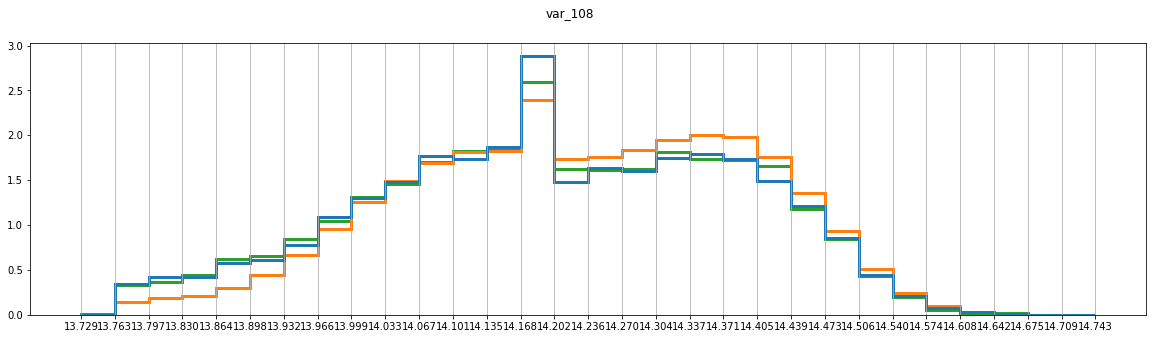

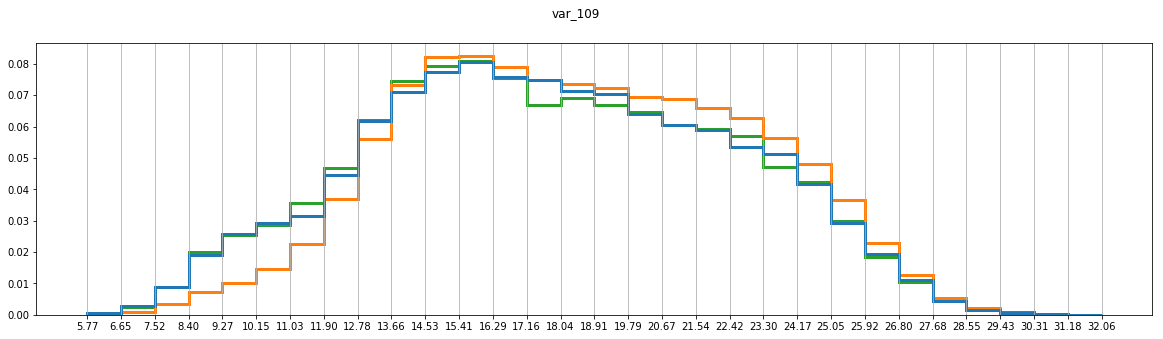

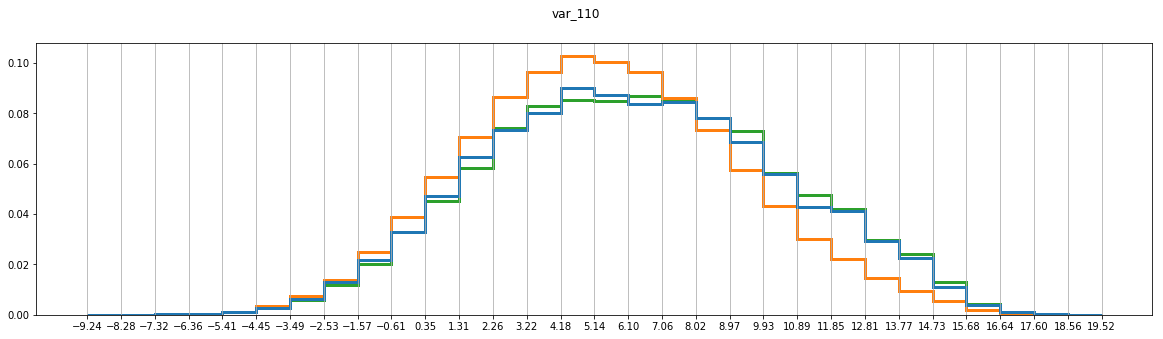

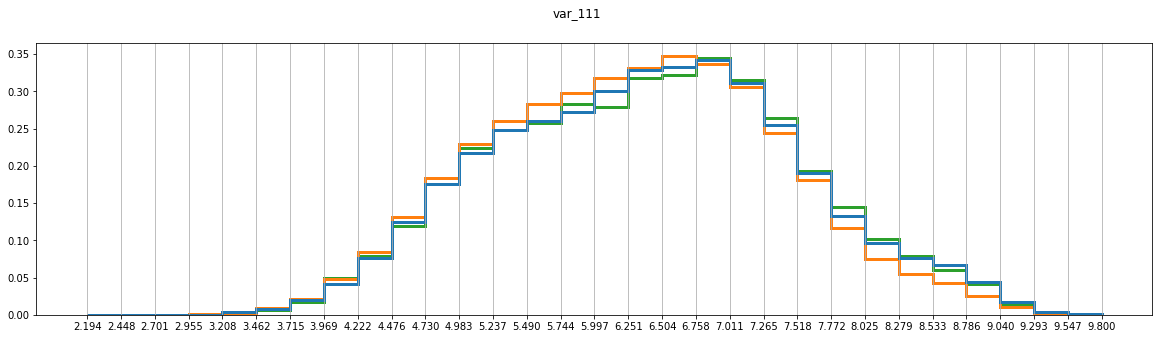

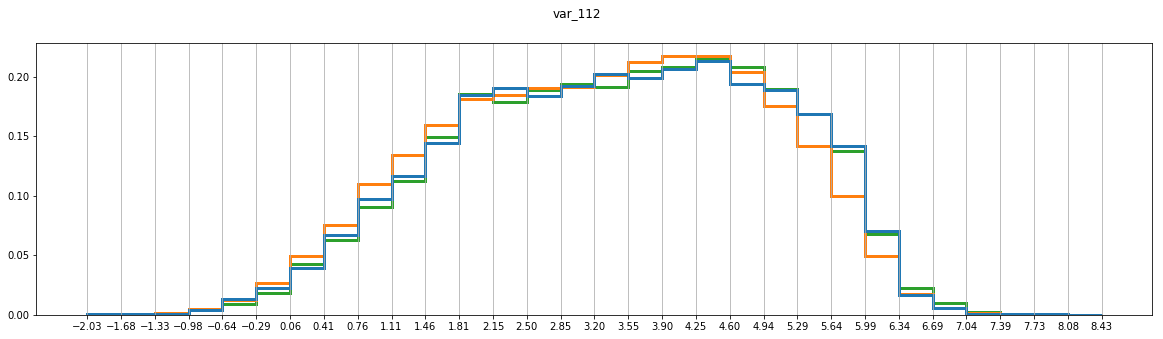

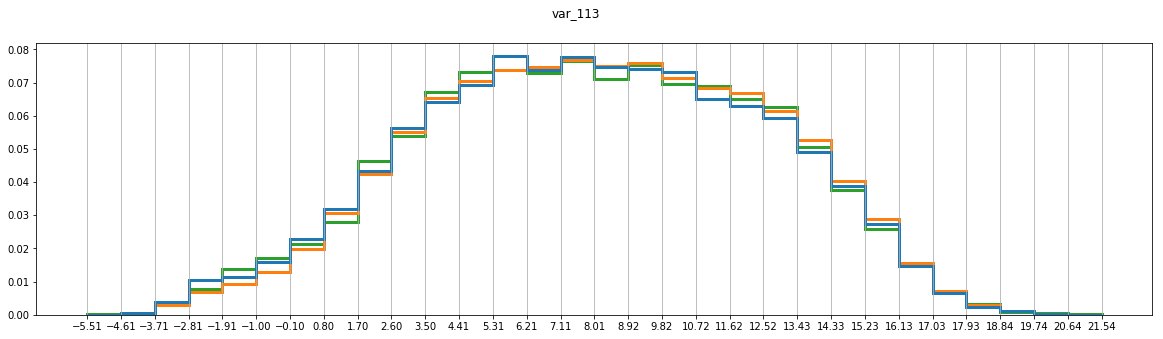

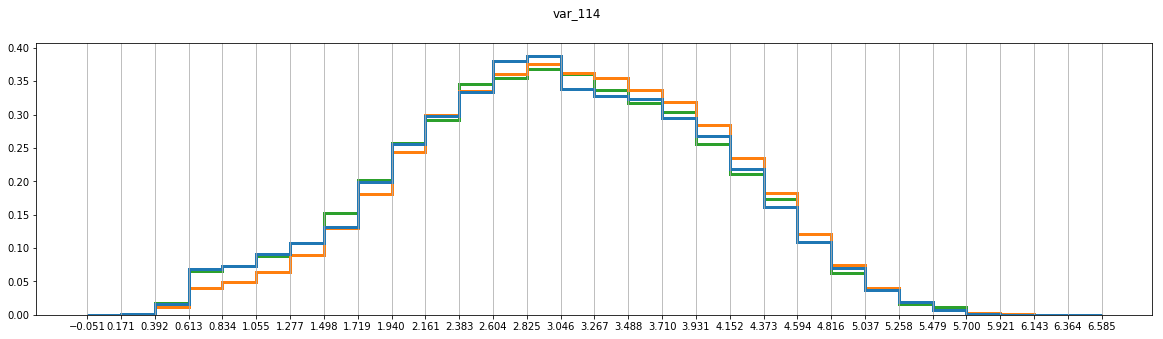

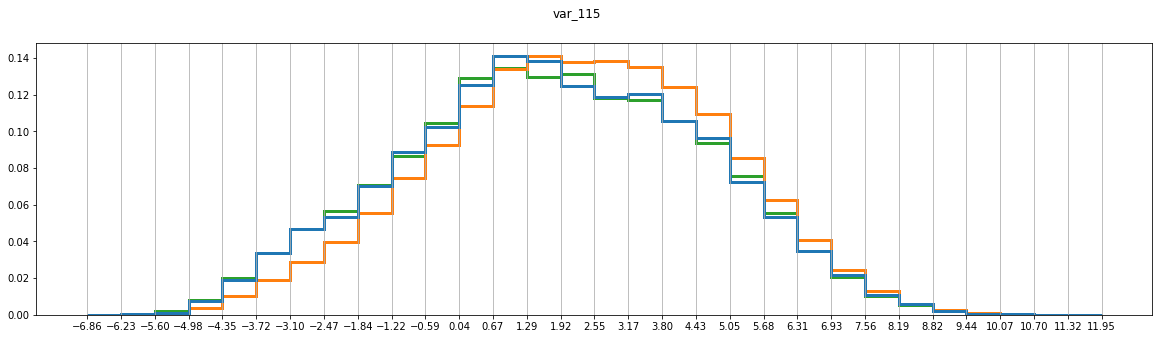

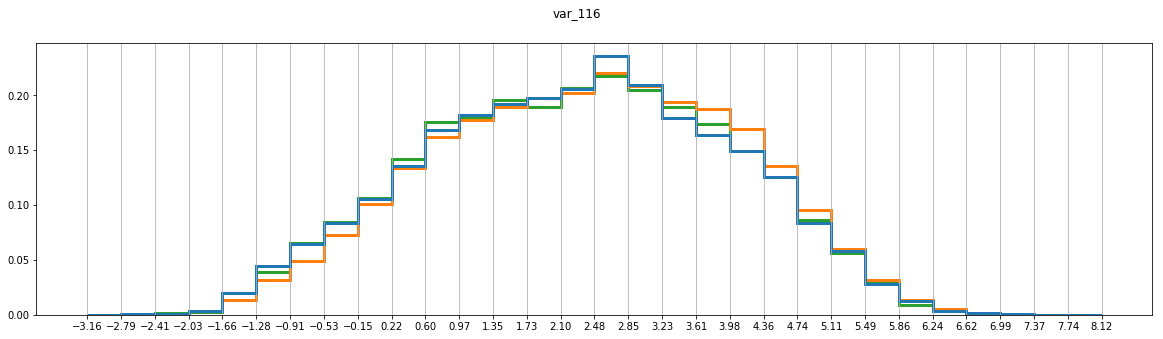

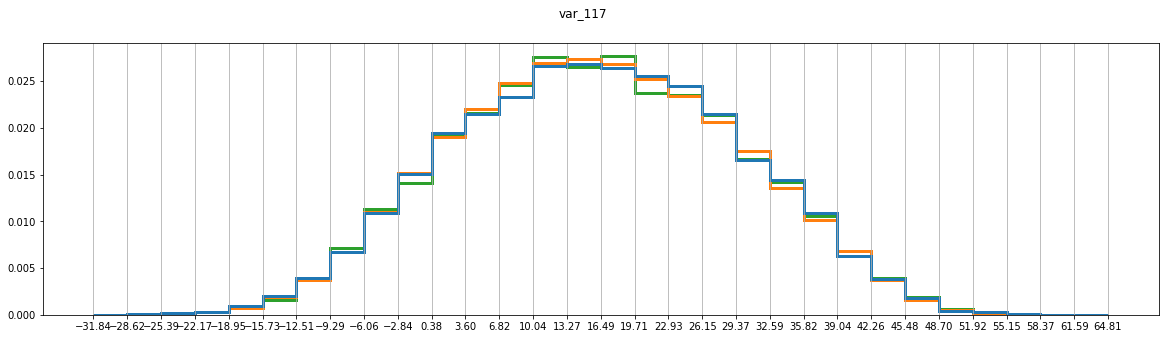

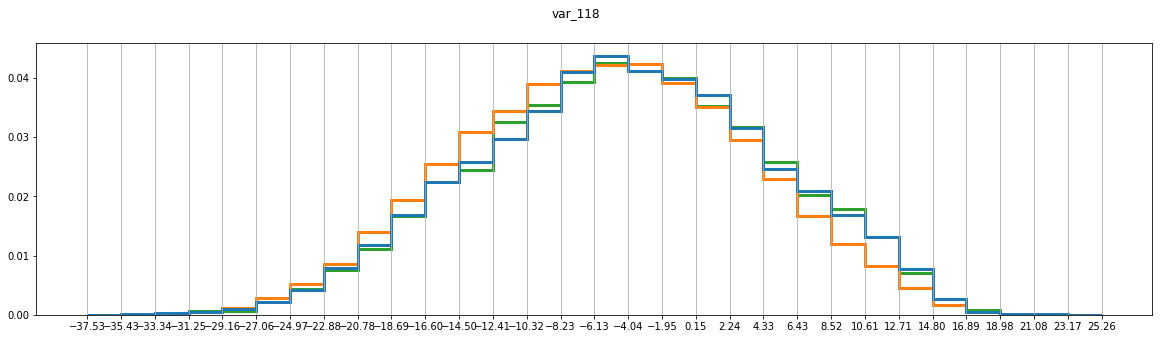

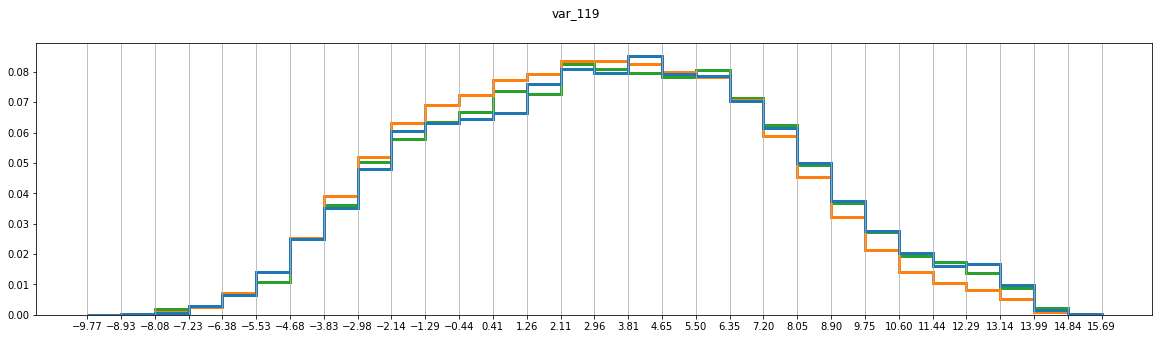

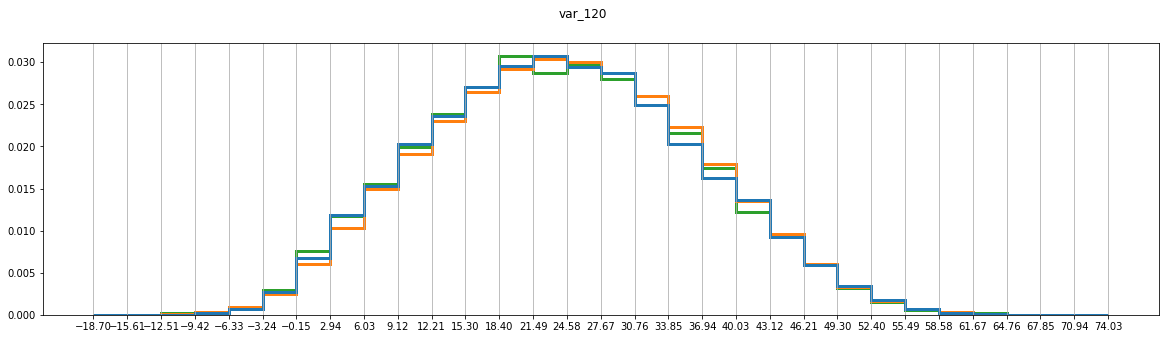

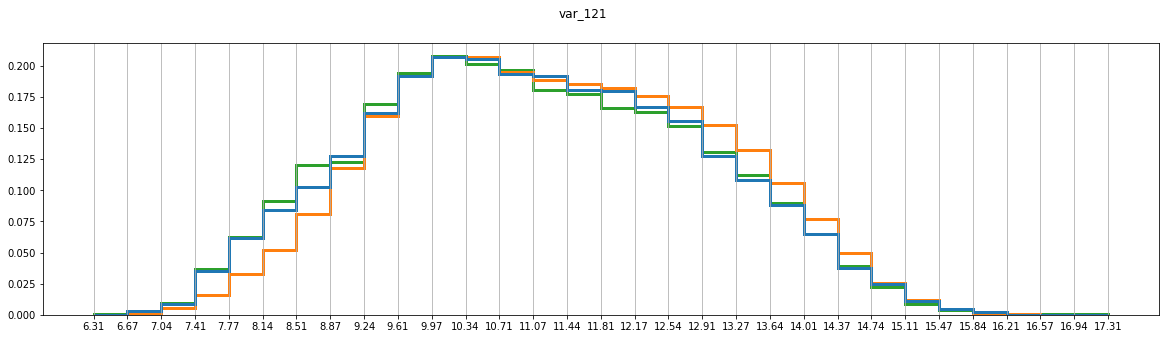

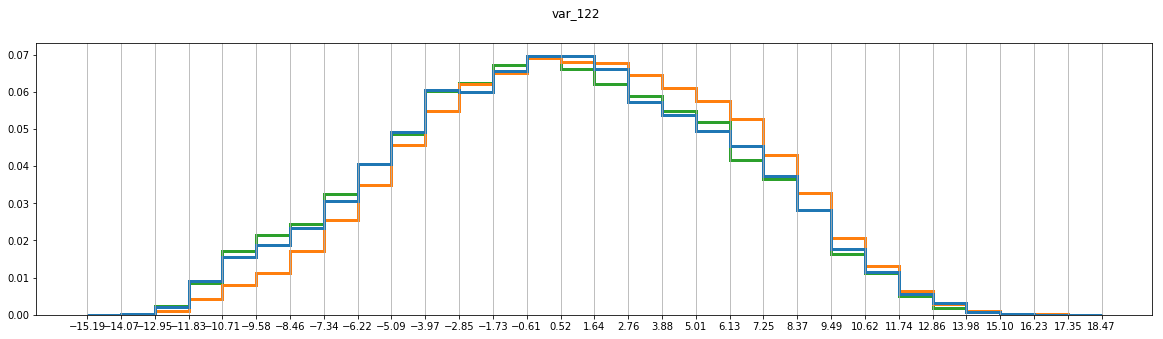

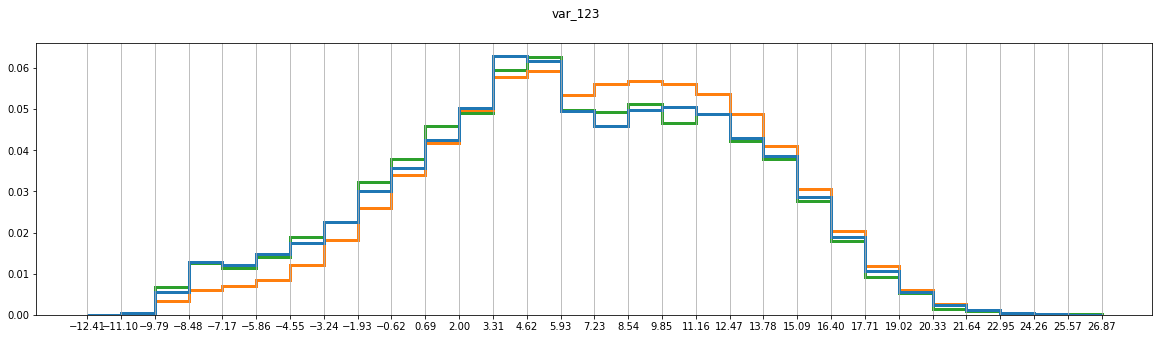

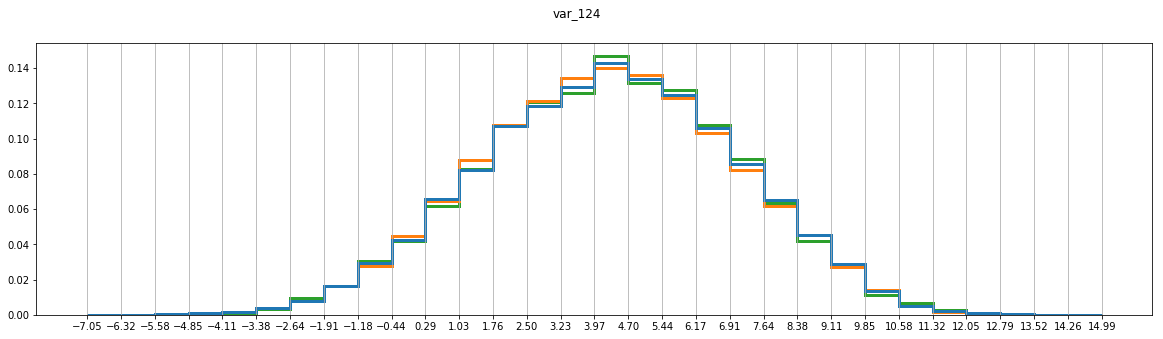

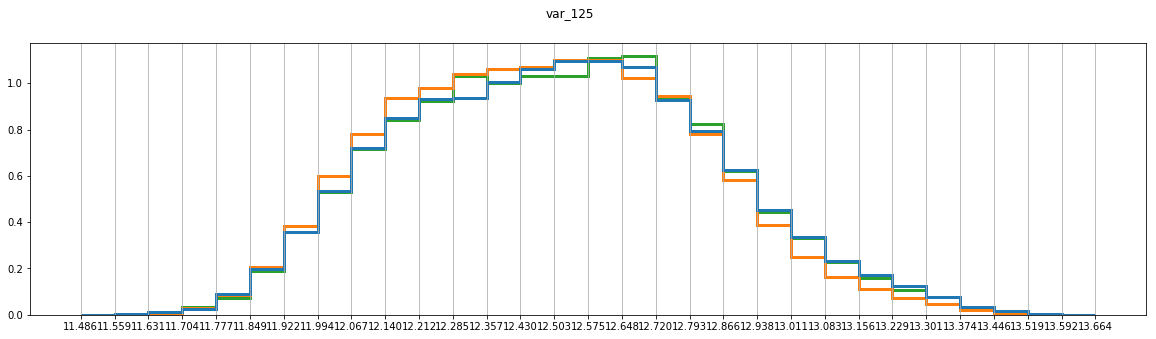

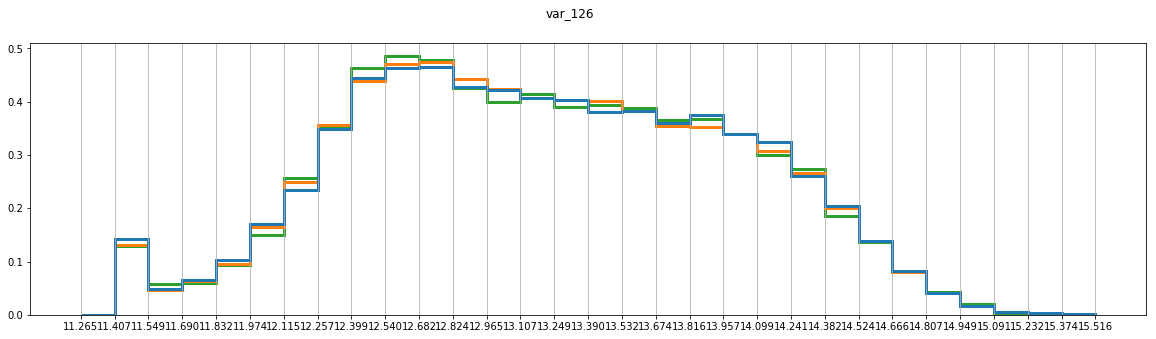

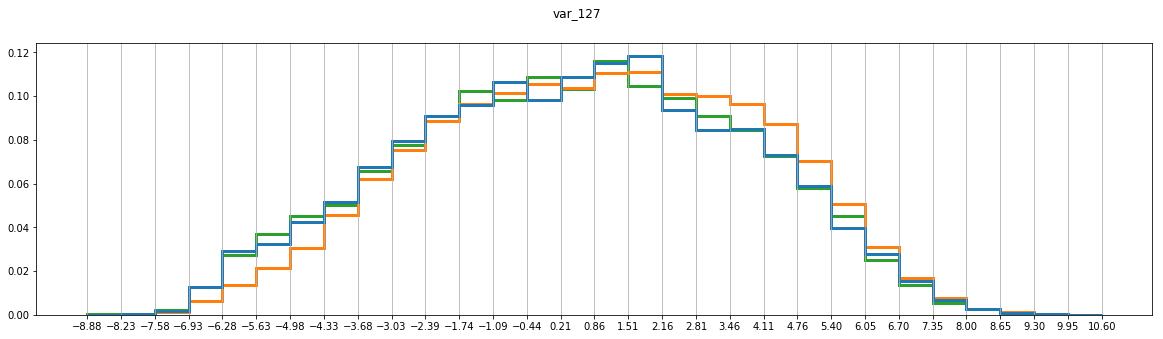

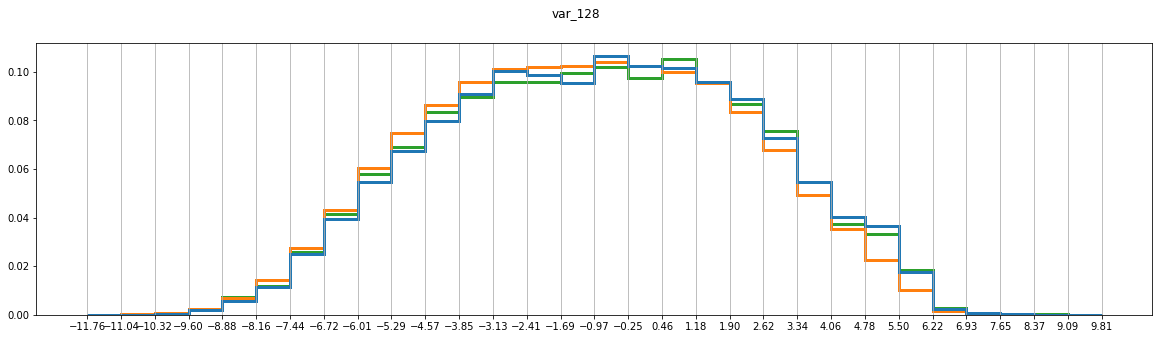

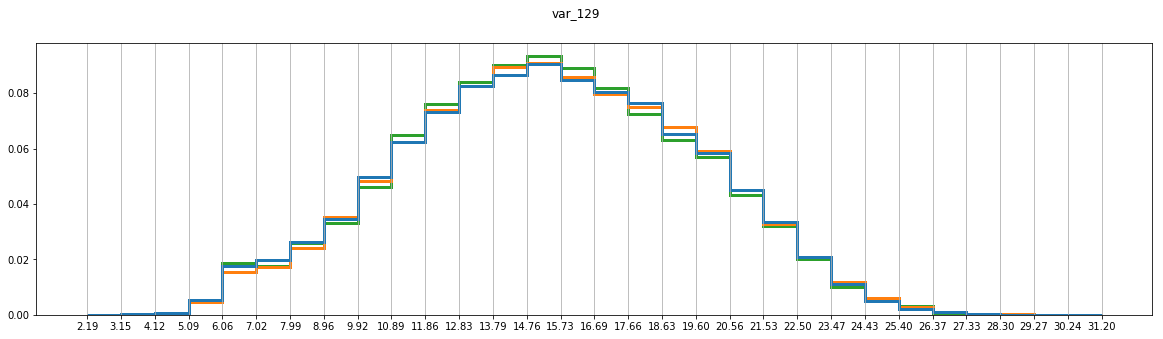

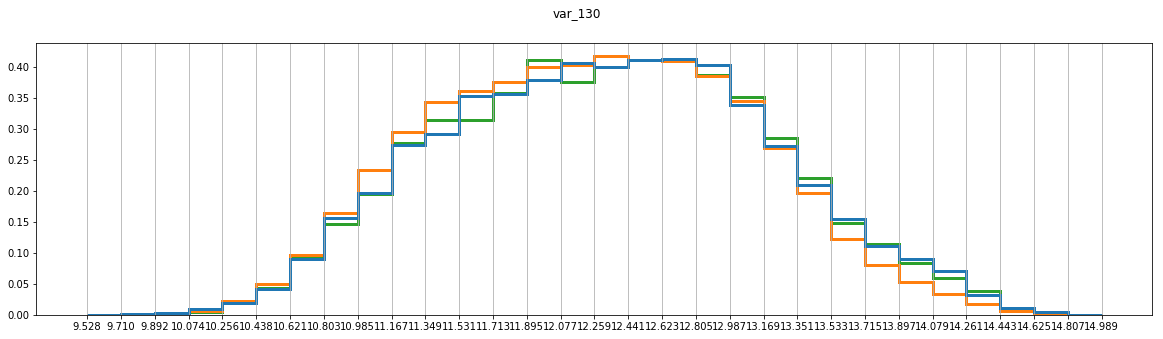

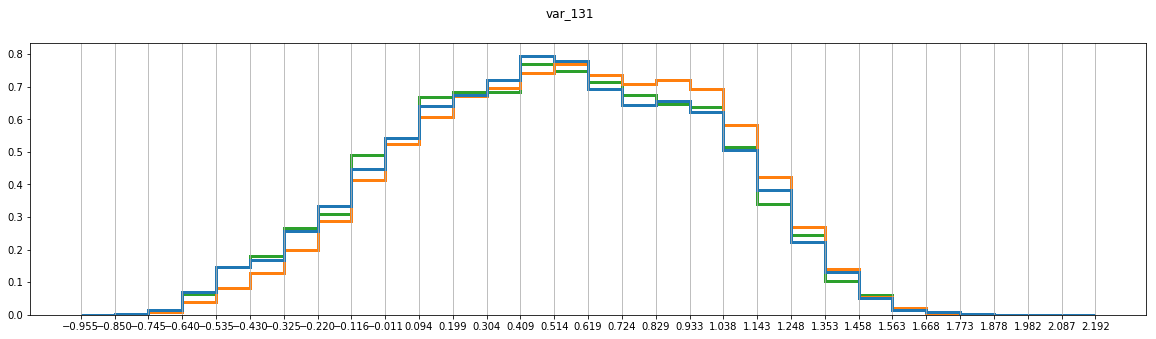

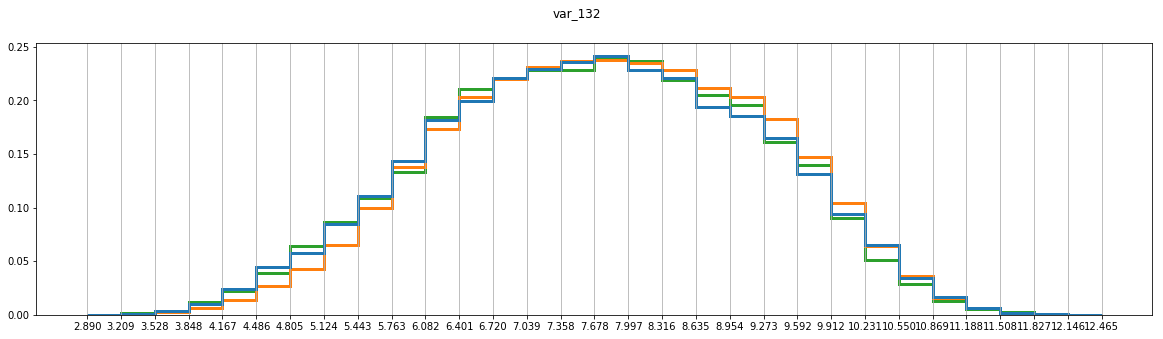

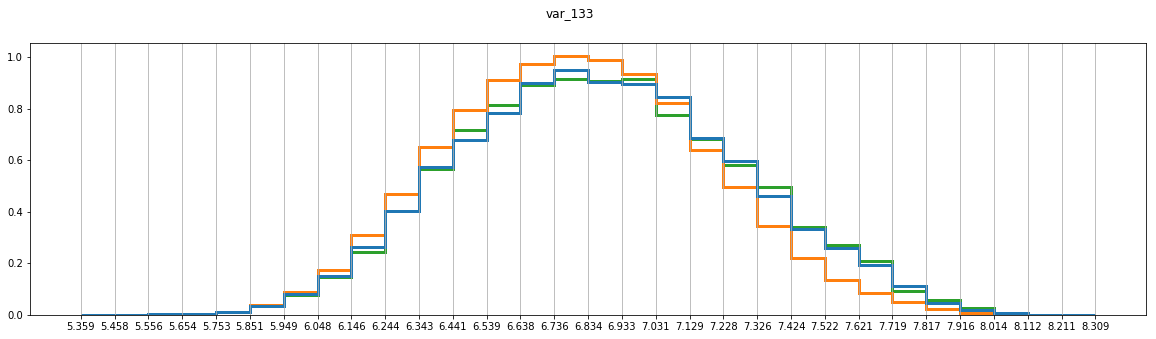

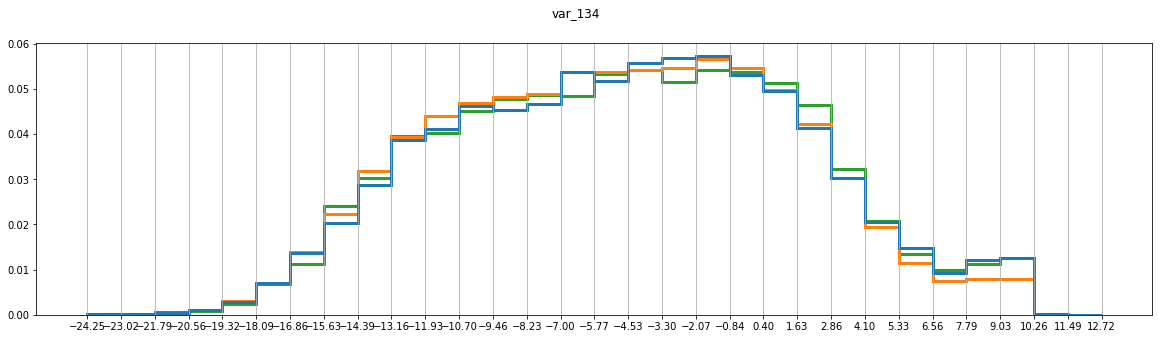

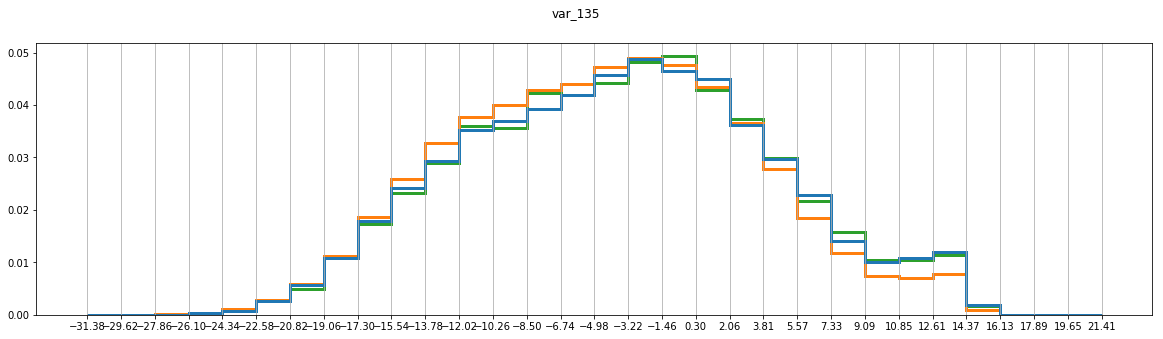

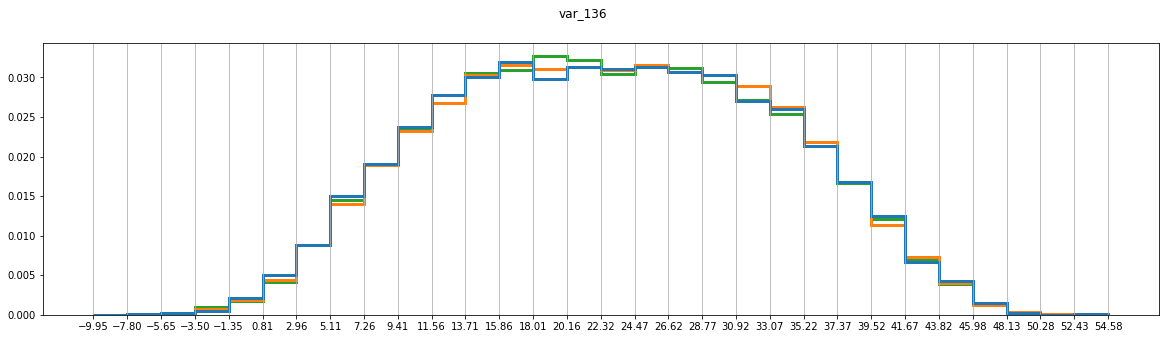

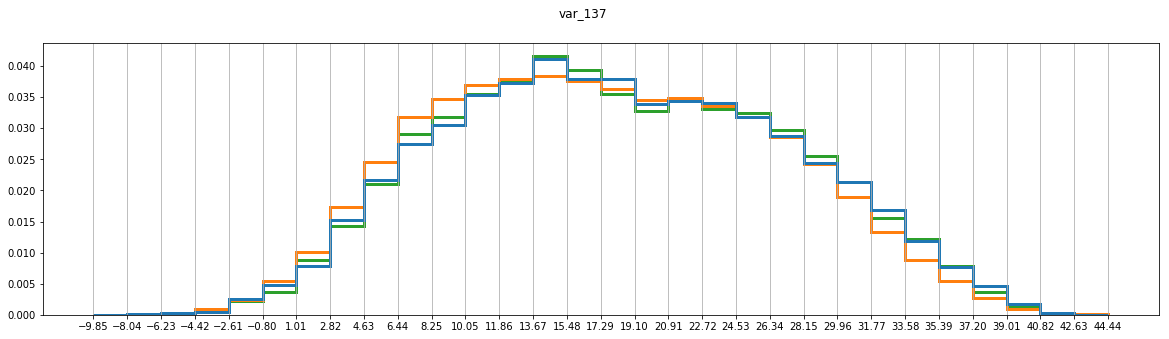

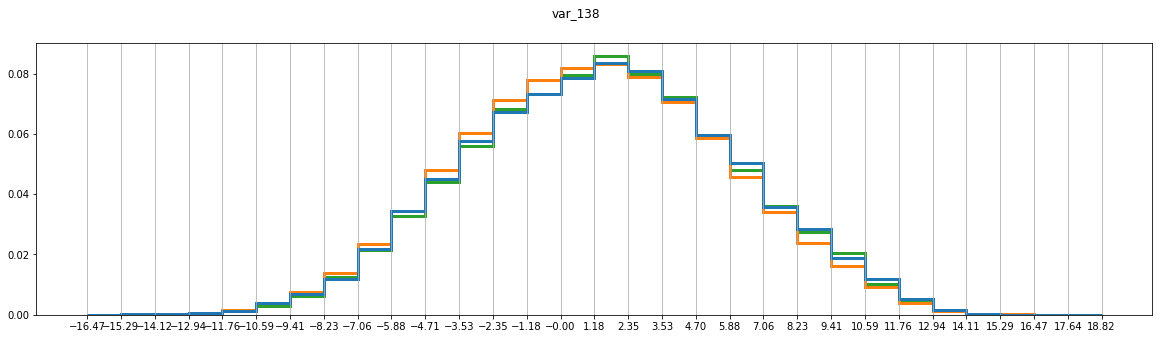

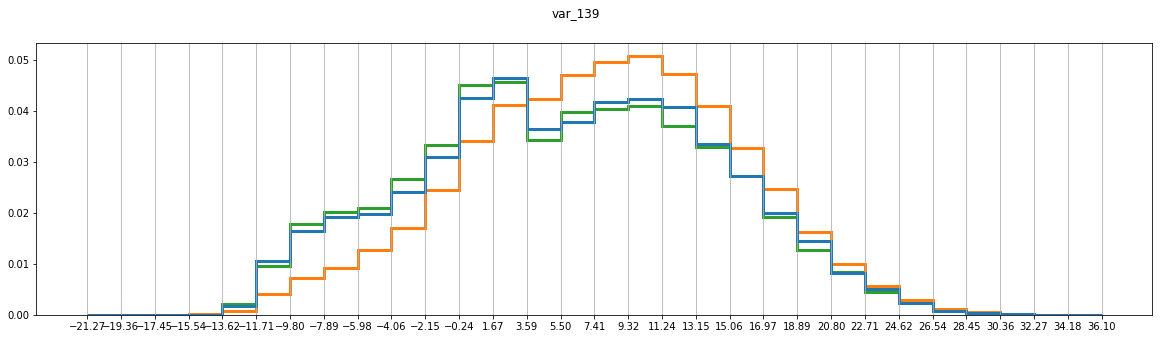

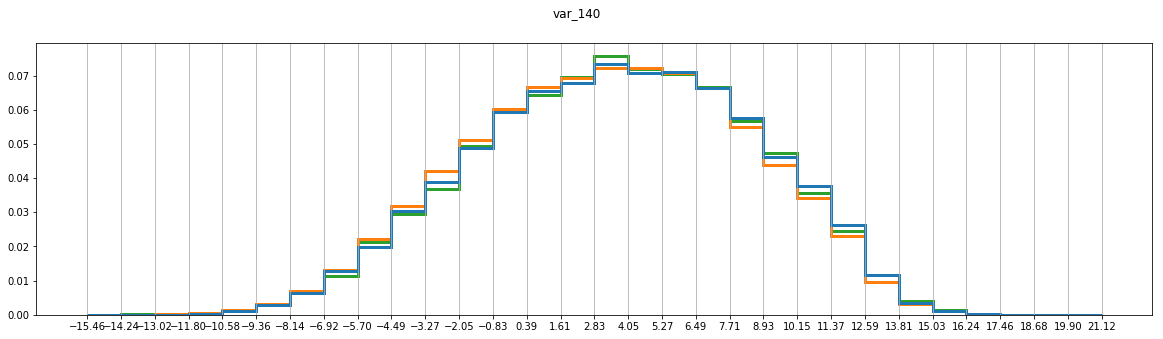

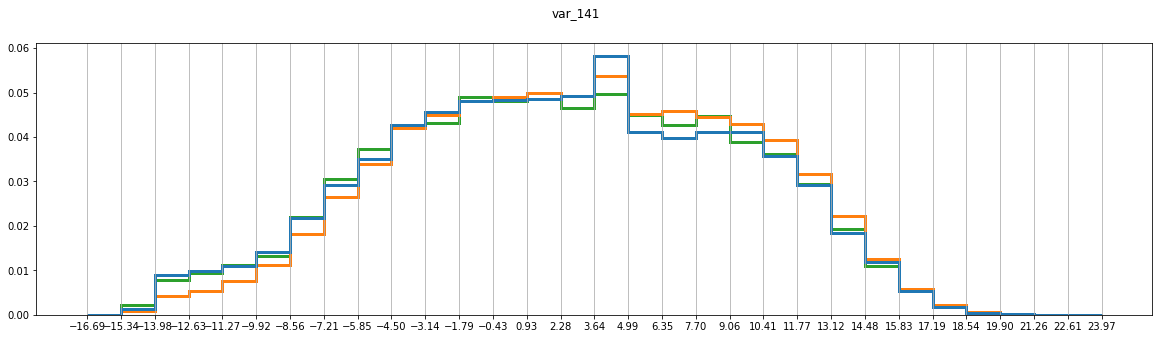

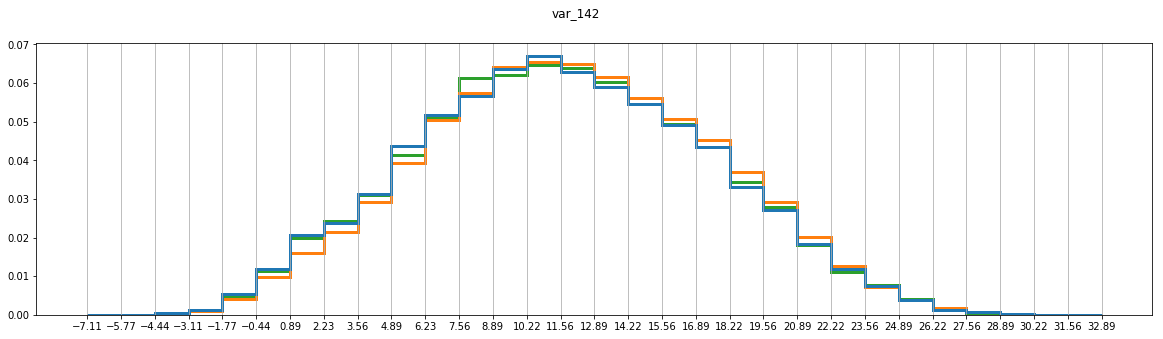

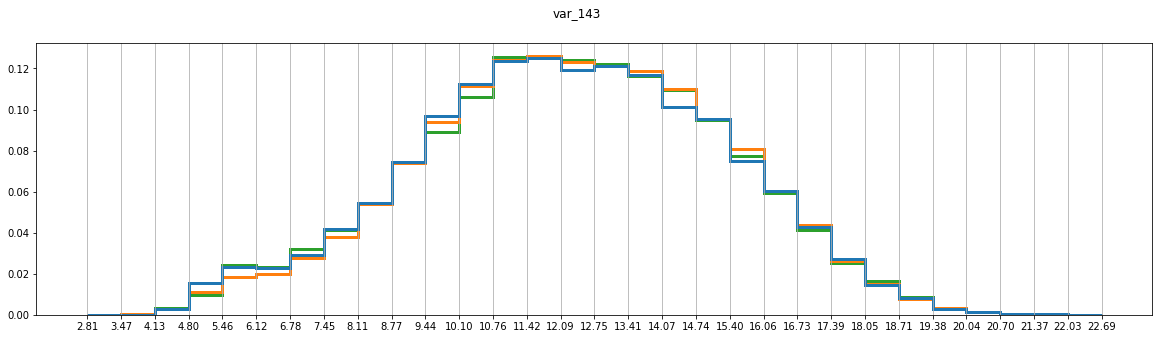

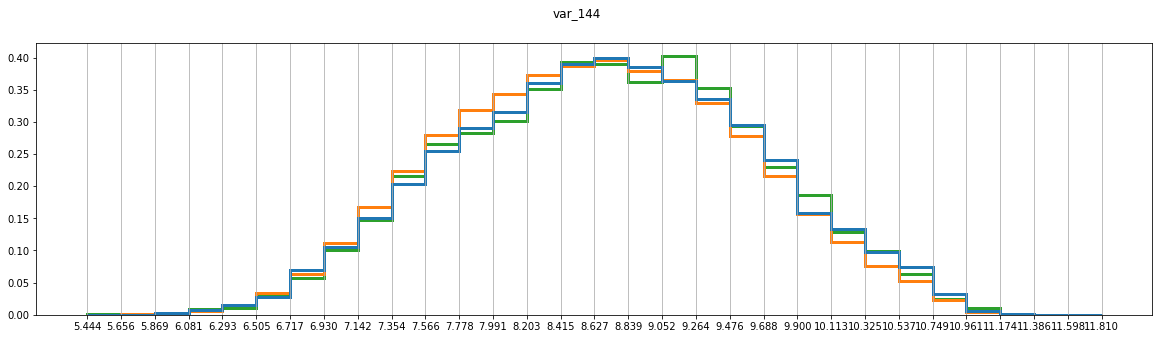

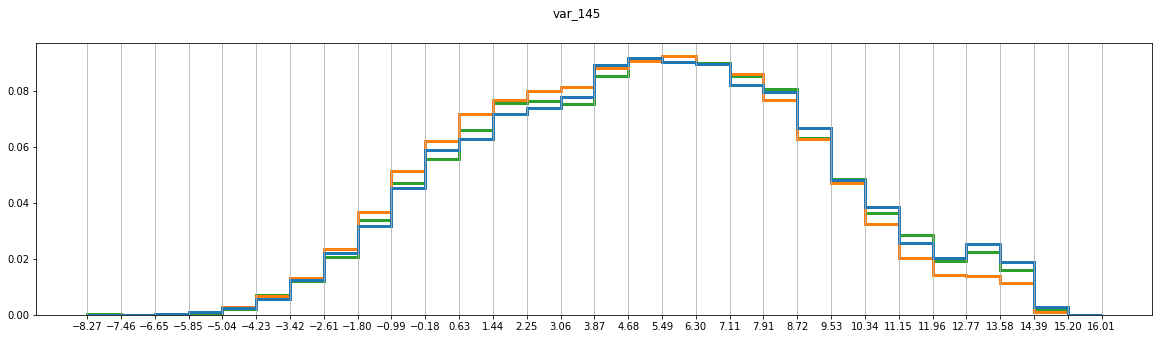

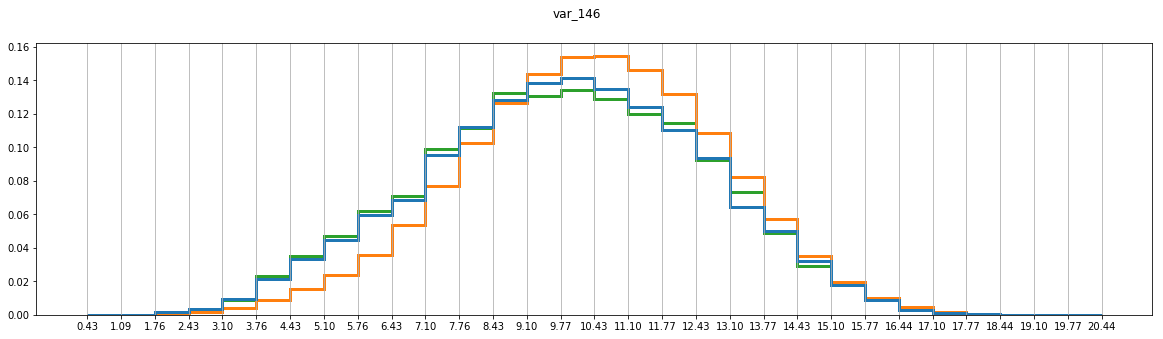

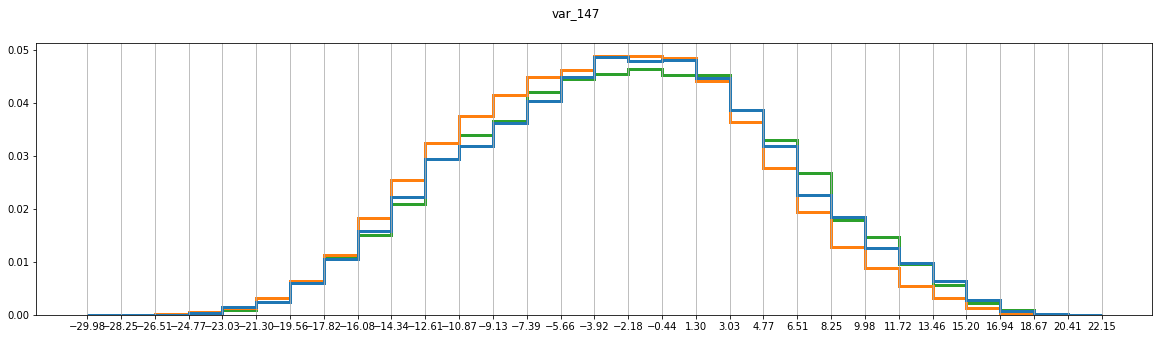

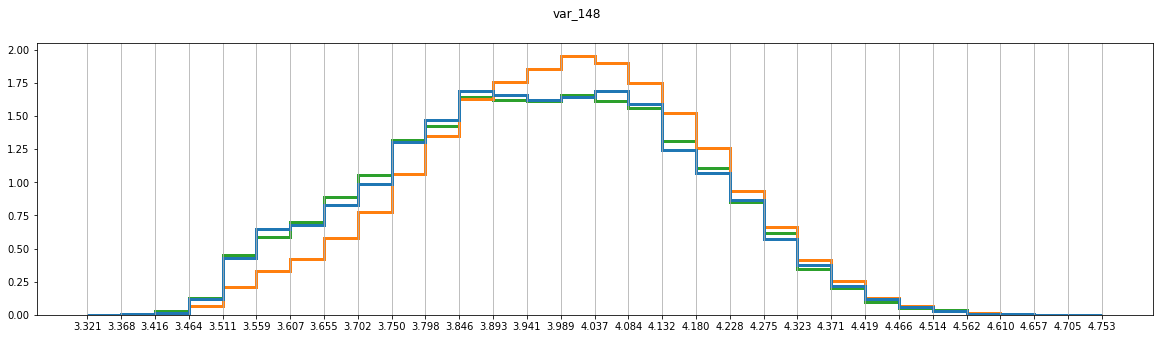

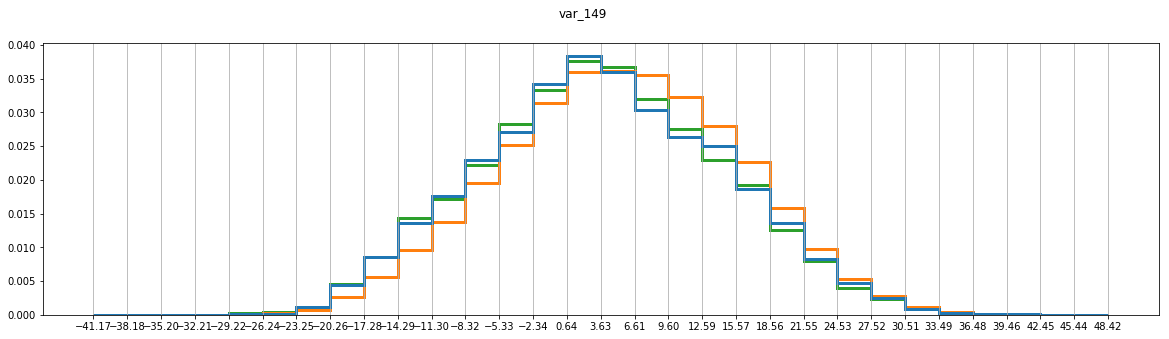

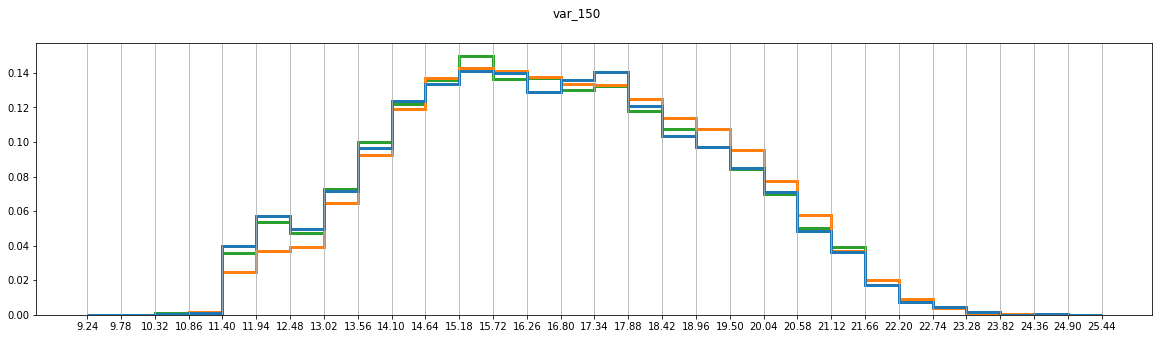

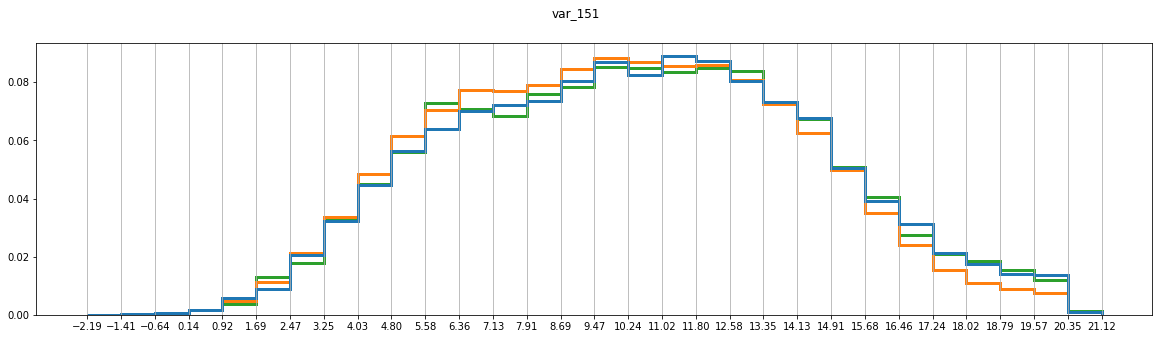

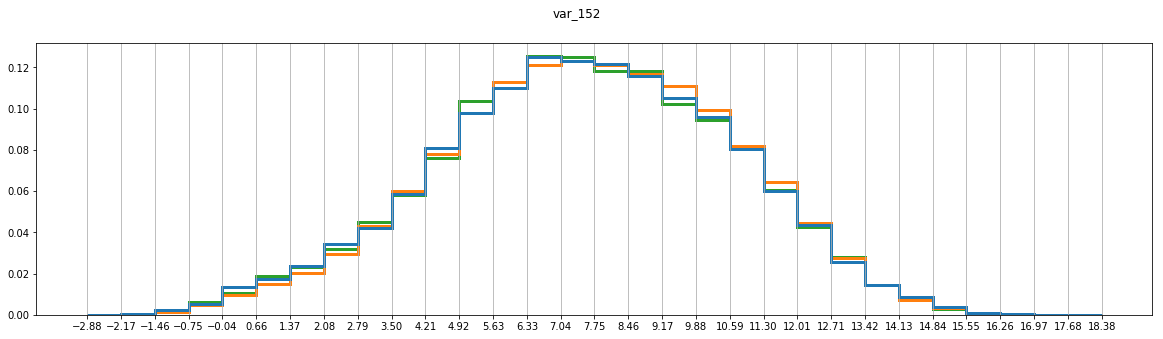

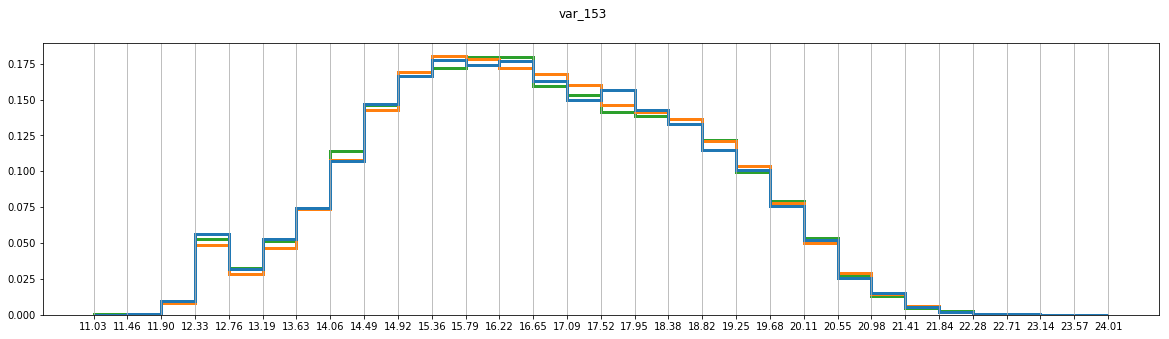

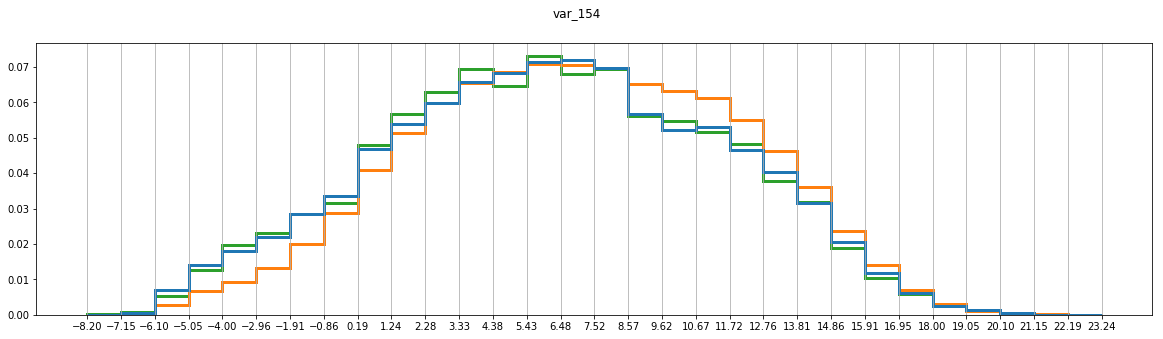

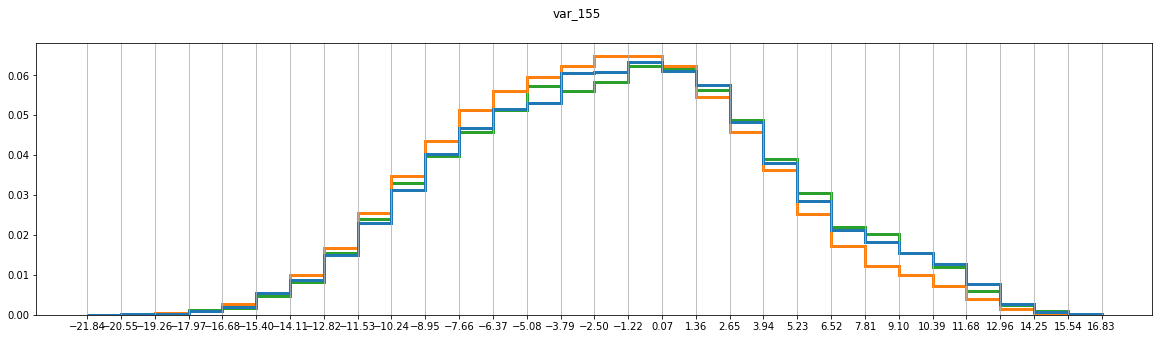

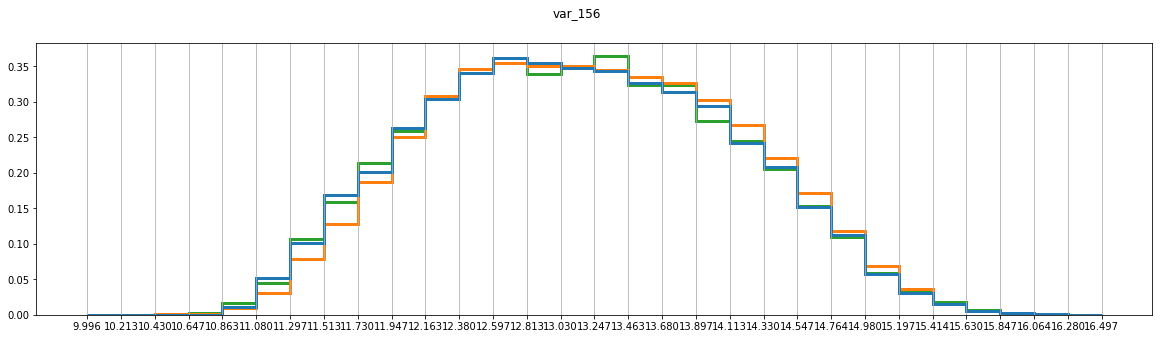

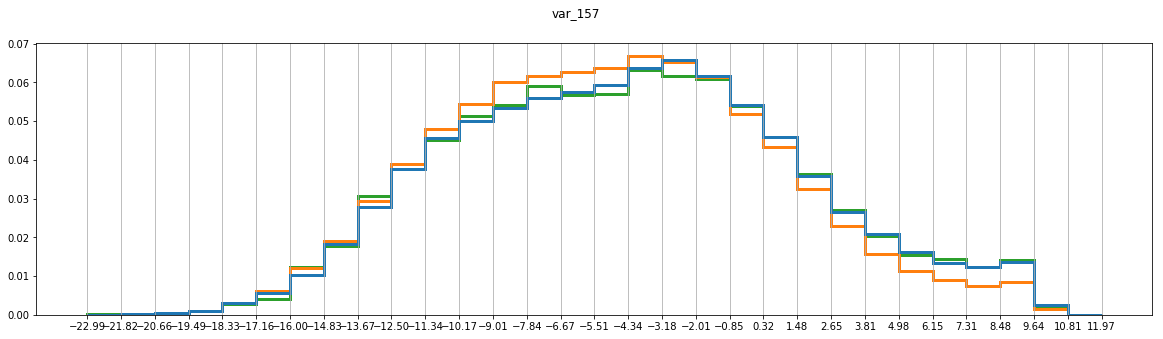

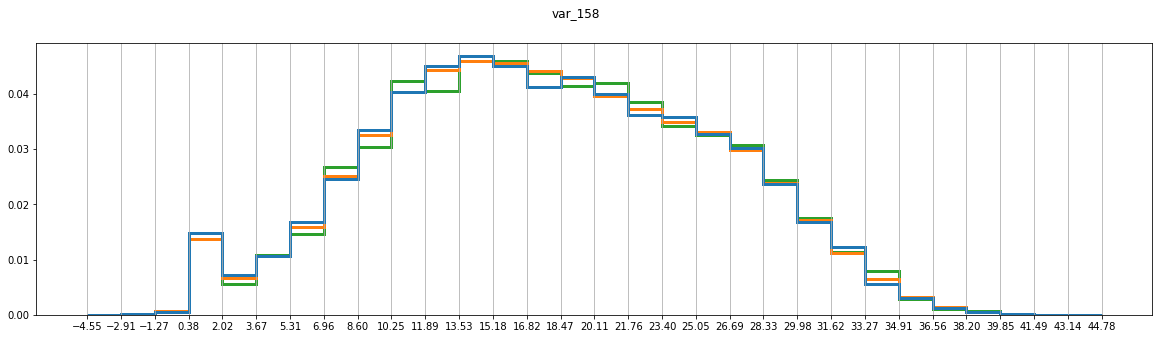

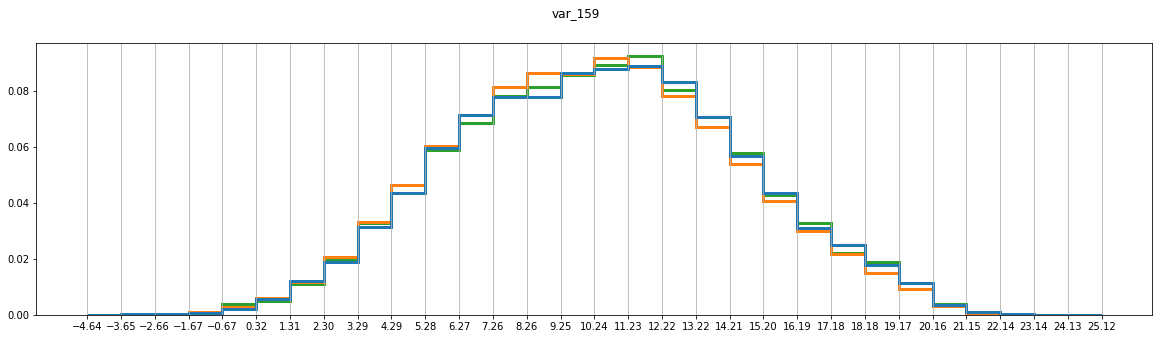

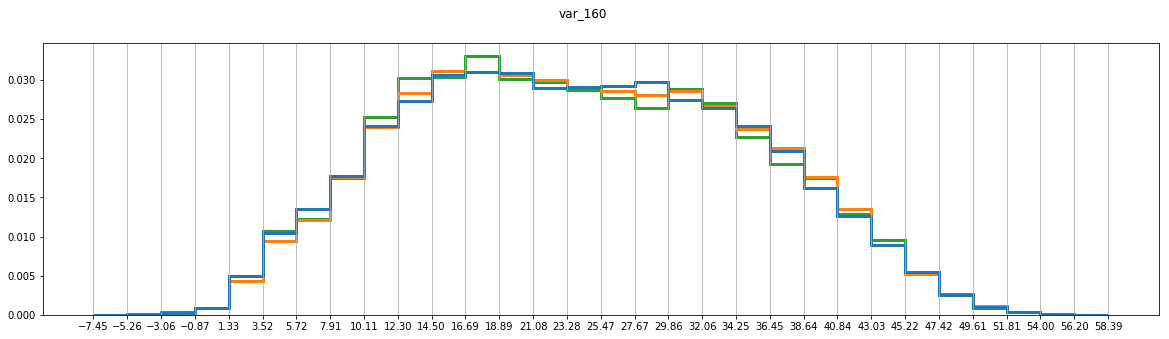

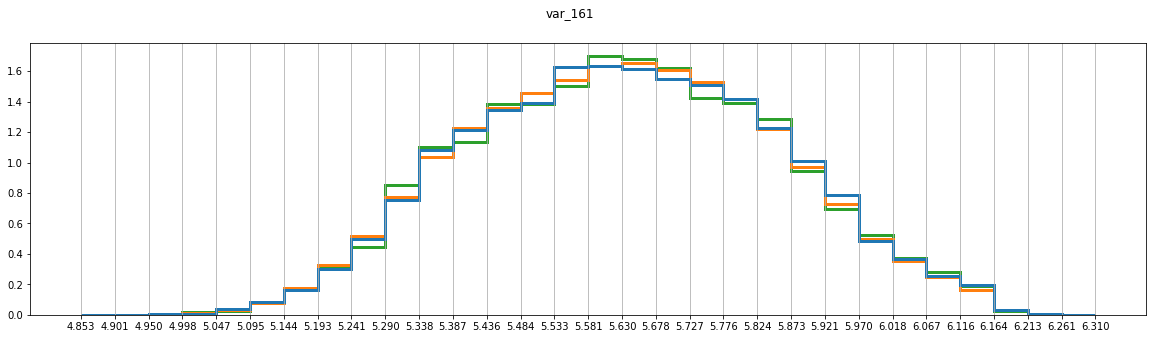

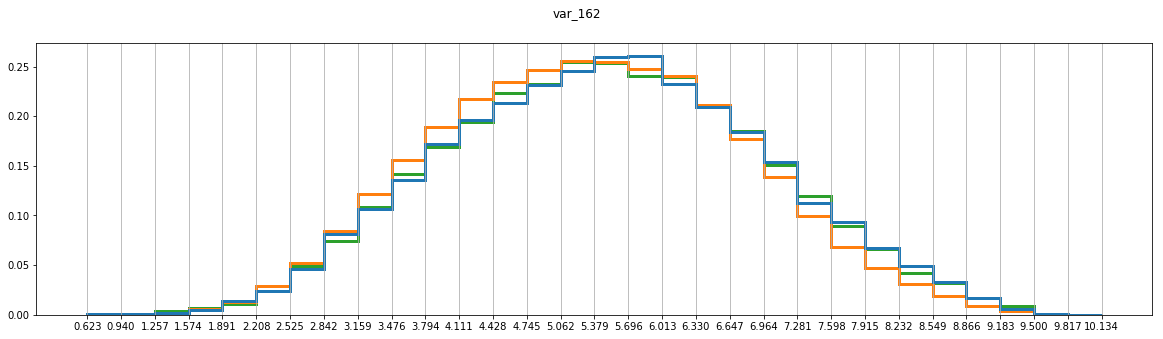

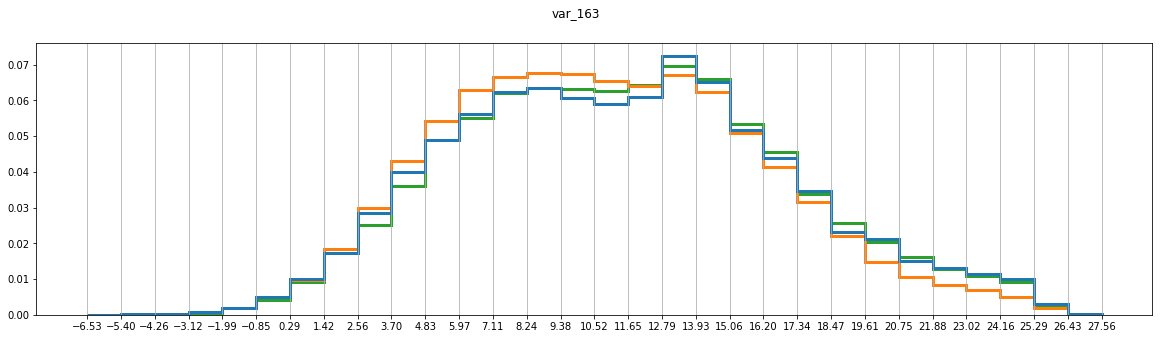

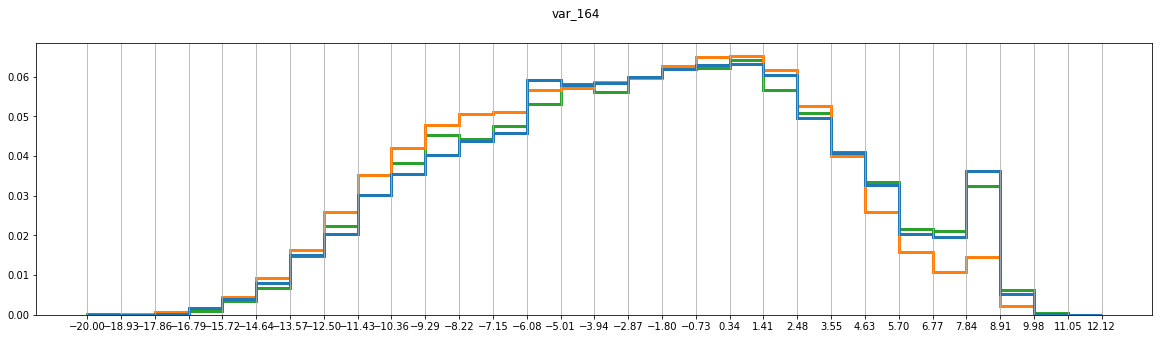

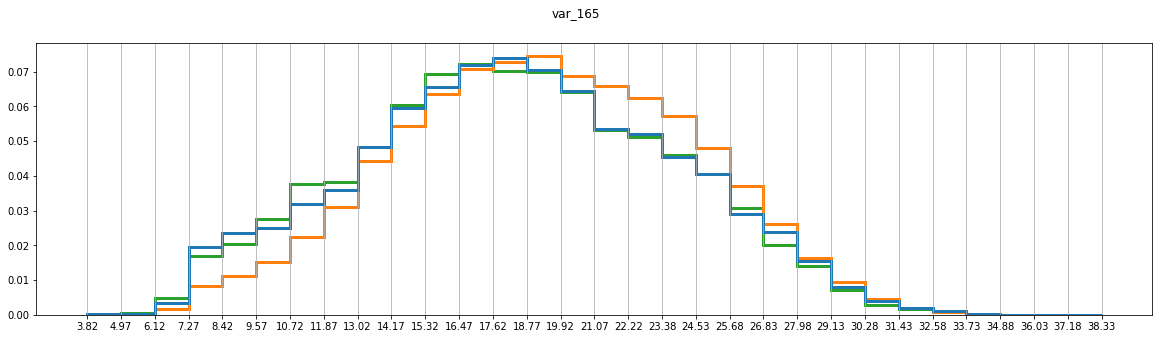

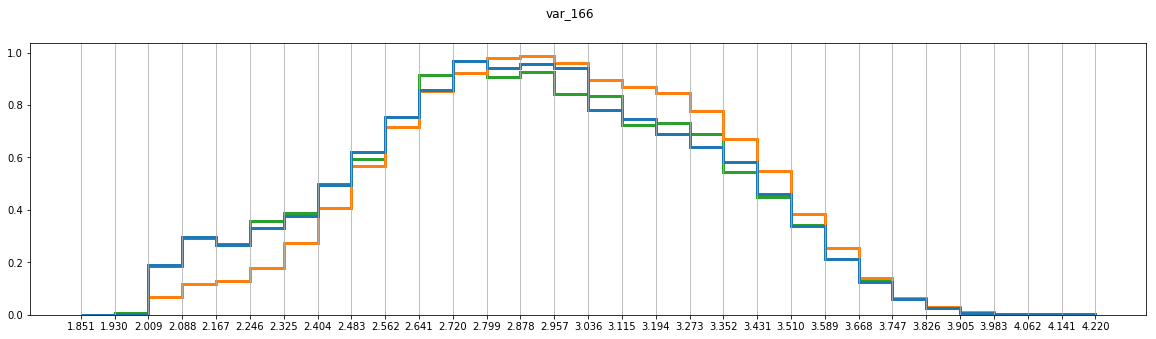

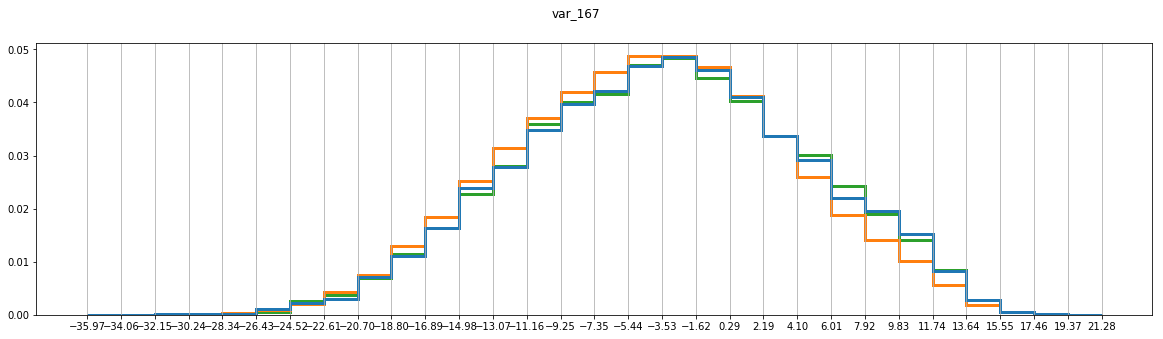

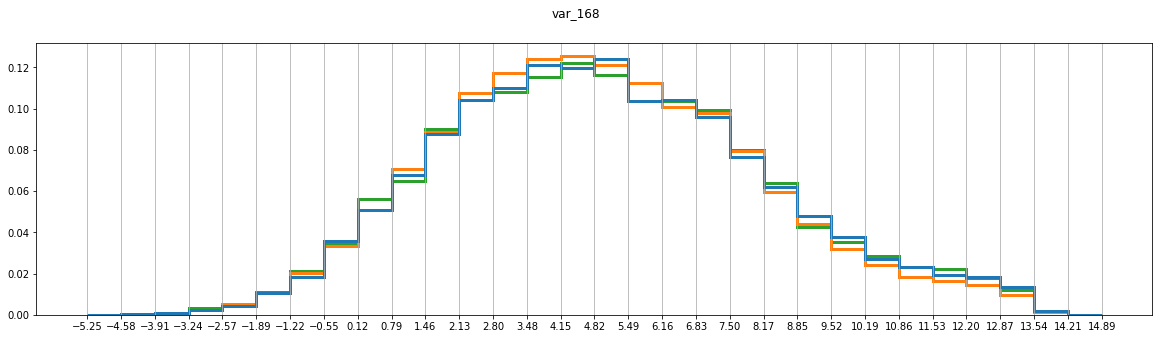

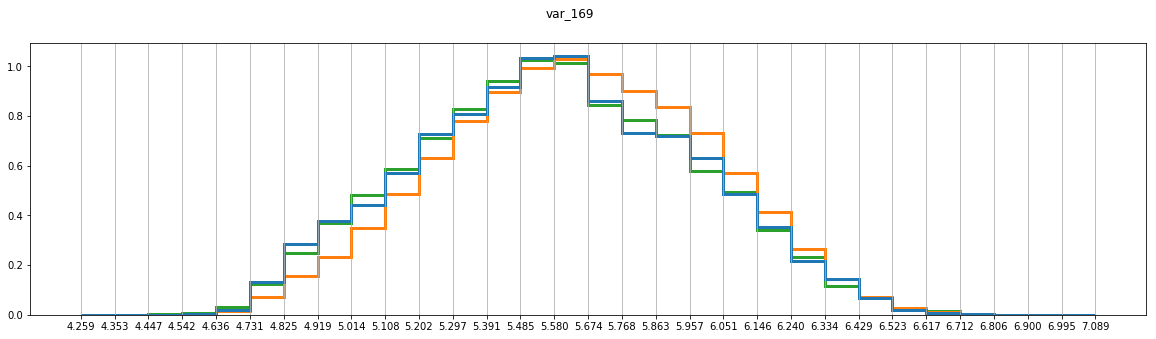

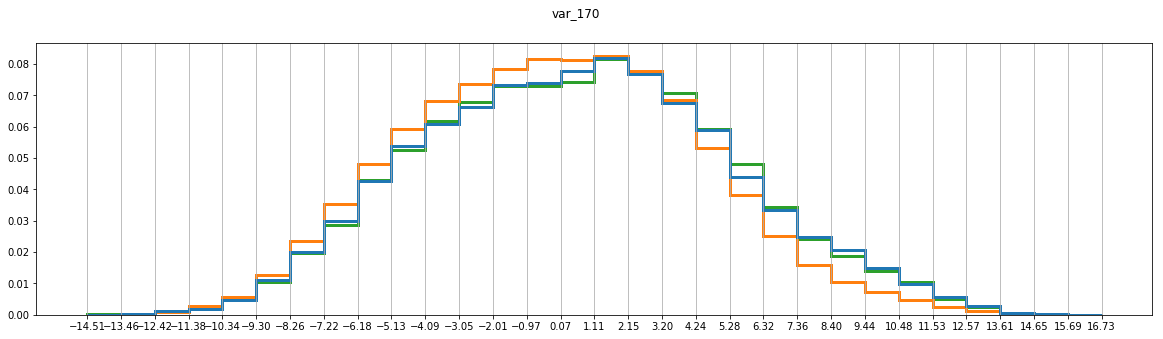

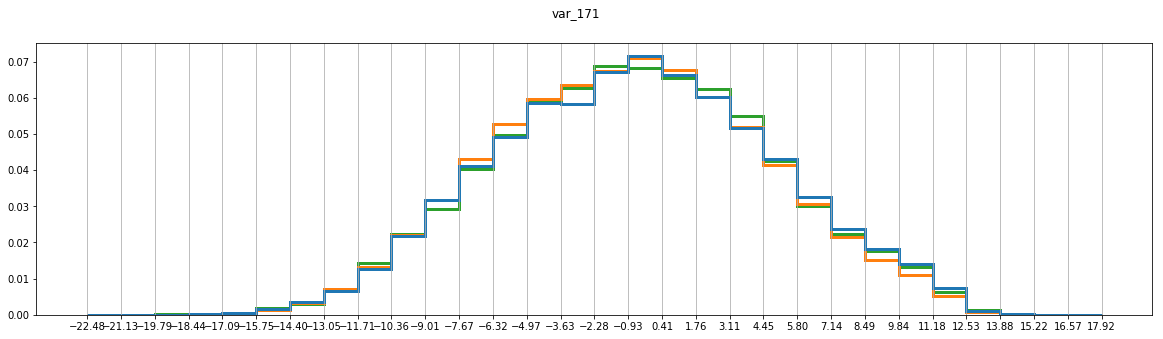

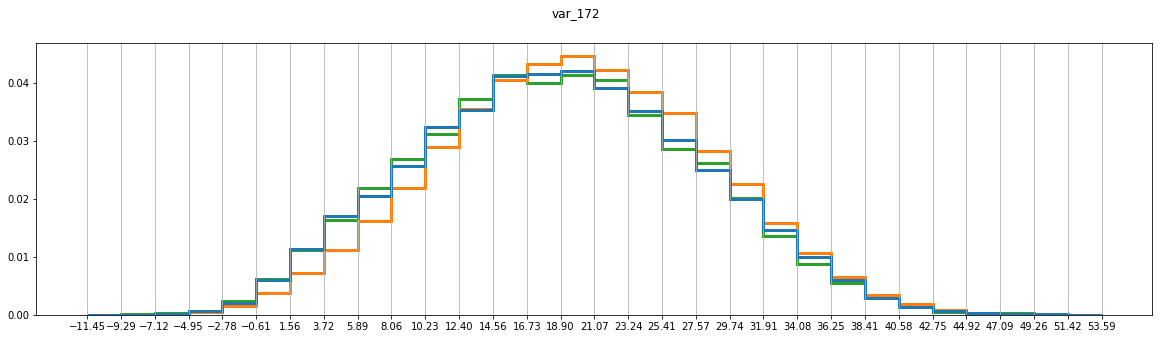

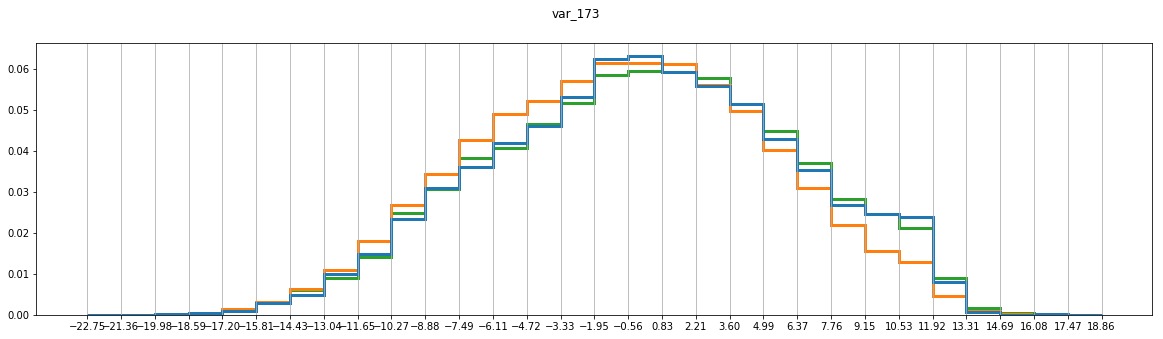

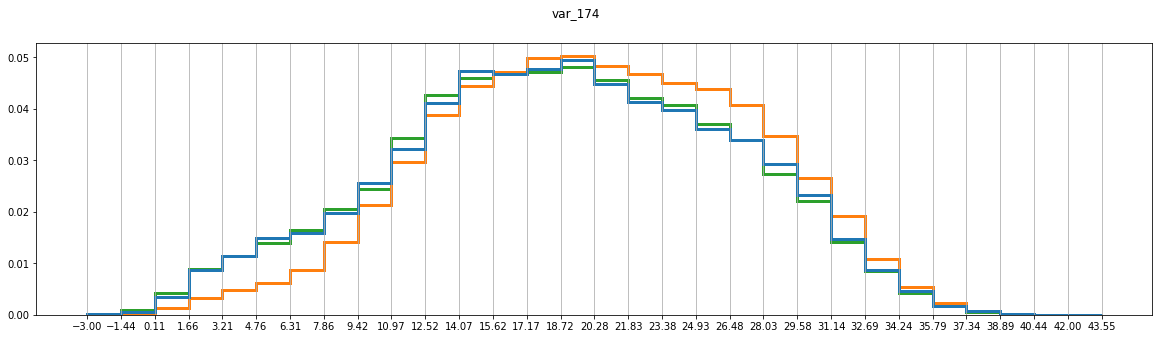

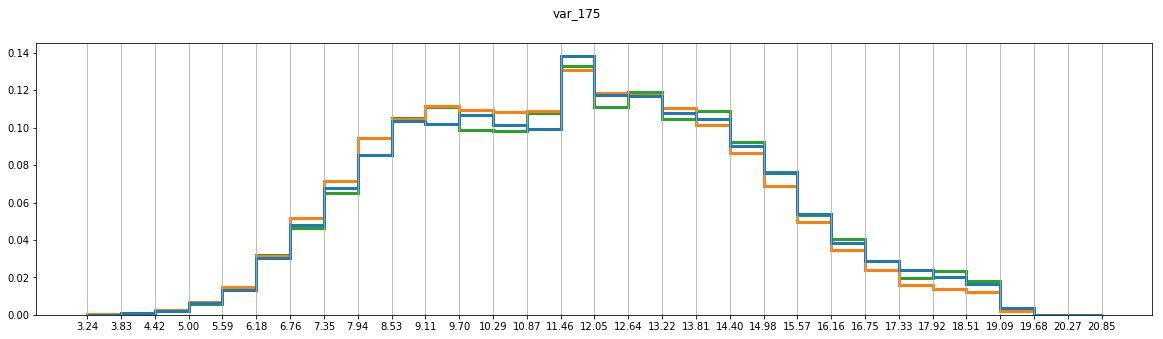

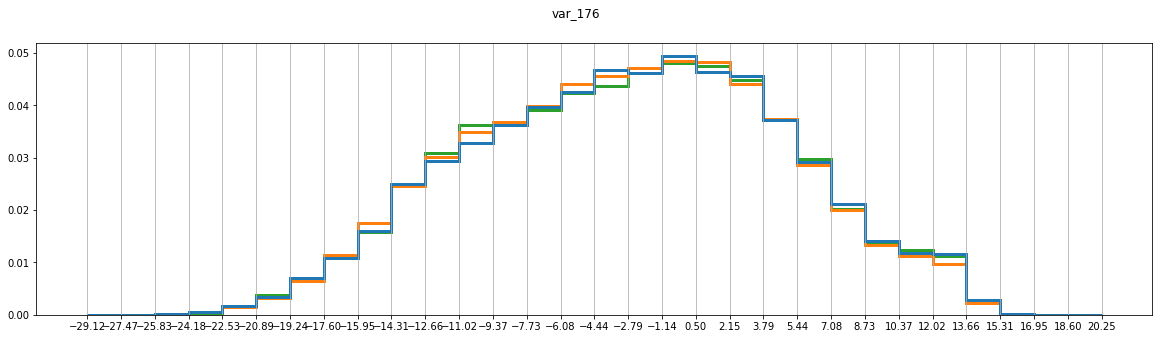

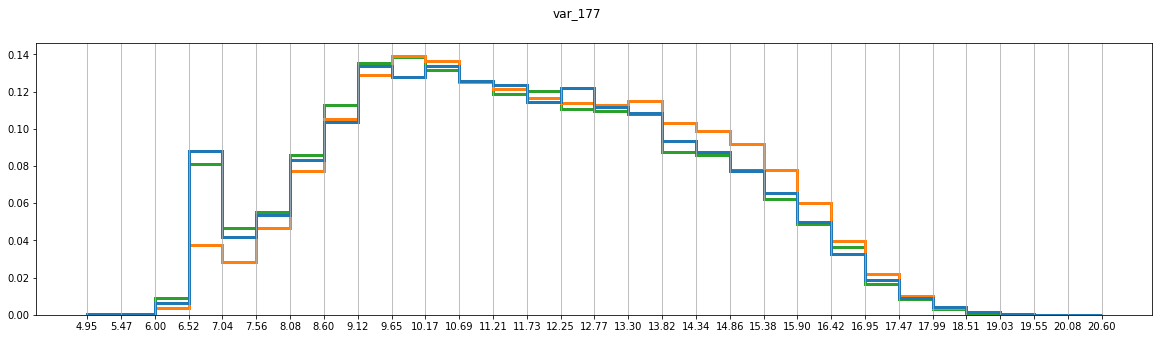

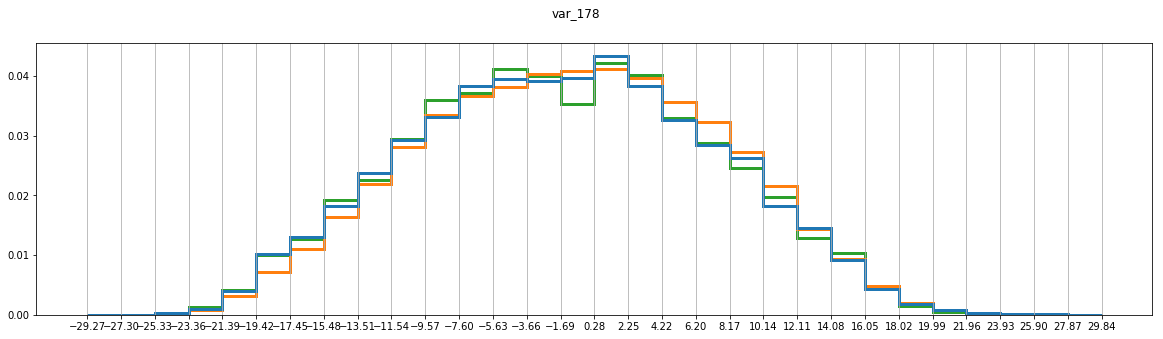

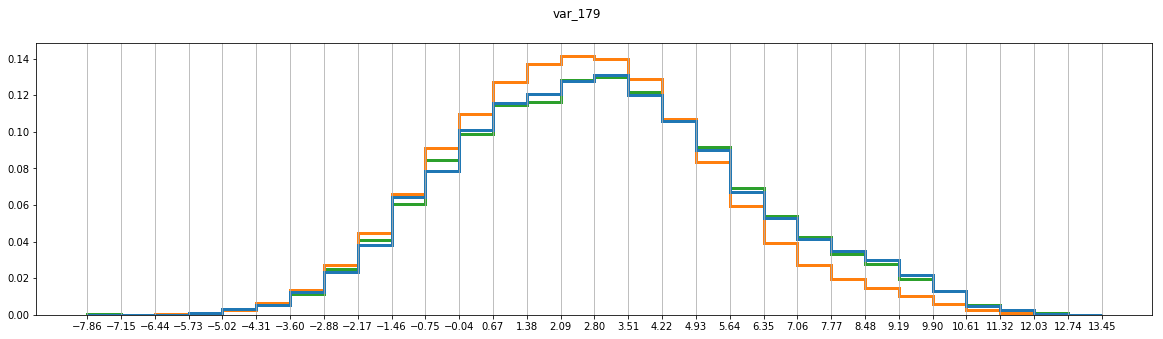

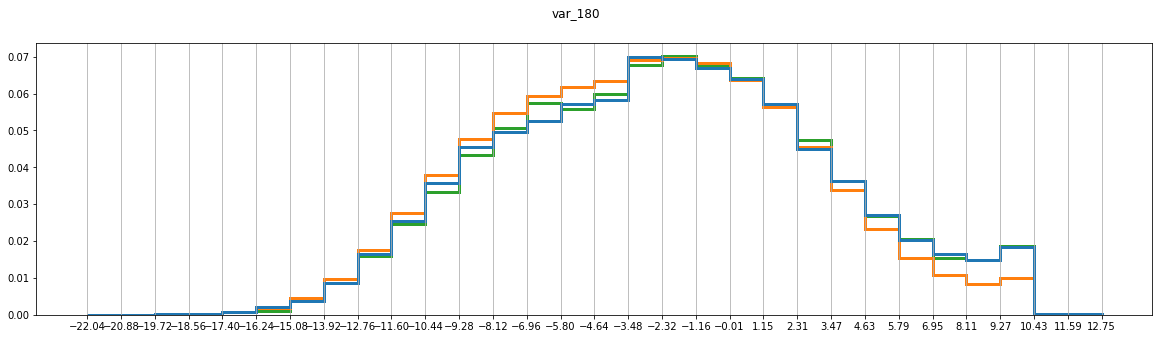

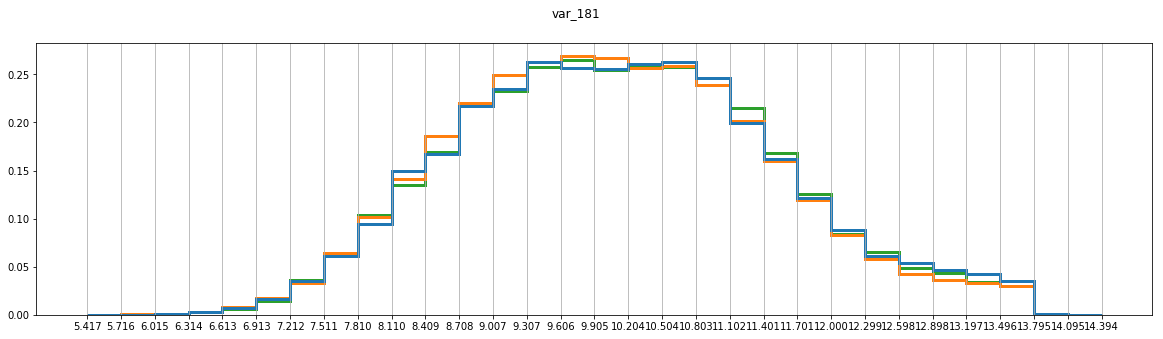

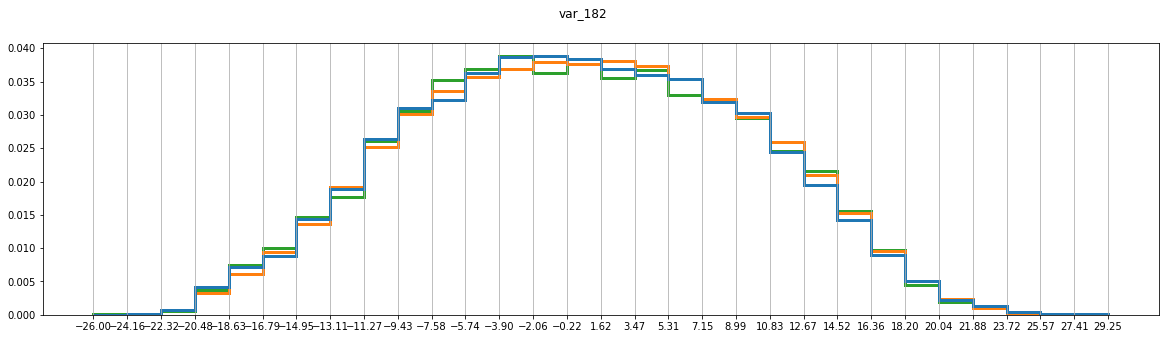

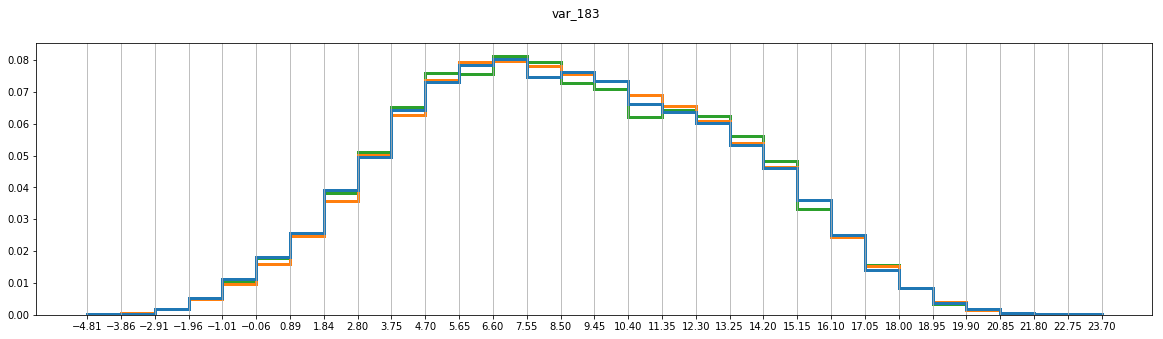

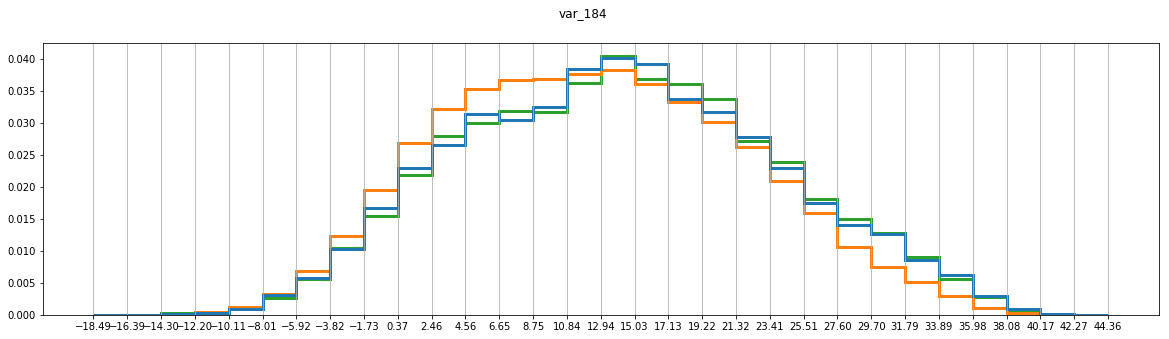

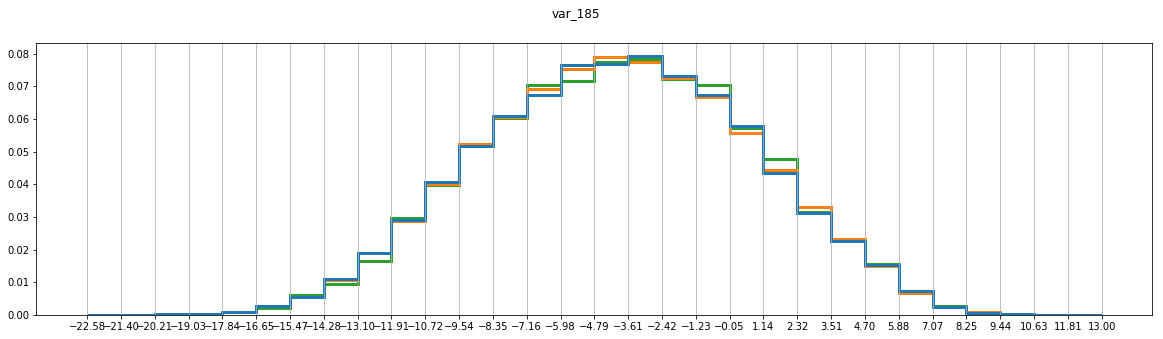

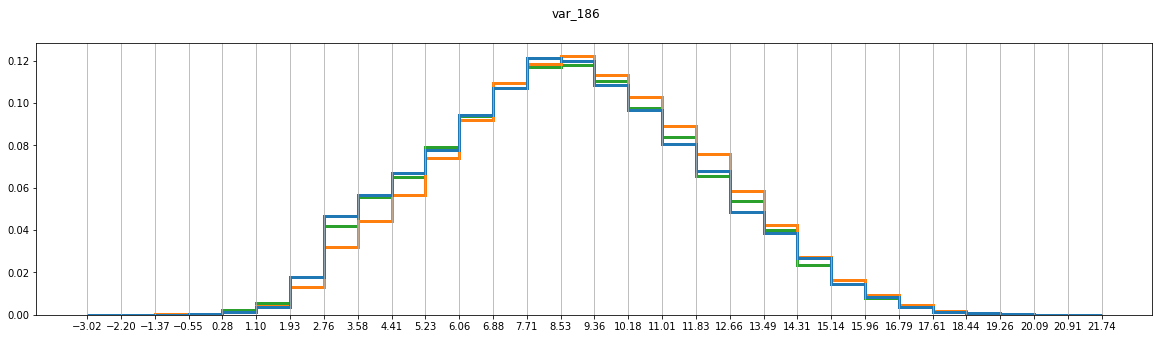

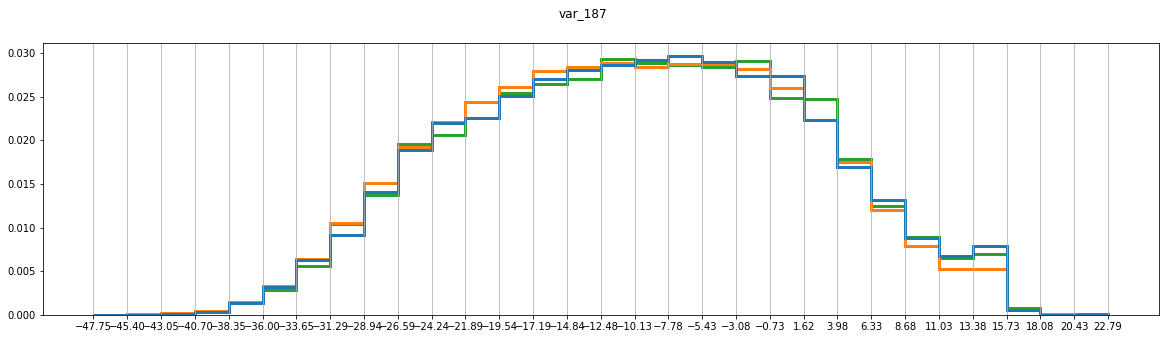

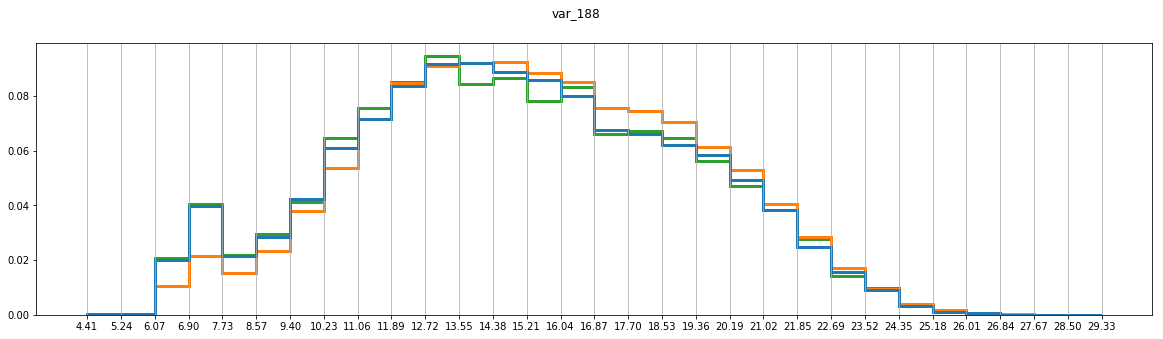

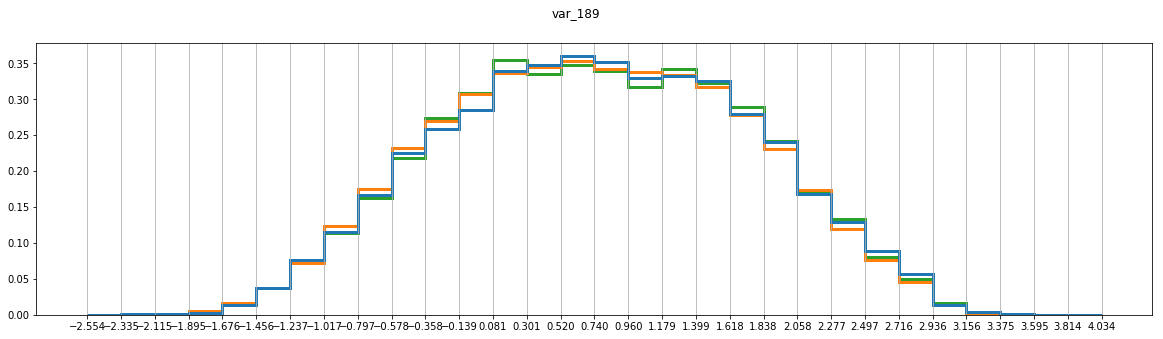

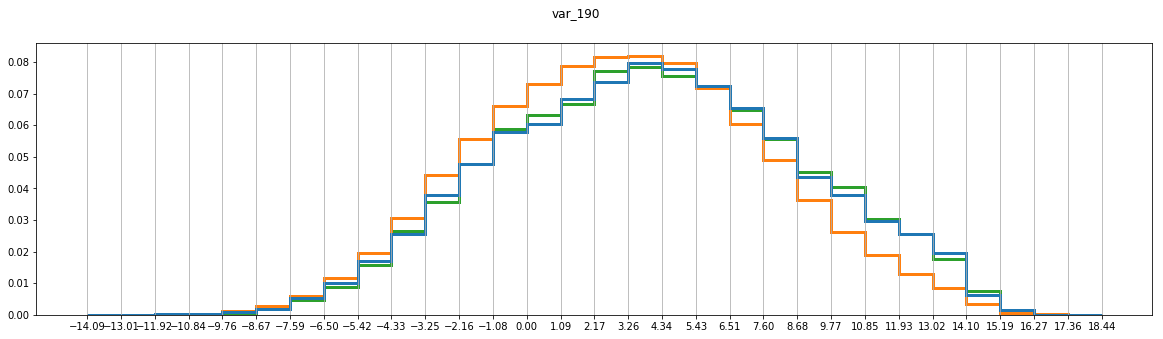

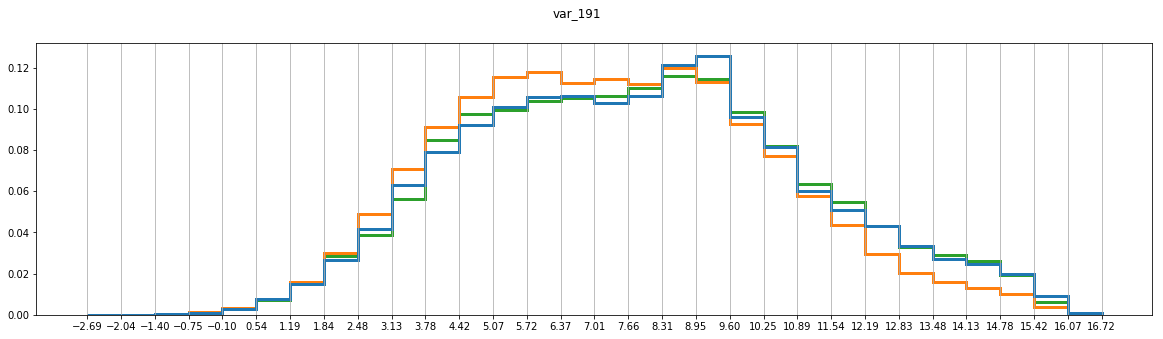

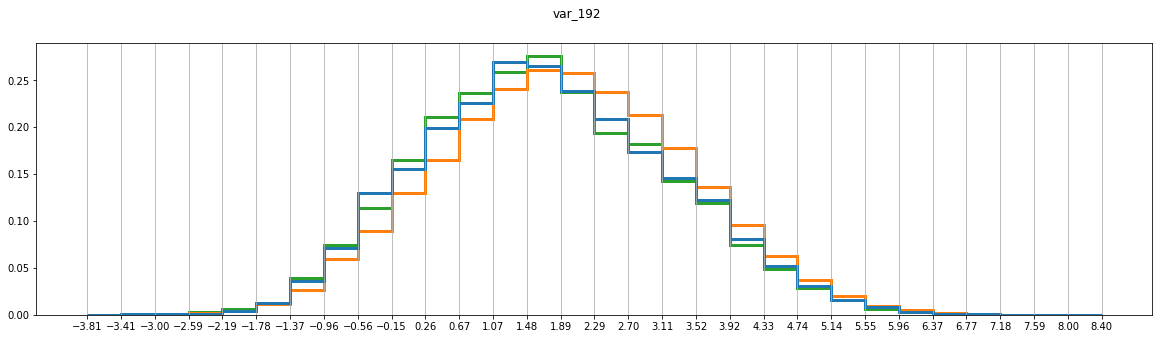

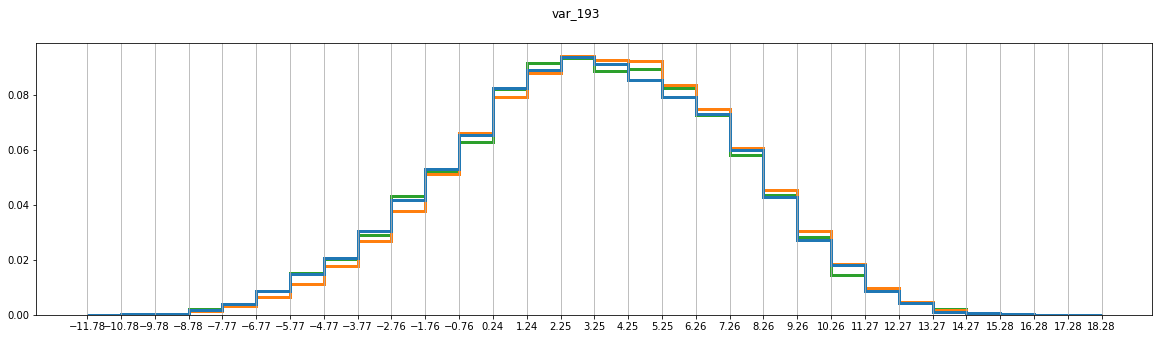

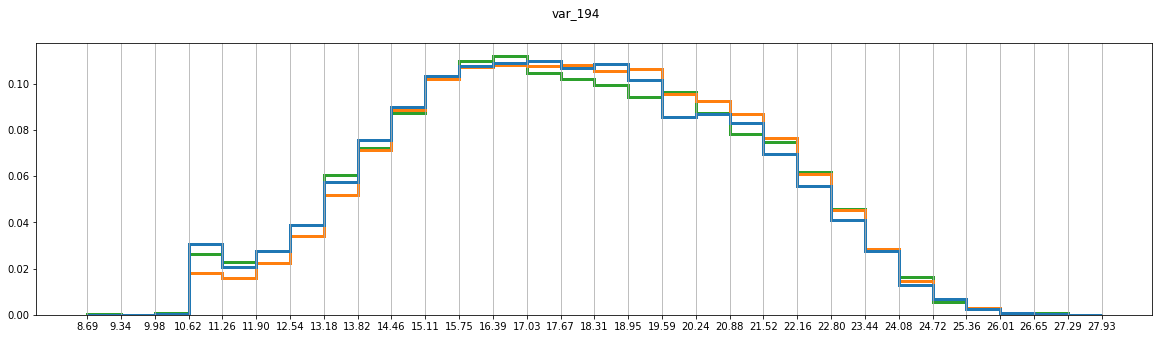

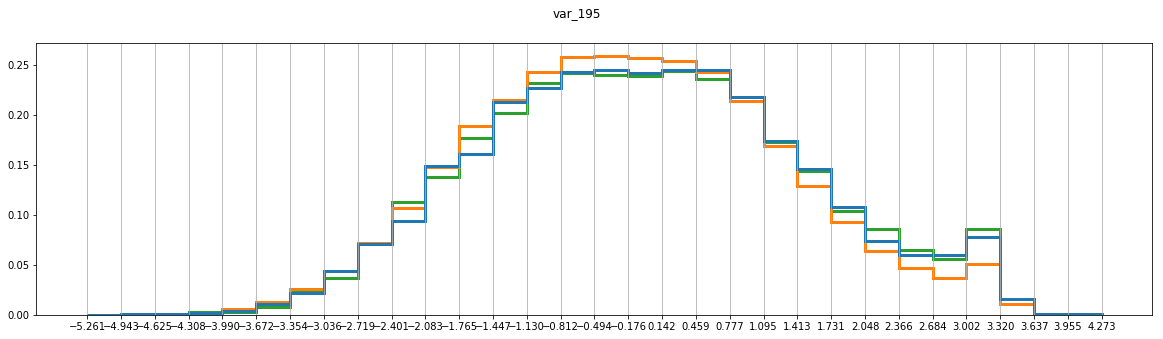

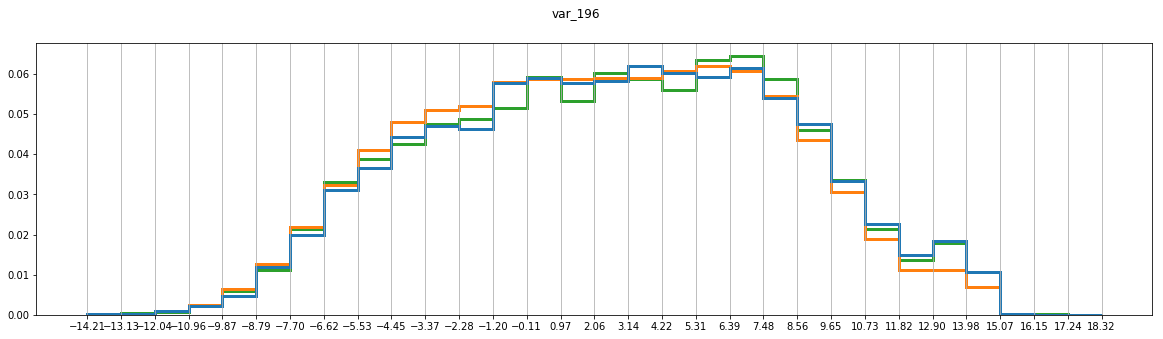

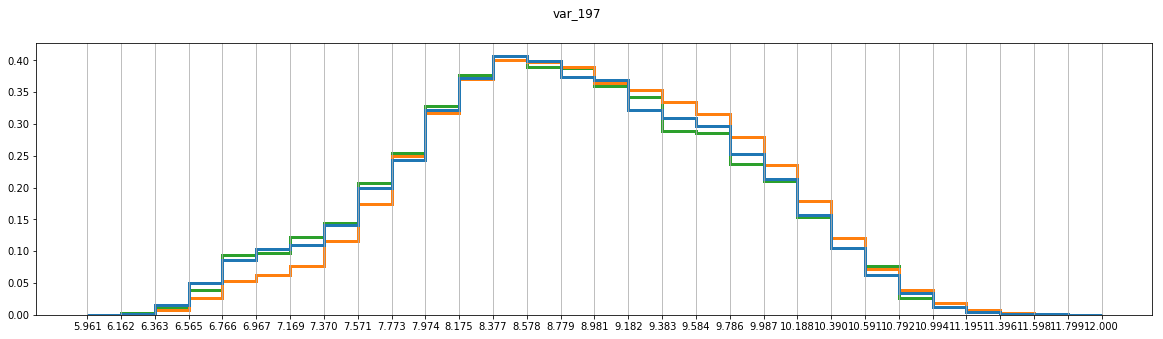

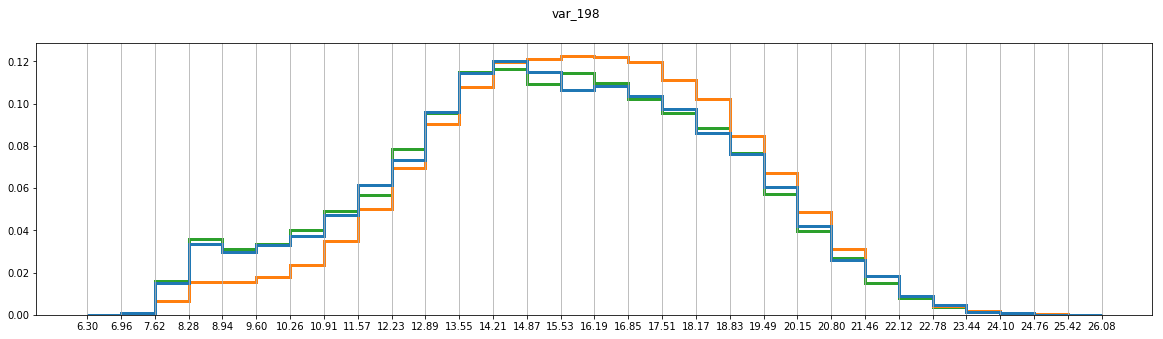

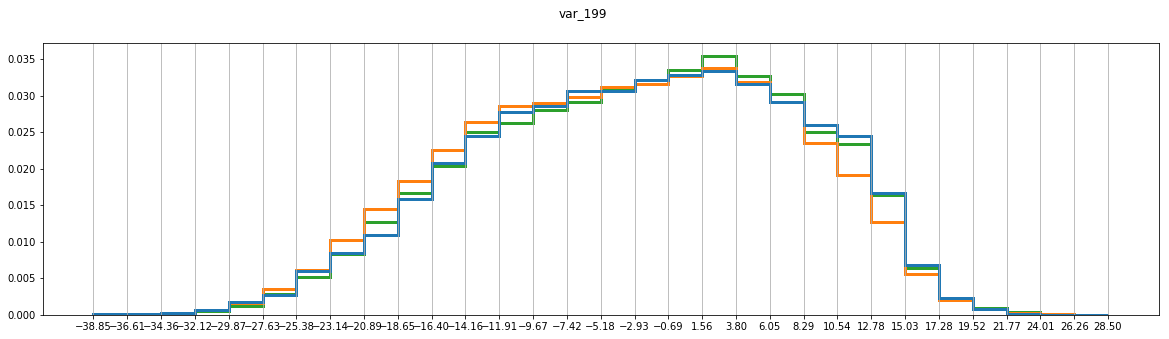

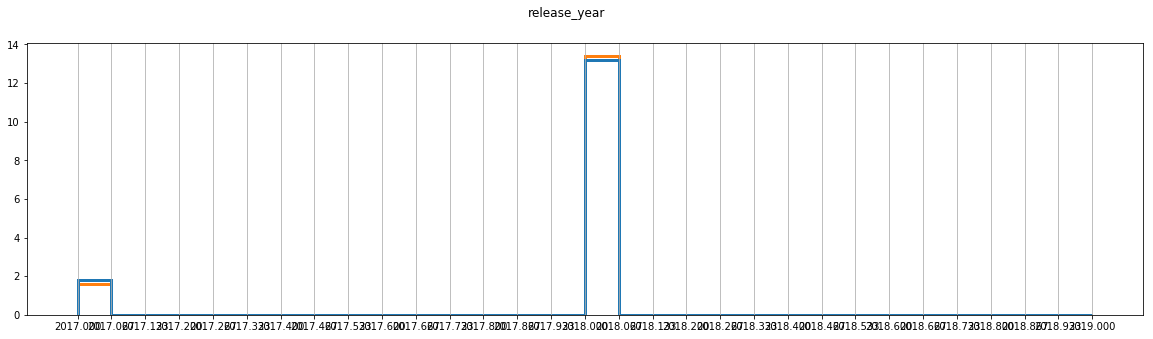

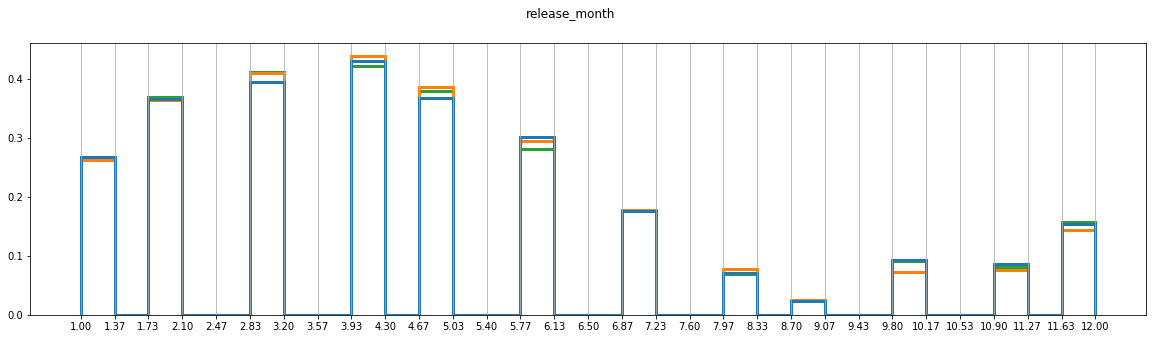

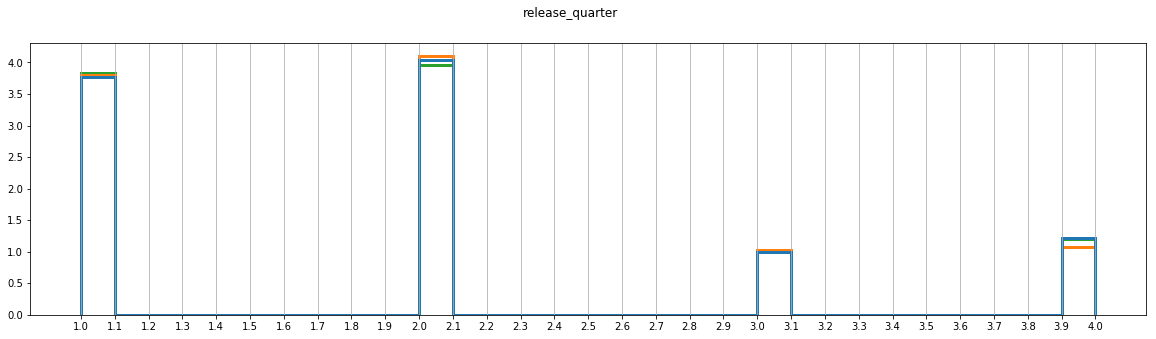

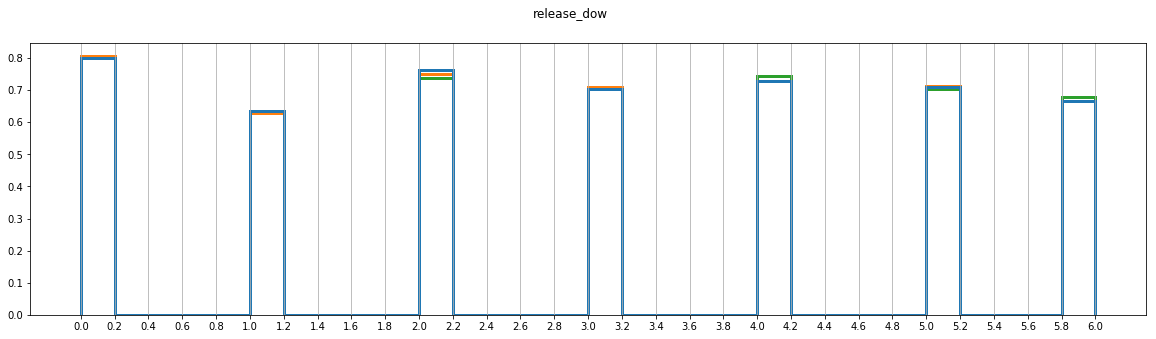

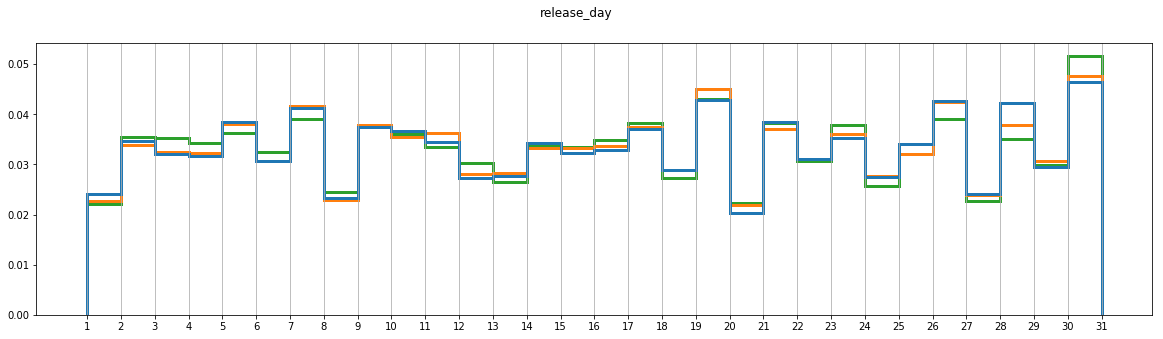

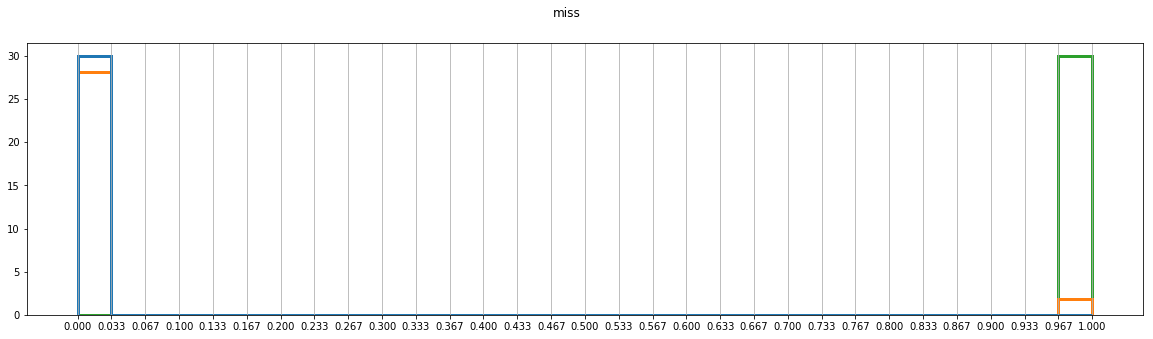

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt

for idx, feature in enumerate(train.keys()):
    if idx==0:
        continue
    negData = train.loc[train['target'] == 1][feature]
    posData = train.loc[train['target'] == 0][feature]
    missData = train.loc[train['miss'] == 1][feature]
    

    fig, ax = plt.subplots(ncols = 1, figsize=(20,5))

    fig.suptitle(feature)
    outs1, outs2, outs3 = ax.hist([negData, posData,missData], 
                                  bins=30, 
                                  density = True, 
                                  histtype='step', 
                                  linewidth=3)
    ax.set_xticks(outs2)
    ax.xaxis.grid(True)

    fig.show()
    plt.show()

In [19]:
df_check['miss'].to_csv('../../02_feature/122_train_miss.csv')